##Install Dependencies


In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install fsspec==2024.10.0
!pip install -q -U git+https://github.com/huggingface/transformers
!pip install datasets
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.10.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 kB 26.6 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.17.0
    Uninstalling peft-0.17.0:
      Successfully uninstalled

In [ ]:
import os
import random
import csv
import re
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    precision_recall_fscore_support,
)

import bitsandbytes as bnb

from datasets import Dataset, DatasetDict
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    pipeline,
    logging,
)

from peft import (
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    PeftModel,
    PeftConfig,
)

from trl import SFTTrainer, setup_chat_format

import wandb
from google.colab import files
from google.colab import userdata


## Environment setup

In [ ]:

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

def set_all_seeds(seed):
       """Set all seeds for reproducibility"""

       random.seed(seed)
       np.random.seed(seed)
       torch.manual_seed(seed)
       if torch.cuda.is_available():
           torch.cuda.manual_seed(seed)
           torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = False

set_all_seeds(49)



In [ ]:
my_secret_key= userdata.get('HF_TOKEN')

In [ ]:
print(f"\nCUDA available: {torch.cuda.is_available()}")



CUDA available: True


##Upload preprocessed datasets Make it compactable for analysis


In [ ]:
print("Please upload files for Aggression detection train data")
agg_train= files.upload()
agg_train= next(iter(agg_train))
agg_train=pd.read_csv(agg_train)

print("Please upload files for Aggression detection validation data")
agg_val= files.upload()
agg_val= next(iter(agg_val))
agg_val=pd.read_csv(agg_val)

print("Please upload files for d1")
d1_test= files.upload()
d1_test= next(iter(d1_test))
d1_test=pd.read_csv(d1_test)

print("Please upload files for d2 Agg test data")
d2_test= files.upload()
d2_test= next(iter(d2_test))
d2_test=pd.read_csv(d2_test)

print("Please upload files for d3 Agg test data")
d3_test= files.upload()
d3_test= next(iter(d3_test))
d3_test=pd.read_csv(d3_test)

print("Please upload files for d4 Agg test data")
d4_test= files.upload()
d4_test= next(iter(d4_test))
d4_test=pd.read_csv(d4_test)

print("Please upload files for d5 Agg test data")
d5_test= files.upload()
d5_test= next(iter(d5_test))
d5_test=pd.read_csv(d5_test)

Please upload files for Aggression detection train data


Saving train_agg.csv to train_agg.csv
Please upload files for Aggression detection validation data


Saving dev_agg .csv to dev_agg .csv
Please upload files for d1


Saving d1_test_with_cyb.csv to d1_test_with_cyb.csv
Please upload files for d2 Agg test data


Saving d2_test_with_cyb.csv to d2_test_with_cyb.csv
Please upload files for d3 Agg test data


Saving d3_test_with_cyb.csv to d3_test_with_cyb.csv
Please upload files for d4 Agg test data


Saving d4_test_with_cyb.csv to d4_test_with_cyb.csv
Please upload files for d5 Agg test data


Saving d5_test_with_cyb.csv to d5_test_with_cyb.csv


In [ ]:
agg_train.head()

,text,label
0,"""Asked if these files of historic value were s...",not aggressive
1,I have to say this. Without a civilian governm...,not aggressive
2,Ladies and Gentlemen This man wants to get awa...,overtly aggressive
3,Just curious are the BJP leaders sitting on dh...,covertly aggressive
4,US President Barack Obama congratulates [USER]...,not aggressive


In [ ]:
from sklearn.utils import resample

min_count = agg_train['label'].value_counts().min()

balanced_train_dfs = [resample(agg_train[agg_train['label'] == lbl], replace=False, n_samples=min_count, random_state=42)
                       for lbl in agg_train['label'].unique()]
balanced_train_df = pd.concat(balanced_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Label Distribution:\n", balanced_train_df['label'].value_counts())

Balanced Label Distribution:
 label
not aggressive         6516
covertly aggressive    6516
overtly aggressive     6516
Name: count, dtype: int64


In [ ]:
balanced_train_df = balanced_train_df.reset_index(drop=True)
agg_val = agg_val.reset_index(drop=True)


In [ ]:
class_weights=(1/balanced_train_df.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()

print(f"class weights:{class_weights}")

dataset_train = balanced_train_df
dataset_val =agg_val

dataset = DatasetDict({
    'train': Dataset.from_pandas(dataset_train),
    'val': Dataset.from_pandas(dataset_val)
})

class weights:tensor([0.3333, 0.3333, 0.3333])


In [ ]:
balanced_train_df.head()

,text,label
0,[USER] [USER] Fully understand. That is why I ...,not aggressive
1,But hazzare ji what u did after that??? [HASHT...,covertly aggressive
2,"""Asked if these files of historic value were s...",not aggressive
3,If people dont support and think he is not a g...,covertly aggressive
4,Its fake. Indians nothing have to say except b...,overtly aggressive


##Prompt for training and testing

In [ ]:
def create_training_prompt(row):
    return f"""You are a strict Aggression classifier.
Analyze the text and classify it into exactly one category:

The possible categories are:
- not aggressive: neutral or non-hostile statements
- covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks
- overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility

TEXT: "{row['text']}"

Auxiliary information: Not provided

CLASSIFICATION: {row['label']}""".strip()

In [ ]:
balanced_train_df['text'] = balanced_train_df.apply(create_training_prompt, axis=1)
agg_val['text'] = agg_val.apply(create_training_prompt, axis=1)

In [ ]:
def generate_test_prompt(row):
  return f"""You are a strict Aggression classifier.
  Analyze the text and classify it into exactly one category:

  The possible categories are:
  - not aggressive: neutral or non-hostile statements
  - covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks
  - overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility

  TEXT: "{row['text']}"

  Auxiliary information: Not provided

  CLASSIFICATION: """.strip()

In [ ]:

y_true = d1_test.loc[:, 'label']
X_test = pd.DataFrame(cyb_test.apply(generate_test_prompt, axis=1), columns=["text"])

In [ ]:
from datasets import Dataset
train_data = Dataset.from_pandas(balanced_train_df[['text']])
eval_data = Dataset.from_pandas(agg_val[['text']])

In [ ]:
train_data['text'][3]

'You are a strict Aggression classifier. \nAnalyze the text and classify it into exactly one category:\n\nThe possible categories are:\n- not aggressive: neutral or non-hostile statements\n- covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks\n- overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility\n\nTEXT: "If people dont support and think he is not a good PM Then who do you want to be PM The chota bheem lover Rahul So that he can telecast chota bheem on DD Or Kejriwal to Blame Trump or Putin on India\'s failure"\n\nAuxiliary information: Not provided\n\nCLASSIFICATION: covertly aggressive'

## MODEL SETUP AND FINE-TUNING

In [ ]:
# ============================================================================
# MODEL SETUP AND FINE-TUNING
# ============================================================================

model_name = "meta-llama/Llama-3.1-8B-Instruct"

print("Loading model and tokenizer...")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="float16",
    quantization_config=quant_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.pad_token_id = tokenizer.eos_token_id

print("Model loaded successfully!")


Loading model and tokenizer...


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Model loaded successfully!


In [ ]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [ ]:
modules = find_all_linear_names(model)
modules

['v_proj', 'o_proj', 'k_proj', 'q_proj', 'up_proj', 'down_proj', 'gate_proj']

In [ ]:
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from transformers import EarlyStoppingCallback

output_dir = "llama-3.1-fine-tuned_aggr-model"

# PEFT Configuration
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

training_arguments = SFTConfig(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=32,
    gradient_checkpointing=True,
    optim="paged_adamw_8bit",
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=True,
    bf16=False,
    max_grad_norm=0.1,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=False,
    lr_scheduler_type="cosine",
    report_to="wandb",
    eval_strategy="steps",
    eval_steps=100,
    save_steps=100,
    save_total_limit=1,
    dataloader_num_workers=4,

    # SFT-specific parameters
    dataset_text_field="text",
    max_length=512,
    packing=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    dataloader_drop_last=True,

    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3,early_stopping_threshold=0.002)]
)


Adding EOS to train dataset:   0%|          | 0/19548 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/19548 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/19548 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/4229 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/4229 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/4229 [00:00<?, ? examples/s]

In [ ]:
# Train model
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: as05318 (as05318-university-of-surrey) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
100,0.983000,0.937984
200,0.983900,0.923267
300,0.921900,0.911670
400,0.904400,0.903594
500,0.908800,0.900538
600,0.835700,0.893173
700,0.884500,0.888556
800,0.917700,0.884788
900,0.871600,0.881225
1000,0.898700,0.876876


TrainOutput(global_step=1500, training_loss=0.909086243947347, metrics={'train_runtime': 4258.3842, 'train_samples_per_second': 13.771, 'train_steps_per_second': 0.86, 'total_flos': 2.100180203769692e+17, 'train_loss': 0.909086243947347})

In [ ]:
wandb.finish()

model.config.use_cache = True
model.gradient_checkpointing_disable()


eval/loss,█▆▅▄▄▃▃▂▂▂▁▁▂▂▂
eval/mean_token_accuracy,▁▂▄▄▄▅▅▆▆▇▇█▇▇█
eval/num_tokens,▁▂▂▃▃▄▄▅▅▆▆▇▇██
eval/runtime,▅▂▂▂▁▂▁▁▁▂▂▂█▂▁
eval/samples_per_second,▄▇▇▇█▇███▇▇▇▁▇█
eval/steps_per_second,▅▇▇▇█████▇▇▇▁▇█
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train/grad_norm,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
train/learning_rate,▁▃▇█████████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅
train/loss,█▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▁▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁


In [ ]:

trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('llama-3.1-fine-tuned_aggr-model/tokenizer_config.json',
 'llama-3.1-fine-tuned_aggr-model/special_tokens_map.json',
 'llama-3.1-fine-tuned_aggr-model/chat_template.jinja',
 'llama-3.1-fine-tuned_aggr-model/tokenizer.json')

In [ ]:
model.gradient_checkpointing_disable()

##testing with Auxillary information and without auxillary information

In [ ]:
text = "Muslim is fake"

prompt = f"""You are a Strict cyberbullying text classifier. The text contains Aggression type: overtly_aggressive (frequently contains direct attacks—identify target) Note: Use this context to guide your cyberbullying classification. Choose ONE of the cyberbullying categories: - not_cyberbullying: No cyberbullying present. - religion: Targets religious beliefs or practices. - ethnicity/race: Targets ethnicity or race. - gender/sexual: Targets gender identity or sexual orientation. Text: "fyi of refugees in the world r muslims terrorists r muslims top wanted r all muslims highest crime rate muslims dominated areas r u jealous they america and uk like hindus more awww feeling bad tht trump said radical islamic terrorism seriously u guys r filth" Label: """.strip()

pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=15,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=tokenizer.eos_token_id

)

outputs = pipe(prompt,
              do_sample=True,
              temperature=0.1,
              top_p=0.9)

# Extract just the label
generated_text = outputs[0]['generated_text']
label = generated_text.split("Label:")[-1].strip().split()[0]
print(f"Predicted label: {label}")

Device set to use cuda:0


Predicted label: overtly_aggressive


In [ ]:
def evaluate(y_true, y_pred):
    labels =['not aggressive','covertly aggressive','overtly aggressive']
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)

    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)


    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')

    unique_labels = set(y_true_mapped)

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')


    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)


    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_ylabel('true value')
    ax.set_xlabel('predicted value')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def predict(test, model, tokenizer):
    y_pred = []
    categories =['not aggressive','covertly aggressive','overtly aggressive']
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens=15,
                        temperature=0.1)

        result = pipe(prompt)
        answer = result[0]['generated_text'].split("CLASSIFICATION:")[-1].strip()

        print(f"Predicted answer: {answer}")

        for category in categories:
            if category.lower() in answer.lower():

                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred

  0%|          | 1/200 [00:00<01:31,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 2/200 [00:00<01:30,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 3/200 [00:01<01:41,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 4/200 [00:02<01:48,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▎         | 5/200 [00:02<01:51,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 6/200 [00:03<01:52,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▎         | 7/200 [00:03<01:43,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 8/200 [00:04<01:46,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 9/200 [00:04<01:39,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 10/200 [00:05<01:34,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 11/200 [00:05<01:39,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 12/200 [00:06<01:42,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▋         | 13/200 [00:07<01:44,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 14/200 [00:07<01:37,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 15/200 [00:08<01:40,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 16/200 [00:08<01:43,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 17/200 [00:09<01:37,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 18/200 [00:09<01:33,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 19/200 [00:10<01:29,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|█         | 20/200 [00:10<01:26,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|█         | 21/200 [00:10<01:24,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 22/200 [00:11<01:29,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 23/200 [00:11<01:26,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 24/200 [00:12<01:31,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▎        | 25/200 [00:13<01:27,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 26/200 [00:13<01:31,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▎        | 27/200 [00:14<01:28,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 28/200 [00:14<01:32,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 29/200 [00:15<01:34,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▌        | 30/200 [00:15<01:28,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 31/200 [00:16<01:24,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 32/200 [00:16<01:21,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 33/200 [00:17<01:27,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 34/200 [00:17<01:23,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 35/200 [00:18<01:27,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 36/200 [00:18<01:29,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 37/200 [00:19<01:30,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 38/200 [00:19<01:25,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 39/200 [00:20<01:27,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 40/200 [00:21<01:29,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 41/200 [00:21<01:30,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 42/200 [00:22<01:31,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 43/200 [00:22<01:31,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 44/200 [00:23<01:31,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▎       | 45/200 [00:24<01:31,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 46/200 [00:24<01:31,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▎       | 47/200 [00:25<01:24,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 48/200 [00:25<01:25,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 49/200 [00:26<01:20,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 50/200 [00:26<01:22,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 51/200 [00:27<01:17,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 52/200 [00:27<01:14,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▋       | 53/200 [00:28<01:17,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 54/200 [00:28<01:19,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 55/200 [00:29<01:21,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 56/200 [00:29<01:16,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 57/200 [00:30<01:18,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 58/200 [00:31<01:20,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|██▉       | 59/200 [00:31<01:20,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 60/200 [00:32<01:15,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 61/200 [00:32<01:11,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 62/200 [00:33<01:08,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 63/200 [00:33<01:05,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 64/200 [00:33<01:04,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▎      | 65/200 [00:34<01:08,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 66/200 [00:35<01:06,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 67/200 [00:35<01:03,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 68/200 [00:35<01:02,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 69/200 [00:36<01:00,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 70/200 [00:36<00:59,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 71/200 [00:37<01:04,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 72/200 [00:37<01:07,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▋      | 73/200 [00:38<01:09,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 74/200 [00:39<01:05,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 75/200 [00:39<01:02,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 76/200 [00:40<01:05,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 77/200 [00:40<01:06,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 39%|███▉      | 78/200 [00:41<01:07,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|███▉      | 79/200 [00:41<01:08,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|████      | 80/200 [00:42<01:03,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 81/200 [00:42<00:59,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 82/200 [00:43<01:01,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 83/200 [00:43<01:03,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 84/200 [00:44<01:04,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▎     | 85/200 [00:45<01:05,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 86/200 [00:45<01:06,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▎     | 87/200 [00:46<01:01,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 88/200 [00:46<01:02,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 89/200 [00:47<00:58,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 90/200 [00:47<00:55,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 91/200 [00:48<00:53,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 92/200 [00:48<00:51,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 93/200 [00:49<00:54,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 94/200 [00:49<00:51,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 95/200 [00:50<00:50,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 96/200 [00:50<00:53,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 97/200 [00:51<00:55,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 98/200 [00:51<00:52,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 99/200 [00:52<00:50,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 100/200 [00:52<00:48,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 101/200 [00:53<00:47,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 102/200 [00:53<00:46,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 103/200 [00:54<00:49,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 104/200 [00:54<00:47,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▎    | 105/200 [00:55<00:46,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 106/200 [00:55<00:44,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 107/200 [00:55<00:44,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 108/200 [00:56<00:43,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 109/200 [00:56<00:42,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 110/200 [00:57<00:41,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 111/200 [00:57<00:45,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 112/200 [00:58<00:43,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 113/200 [00:58<00:45,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 114/200 [00:59<00:46,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▊    | 115/200 [01:00<00:47,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 116/200 [01:00<00:47,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 117/200 [01:01<00:47,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 118/200 [01:01<00:44,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 119/200 [01:02<00:44,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 120/200 [01:02<00:45,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 121/200 [01:03<00:42,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 122/200 [01:03<00:40,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 123/200 [01:04<00:38,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 124/200 [01:04<00:37,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▎   | 125/200 [01:05<00:35,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 126/200 [01:05<00:34,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▎   | 127/200 [01:06<00:33,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 128/200 [01:06<00:33,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 129/200 [01:07<00:35,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▌   | 130/200 [01:07<00:36,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 131/200 [01:08<00:34,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 132/200 [01:08<00:36,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▋   | 133/200 [01:09<00:34,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 134/200 [01:09<00:32,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 135/200 [01:10<00:33,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 136/200 [01:10<00:35,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 137/200 [01:11<00:32,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 138/200 [01:11<00:30,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|██████▉   | 139/200 [01:12<00:29,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 140/200 [01:12<00:28,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 141/200 [01:13<00:27,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 142/200 [01:13<00:29,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 143/200 [01:14<00:27,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 144/200 [01:14<00:29,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▎  | 145/200 [01:15<00:30,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 73%|███████▎  | 146/200 [01:16<00:30,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▎  | 147/200 [01:16<00:28,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 148/200 [01:17<00:28,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 149/200 [01:17<00:28,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 150/200 [01:18<00:28,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 151/200 [01:18<00:26,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 152/200 [01:19<00:26,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▋  | 153/200 [01:19<00:24,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 154/200 [01:20<00:23,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 155/200 [01:20<00:22,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 156/200 [01:21<00:22,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 157/200 [01:21<00:23,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 158/200 [01:22<00:21,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 159/200 [01:22<00:22,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|████████  | 160/200 [01:23<00:22,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 161/200 [01:24<00:22,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 162/200 [01:24<00:20,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 163/200 [01:25<00:20,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 164/200 [01:25<00:20,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▎ | 165/200 [01:26<00:18,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 166/200 [01:26<00:18,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▎ | 167/200 [01:27<00:18,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 168/200 [01:28<00:18,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 169/200 [01:28<00:17,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 170/200 [01:29<00:17,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 171/200 [01:29<00:16,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 172/200 [01:30<00:16,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 173/200 [01:31<00:15,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 174/200 [01:31<00:15,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 175/200 [01:32<00:14,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 176/200 [01:32<00:14,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 177/200 [01:33<00:13,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 178/200 [01:34<00:13,  1.66it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 179/200 [01:34<00:11,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 180/200 [01:34<00:10,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 181/200 [01:35<00:10,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 182/200 [01:35<00:09,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 183/200 [01:36<00:09,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 184/200 [01:37<00:08,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▎| 185/200 [01:37<00:07,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 186/200 [01:38<00:07,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▎| 187/200 [01:38<00:06,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 188/200 [01:39<00:06,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▍| 189/200 [01:39<00:05,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 190/200 [01:40<00:05,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 191/200 [01:40<00:04,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 192/200 [01:41<00:04,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▋| 193/200 [01:41<00:03,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 97%|█████████▋| 194/200 [01:42<00:03,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 195/200 [01:43<00:02,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 196/200 [01:43<00:02,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 197/200 [01:44<00:01,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 198/200 [01:44<00:01,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|█████████▉| 199/200 [01:45<00:00,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|██████████| 200/200 [01:45<00:00,  1.89it/s]

Predicted answer: not aggressive
d1_test aggression prediction  without cyber bullying
Accuracy: 0.685
Accuracy for label not aggressive: 0.768
Accuracy for label covertly aggressive: 0.615
Accuracy for label overtly aggressive: 0.592

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.82      0.77      0.79        99
covertly aggressive       0.51      0.62      0.56        52
 overtly aggressive       0.66      0.59      0.62        49

           accuracy                           0.69       200
          macro avg       0.66      0.66      0.66       200
       weighted avg       0.70      0.69      0.69       200


Confusion Matrix:
[[76 16  7]
 [12 32  8]
 [ 5 15 29]]


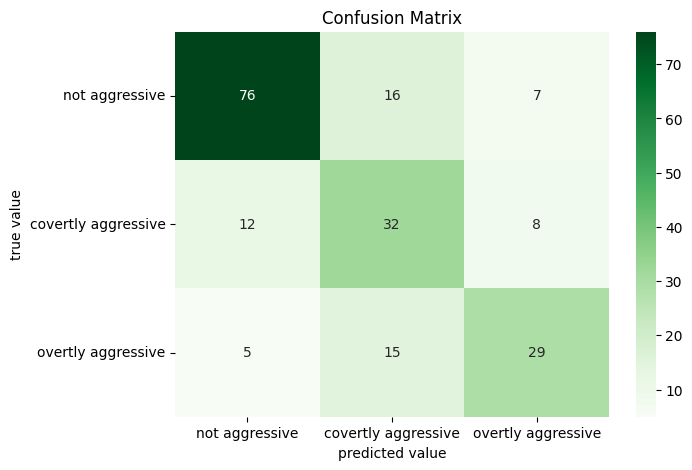

In [ ]:

y_true = d1_test.loc[:, 'label']
X_test = pd.DataFrame(d1_test.apply(generate_test_prompt, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d1_test aggression prediction  without cyber bullying")
evaluate(y_true, y_pred)

In [ ]:

def generate_test_prompt_cyb_detail_v1(row):
    confidence = row['confidence_cyb']
    cyb_type = row['predictions_cyb']

    if confidence >= 0.75:
        if cyb_type == 'not_cyberbullying':
            aux_info = f"Cyberbullying classifier: not cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'other_cyberbullying':
            aux_info = f"Cyberbullying classifier: other cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'age':
            aux_info = f"Cyberbullying classifier: age-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'religion':
            aux_info = f"Cyberbullying classifier: religion-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'ethnicity':
            aux_info = f"Cyberbullying classifier: ethnicity-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'gender':
            aux_info = f"Cyberbullying classifier: gender-related cyberbullying (confidence: {confidence:.2f})"
        else:
            aux_info = "Not provided"
    else:
        aux_info = "Not provided"

    return f"""You are a strict Aggression classifier.
Analyze the text and classify it into exactly one category:

The possible categories are:
- not aggressive: neutral or non-hostile statements
- covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks, subtle put-downs
- overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility

TEXT: "{row['text']}"

Auxiliary information: {aux_info}

CLASSIFICATION: """.strip()

  0%|          | 1/200 [00:00<01:31,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 2/200 [00:00<01:30,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 3/200 [00:01<01:42,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 4/200 [00:02<01:47,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▎         | 5/200 [00:02<01:50,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 6/200 [00:03<01:52,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▎         | 7/200 [00:03<01:43,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 8/200 [00:04<01:46,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 9/200 [00:04<01:40,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 10/200 [00:05<01:35,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 11/200 [00:05<01:40,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 12/200 [00:06<01:43,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▋         | 13/200 [00:07<01:44,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 14/200 [00:07<01:39,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 15/200 [00:08<01:42,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 16/200 [00:08<01:43,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 17/200 [00:09<01:36,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 18/200 [00:09<01:32,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 19/200 [00:10<01:35,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 20/200 [00:10<01:30,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|█         | 21/200 [00:11<01:27,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 22/200 [00:11<01:32,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 23/200 [00:12<01:28,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 24/200 [00:12<01:32,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▎        | 25/200 [00:13<01:28,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 26/200 [00:13<01:32,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▎        | 27/200 [00:14<01:28,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 28/200 [00:14<01:32,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 29/200 [00:15<01:34,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▌        | 30/200 [00:15<01:29,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 31/200 [00:16<01:25,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 32/200 [00:16<01:22,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 33/200 [00:17<01:27,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 34/200 [00:17<01:23,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 35/200 [00:18<01:28,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 36/200 [00:19<01:31,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 37/200 [00:19<01:32,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 38/200 [00:20<01:26,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 39/200 [00:20<01:28,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 40/200 [00:21<01:30,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 41/200 [00:21<01:32,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 42/200 [00:22<01:32,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 43/200 [00:23<01:32,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 44/200 [00:23<01:32,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▎       | 45/200 [00:24<01:31,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 46/200 [00:24<01:31,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▎       | 47/200 [00:25<01:25,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 48/200 [00:25<01:26,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 49/200 [00:26<01:20,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 50/200 [00:27<01:22,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 51/200 [00:27<01:17,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 52/200 [00:27<01:14,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▋       | 53/200 [00:28<01:18,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 54/200 [00:29<01:20,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 55/200 [00:29<01:21,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 56/200 [00:30<01:16,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 57/200 [00:30<01:19,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 58/200 [00:31<01:20,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|██▉       | 59/200 [00:31<01:21,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 60/200 [00:32<01:16,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 61/200 [00:32<01:12,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 62/200 [00:33<01:10,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 63/200 [00:33<01:07,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 64/200 [00:34<01:05,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▎      | 65/200 [00:34<01:09,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 66/200 [00:35<01:07,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 67/200 [00:35<01:04,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 68/200 [00:36<01:02,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 69/200 [00:36<01:01,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 70/200 [00:37<01:00,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 71/200 [00:37<01:05,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 72/200 [00:38<01:02,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▋      | 73/200 [00:38<01:05,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 74/200 [00:39<01:02,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 75/200 [00:39<01:01,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 76/200 [00:40<01:04,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 77/200 [00:40<01:07,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 39%|███▉      | 78/200 [00:41<01:08,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|███▉      | 79/200 [00:42<01:09,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 80/200 [00:42<01:04,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 81/200 [00:43<01:00,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 82/200 [00:43<01:03,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 83/200 [00:44<01:05,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 84/200 [00:44<01:06,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▎     | 85/200 [00:45<01:07,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 86/200 [00:46<01:06,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▎     | 87/200 [00:46<01:06,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 88/200 [00:47<01:01,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 89/200 [00:47<00:57,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 90/200 [00:48<00:54,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 91/200 [00:48<00:53,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 92/200 [00:48<00:51,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 93/200 [00:49<00:55,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 94/200 [00:49<00:52,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 95/200 [00:50<00:54,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 96/200 [00:51<00:56,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 97/200 [00:51<00:52,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 98/200 [00:52<00:50,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 99/200 [00:52<00:48,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 100/200 [00:52<00:47,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 101/200 [00:53<00:46,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 102/200 [00:54<00:49,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 103/200 [00:54<00:52,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 104/200 [00:55<00:49,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▎    | 105/200 [00:55<00:47,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 106/200 [00:56<00:45,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 107/200 [00:56<00:44,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 108/200 [00:56<00:43,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 109/200 [00:57<00:42,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 110/200 [00:57<00:41,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 111/200 [00:58<00:44,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 112/200 [00:58<00:42,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 113/200 [00:59<00:45,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 114/200 [01:00<00:46,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▊    | 115/200 [01:00<00:43,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 116/200 [01:01<00:44,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 117/200 [01:01<00:45,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 118/200 [01:02<00:43,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 119/200 [01:02<00:44,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 120/200 [01:03<00:45,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 121/200 [01:03<00:41,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 122/200 [01:04<00:39,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 123/200 [01:04<00:37,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 124/200 [01:05<00:36,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▎   | 125/200 [01:05<00:35,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 126/200 [01:06<00:34,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▎   | 127/200 [01:06<00:33,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 128/200 [01:07<00:36,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 129/200 [01:07<00:37,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▌   | 130/200 [01:08<00:38,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 131/200 [01:08<00:35,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 132/200 [01:09<00:36,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▋   | 133/200 [01:09<00:34,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 134/200 [01:10<00:33,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 135/200 [01:10<00:34,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 136/200 [01:11<00:34,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 137/200 [01:11<00:32,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 138/200 [01:12<00:30,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|██████▉   | 139/200 [01:12<00:29,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 140/200 [01:13<00:28,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 141/200 [01:13<00:30,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 142/200 [01:14<00:31,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 143/200 [01:14<00:29,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 144/200 [01:15<00:31,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▎  | 145/200 [01:16<00:29,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 146/200 [01:16<00:29,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▎  | 147/200 [01:17<00:27,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 148/200 [01:17<00:28,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 149/200 [01:18<00:28,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 150/200 [01:18<00:28,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 151/200 [01:19<00:26,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 152/200 [01:19<00:26,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▋  | 153/200 [01:20<00:24,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 154/200 [01:20<00:23,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 155/200 [01:21<00:22,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 156/200 [01:21<00:23,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 157/200 [01:22<00:23,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 158/200 [01:23<00:21,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 159/200 [01:23<00:22,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|████████  | 160/200 [01:24<00:22,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 161/200 [01:24<00:22,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 162/200 [01:25<00:20,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 163/200 [01:25<00:20,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 164/200 [01:26<00:20,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▎ | 165/200 [01:26<00:18,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 166/200 [01:27<00:17,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 167/200 [01:27<00:17,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 168/200 [01:28<00:17,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 169/200 [01:29<00:17,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 170/200 [01:29<00:17,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 171/200 [01:30<00:16,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 172/200 [01:30<00:16,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 173/200 [01:31<00:15,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 174/200 [01:32<00:15,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 175/200 [01:32<00:14,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 176/200 [01:33<00:13,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 177/200 [01:33<00:13,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 178/200 [01:34<00:12,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 179/200 [01:34<00:11,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 180/200 [01:35<00:10,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 181/200 [01:35<00:09,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 182/200 [01:36<00:08,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 183/200 [01:36<00:08,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 184/200 [01:37<00:08,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▎| 185/200 [01:37<00:07,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 186/200 [01:38<00:07,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▎| 187/200 [01:38<00:06,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 188/200 [01:39<00:06,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▍| 189/200 [01:39<00:05,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 190/200 [01:40<00:05,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 191/200 [01:41<00:04,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 192/200 [01:41<00:04,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▋| 193/200 [01:42<00:03,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 97%|█████████▋| 194/200 [01:42<00:03,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 195/200 [01:43<00:02,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 196/200 [01:44<00:02,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 197/200 [01:44<00:01,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 198/200 [01:45<00:01,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|█████████▉| 199/200 [01:45<00:00,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|██████████| 200/200 [01:46<00:00,  1.88it/s]

Predicted answer: not aggressive
d1_test aggression prediction  with cyber bullying
Accuracy: 0.715
Accuracy for label not aggressive: 0.798
Accuracy for label covertly aggressive: 0.596
Accuracy for label overtly aggressive: 0.673

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.83      0.80      0.81        99
covertly aggressive       0.54      0.60      0.57        52
 overtly aggressive       0.69      0.67      0.68        49

           accuracy                           0.71       200
          macro avg       0.69      0.69      0.69       200
       weighted avg       0.72      0.71      0.72       200


Confusion Matrix:
[[79 14  6]
 [12 31  9]
 [ 4 12 33]]


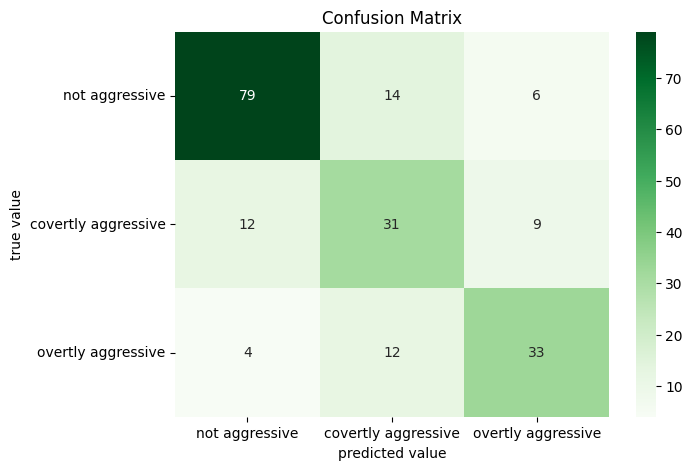

In [ ]:
# Generate test prompts and extract true labels
y_true = d1_test.loc[:, 'label']
X_test = pd.DataFrame(d1_test.apply(generate_test_prompt_cyb_detail_v1, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d1_test aggression prediction  with cyber bullying")
evaluate(y_true, y_pred)

  0%|          | 1/777 [00:00<07:25,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 2/777 [00:01<07:33,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 3/777 [00:01<06:43,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 4/777 [00:02<06:15,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 5/777 [00:02<06:37,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 6/777 [00:03<06:15,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 7/777 [00:03<06:35,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 8/777 [00:04<06:55,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 9/777 [00:04<07:04,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|▏         | 10/777 [00:05<06:36,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|▏         | 11/777 [00:05<06:17,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 12/777 [00:06<06:36,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 13/777 [00:06<06:21,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 14/777 [00:07<06:37,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 15/777 [00:07<06:18,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 16/777 [00:08<06:44,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 17/777 [00:08<06:57,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 18/777 [00:09<07:05,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 19/777 [00:09<06:37,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 20/777 [00:10<06:15,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 21/777 [00:10<06:36,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 22/777 [00:11<06:47,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 23/777 [00:12<06:53,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 24/777 [00:12<06:29,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 25/777 [00:12<06:12,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 26/777 [00:13<06:00,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 27/777 [00:13<05:53,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▎         | 28/777 [00:14<06:16,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▎         | 29/777 [00:14<06:04,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 30/777 [00:15<06:24,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▍         | 31/777 [00:15<06:09,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 32/777 [00:16<05:57,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 33/777 [00:16<05:48,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 34/777 [00:17<05:42,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 35/777 [00:17<06:09,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▍         | 36/777 [00:18<05:54,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 37/777 [00:18<06:18,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 38/777 [00:19<06:02,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 39/777 [00:19<06:20,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 40/777 [00:20<06:04,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 41/777 [00:20<06:23,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▌         | 42/777 [00:21<06:05,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 43/777 [00:21<06:31,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 44/777 [00:22<06:44,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 45/777 [00:23<06:51,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 46/777 [00:23<06:56,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 47/777 [00:24<06:57,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 48/777 [00:24<06:29,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 49/777 [00:25<06:11,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 50/777 [00:25<05:59,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 51/777 [00:26<06:22,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 52/777 [00:26<06:37,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 53/777 [00:27<06:47,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 54/777 [00:28<06:55,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 55/777 [00:28<06:59,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 56/777 [00:29<07:07,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 57/777 [00:29<07:10,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 58/777 [00:30<06:37,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 59/777 [00:30<06:15,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 60/777 [00:31<05:58,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 61/777 [00:31<06:14,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 62/777 [00:32<06:25,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 63/777 [00:32<06:07,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 64/777 [00:33<05:52,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 65/777 [00:33<05:41,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 66/777 [00:34<06:02,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▊         | 67/777 [00:34<05:48,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 68/777 [00:35<05:39,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 69/777 [00:35<05:37,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 70/777 [00:36<05:32,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 71/777 [00:36<05:55,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 72/777 [00:37<05:45,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 73/777 [00:37<05:39,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 74/777 [00:38<05:34,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 75/777 [00:38<05:30,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 76/777 [00:39<05:26,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 77/777 [00:39<05:22,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|█         | 78/777 [00:40<05:56,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 79/777 [00:40<05:43,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|█         | 80/777 [00:41<06:04,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 81/777 [00:41<06:22,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 82/777 [00:42<06:29,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 83/777 [00:42<06:06,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 84/777 [00:43<05:48,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 85/777 [00:43<06:04,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 86/777 [00:44<05:47,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 87/777 [00:44<06:02,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█▏        | 88/777 [00:45<05:45,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█▏        | 89/777 [00:45<06:03,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 90/777 [00:46<06:15,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 91/777 [00:47<06:24,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 92/777 [00:47<06:29,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 93/777 [00:48<06:31,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 94/777 [00:48<06:34,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 95/777 [00:49<06:34,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 96/777 [00:49<06:34,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 97/777 [00:50<06:36,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 98/777 [00:51<06:10,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 99/777 [00:51<05:50,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 100/777 [00:52<06:03,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 101/777 [00:52<05:44,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 102/777 [00:52<05:34,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 103/777 [00:53<05:57,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 104/777 [00:54<05:40,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 105/777 [00:54<05:28,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 106/777 [00:55<05:47,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 107/777 [00:55<05:31,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 108/777 [00:55<05:22,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 109/777 [00:56<05:16,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 110/777 [00:57<05:38,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 111/777 [00:57<05:53,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 112/777 [00:58<06:03,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 113/777 [00:58<06:11,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 114/777 [00:59<06:21,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 115/777 [00:59<05:56,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 116/777 [01:00<06:05,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 117/777 [01:01<06:11,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▌        | 118/777 [01:01<05:48,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 119/777 [01:01<05:30,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 120/777 [01:02<05:18,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 121/777 [01:02<05:08,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 122/777 [01:03<05:28,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 123/777 [01:03<05:43,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 124/777 [01:04<05:25,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 125/777 [01:04<05:41,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 126/777 [01:05<05:24,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 127/777 [01:05<05:11,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 128/777 [01:06<05:29,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 129/777 [01:06<05:44,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 130/777 [01:07<05:28,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 131/777 [01:07<05:18,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 132/777 [01:08<05:08,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 133/777 [01:08<05:02,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 134/777 [01:09<05:25,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 135/777 [01:09<05:17,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 136/777 [01:10<05:35,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 137/777 [01:10<05:21,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 138/777 [01:11<05:10,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 139/777 [01:11<05:04,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 140/777 [01:12<05:24,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 141/777 [01:12<05:12,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 142/777 [01:13<05:29,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 143/777 [01:13<05:15,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▊        | 144/777 [01:14<05:06,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▊        | 145/777 [01:14<05:26,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 146/777 [01:15<05:40,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 147/777 [01:15<05:24,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 148/777 [01:16<05:13,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 149/777 [01:17<05:29,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 150/777 [01:17<05:12,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 151/777 [01:17<05:03,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 152/777 [01:18<04:56,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 153/777 [01:18<05:19,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 154/777 [01:19<05:33,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 155/777 [01:20<05:18,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 156/777 [01:20<05:33,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 157/777 [01:21<05:45,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 158/777 [01:21<05:25,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 159/777 [01:22<05:38,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 160/777 [01:22<05:22,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 161/777 [01:23<05:08,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 162/777 [01:23<05:23,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██        | 163/777 [01:24<05:08,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 164/777 [01:24<04:57,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 165/777 [01:25<05:15,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██▏       | 166/777 [01:25<05:29,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██▏       | 167/777 [01:26<05:36,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 168/777 [01:26<05:41,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 169/777 [01:27<05:20,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 170/777 [01:28<05:30,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 171/777 [01:28<05:39,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 172/777 [01:29<05:17,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 173/777 [01:29<05:02,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 174/777 [01:30<05:15,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 175/777 [01:30<05:01,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 176/777 [01:30<04:51,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 177/777 [01:31<05:12,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 178/777 [01:32<04:59,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 179/777 [01:32<04:49,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 180/777 [01:32<04:45,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 181/777 [01:33<05:04,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 182/777 [01:33<04:52,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 183/777 [01:34<04:44,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 184/777 [01:35<05:03,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 185/777 [01:35<05:18,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 186/777 [01:36<05:07,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 187/777 [01:36<04:55,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 188/777 [01:37<04:46,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 189/777 [01:37<04:39,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 190/777 [01:37<04:34,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 191/777 [01:38<04:33,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 192/777 [01:38<05:00,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 193/777 [01:39<04:48,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 194/777 [01:39<04:39,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 195/777 [01:40<04:34,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 196/777 [01:40<04:55,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 197/777 [01:41<05:12,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▌       | 198/777 [01:41<04:57,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 199/777 [01:42<05:09,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 200/777 [01:43<05:17,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 201/777 [01:43<05:03,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 202/777 [01:44<05:15,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 203/777 [01:44<04:57,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▋       | 204/777 [01:45<05:07,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▋       | 205/777 [01:45<05:15,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 206/777 [01:46<05:20,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 207/777 [01:47<05:24,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 208/777 [01:47<05:03,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 209/777 [01:47<04:46,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 210/777 [01:48<04:58,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 211/777 [01:48<04:45,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 212/777 [01:49<04:58,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 213/777 [01:49<04:47,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 214/777 [01:50<04:37,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 215/777 [01:50<04:35,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 216/777 [01:51<04:52,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 217/777 [01:51<04:39,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 218/777 [01:52<04:29,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 219/777 [01:53<04:46,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 220/777 [01:53<04:35,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 221/777 [01:53<04:27,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 222/777 [01:54<04:22,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 223/777 [01:54<04:19,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 224/777 [01:55<04:39,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 225/777 [01:55<04:30,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 226/777 [01:56<04:23,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 227/777 [01:56<04:19,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 228/777 [01:57<04:37,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 229/777 [01:57<04:28,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 230/777 [01:58<04:44,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|██▉       | 231/777 [01:58<04:36,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 232/777 [01:59<04:27,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 233/777 [01:59<04:22,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 234/777 [02:00<04:39,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 235/777 [02:00<04:28,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 236/777 [02:01<04:18,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 237/777 [02:01<04:33,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 238/777 [02:02<04:43,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 239/777 [02:02<04:30,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 240/777 [02:03<04:45,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 241/777 [02:04<04:56,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 242/777 [02:04<05:02,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███▏      | 243/777 [02:05<05:05,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███▏      | 244/777 [02:05<05:11,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 245/777 [02:06<05:11,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 246/777 [02:07<05:14,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 247/777 [02:07<05:12,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 248/777 [02:08<04:48,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 249/777 [02:08<04:31,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 250/777 [02:09<04:41,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 251/777 [02:09<04:49,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 252/777 [02:10<04:54,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 253/777 [02:10<04:58,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 254/777 [02:11<04:59,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 255/777 [02:11<04:39,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 256/777 [02:12<04:45,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 257/777 [02:12<04:29,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 258/777 [02:13<04:18,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 259/777 [02:13<04:32,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 260/777 [02:14<04:20,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 261/777 [02:15<04:33,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▎      | 262/777 [02:15<04:21,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 263/777 [02:16<04:33,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 264/777 [02:16<04:41,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 265/777 [02:17<04:25,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 266/777 [02:17<04:36,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 267/777 [02:18<04:43,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 268/777 [02:18<04:50,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 269/777 [02:19<04:52,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 270/777 [02:19<04:34,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 271/777 [02:20<04:40,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 272/777 [02:20<04:25,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 273/777 [02:21<04:38,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 274/777 [02:22<04:44,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 275/777 [02:22<04:27,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 276/777 [02:23<04:15,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 277/777 [02:23<04:28,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 278/777 [02:24<04:34,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 279/777 [02:24<04:22,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 280/777 [02:25<04:30,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 281/777 [02:25<04:15,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▋      | 282/777 [02:26<04:25,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▋      | 283/777 [02:26<04:38,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 284/777 [02:27<04:41,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 285/777 [02:28<04:45,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 286/777 [02:28<04:48,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 287/777 [02:29<04:49,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 288/777 [02:29<04:48,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 289/777 [02:30<04:48,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 290/777 [02:31<04:30,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 291/777 [02:31<04:15,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 292/777 [02:32<04:26,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 293/777 [02:32<04:32,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 294/777 [02:33<04:15,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 295/777 [02:33<04:25,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 296/777 [02:34<04:31,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 297/777 [02:34<04:18,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 298/777 [02:35<04:24,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 299/777 [02:35<04:11,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▊      | 300/777 [02:36<04:00,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▊      | 301/777 [02:36<03:56,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 302/777 [02:37<03:49,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 303/777 [02:37<03:45,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 304/777 [02:38<03:41,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 305/777 [02:38<03:59,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 39%|███▉      | 306/777 [02:39<04:10,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 307/777 [02:39<04:18,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|███▉      | 308/777 [02:40<04:23,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 309/777 [02:40<04:06,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 310/777 [02:41<04:14,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|████      | 311/777 [02:42<04:01,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 312/777 [02:42<03:52,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 313/777 [02:43<04:04,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 314/777 [02:43<04:13,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 315/777 [02:44<04:18,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 316/777 [02:44<04:02,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 317/777 [02:45<04:09,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 318/777 [02:45<03:57,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 319/777 [02:46<04:06,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 320/777 [02:46<03:54,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 321/777 [02:47<03:44,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 322/777 [02:47<04:00,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 323/777 [02:48<03:49,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 324/777 [02:48<03:40,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 325/777 [02:49<03:34,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 326/777 [02:49<03:48,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 327/777 [02:50<03:58,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 328/777 [02:50<03:48,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 329/777 [02:51<03:38,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 330/777 [02:51<03:34,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 331/777 [02:52<03:48,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 332/777 [02:52<03:39,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 333/777 [02:53<03:51,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 334/777 [02:53<04:00,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 335/777 [02:54<03:48,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 336/777 [02:54<03:38,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 337/777 [02:55<03:48,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▎     | 338/777 [02:55<03:56,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▎     | 339/777 [02:56<04:00,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 340/777 [02:57<04:05,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 341/777 [02:57<03:51,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 342/777 [02:58<03:59,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 343/777 [02:58<04:03,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 344/777 [02:59<03:49,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 345/777 [02:59<03:59,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 346/777 [03:00<03:45,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 347/777 [03:00<03:35,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 348/777 [03:01<03:46,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 349/777 [03:01<03:52,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▌     | 350/777 [03:02<03:40,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 351/777 [03:02<03:33,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 352/777 [03:03<03:46,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 353/777 [03:04<03:53,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 354/777 [03:04<04:00,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 355/777 [03:05<03:44,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 356/777 [03:05<03:50,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 357/777 [03:06<03:53,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 358/777 [03:06<03:57,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 359/777 [03:07<03:42,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 360/777 [03:07<03:33,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 361/777 [03:08<03:25,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 362/777 [03:08<03:36,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 363/777 [03:09<03:27,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 364/777 [03:09<03:20,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 365/777 [03:10<03:30,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 366/777 [03:10<03:43,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 367/777 [03:11<03:31,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 368/777 [03:11<03:41,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 369/777 [03:12<03:46,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 370/777 [03:13<03:49,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 371/777 [03:13<03:34,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 372/777 [03:14<03:24,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 373/777 [03:14<03:33,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 374/777 [03:15<03:24,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 375/777 [03:15<03:37,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 376/777 [03:16<03:42,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▊     | 377/777 [03:16<03:29,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▊     | 378/777 [03:17<03:37,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 379/777 [03:17<03:44,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 380/777 [03:18<03:30,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 381/777 [03:18<03:19,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 382/777 [03:19<03:12,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 383/777 [03:19<03:26,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 384/777 [03:20<03:35,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 385/777 [03:20<03:26,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 386/777 [03:21<03:32,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 387/777 [03:21<03:21,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 388/777 [03:22<03:13,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 389/777 [03:23<03:23,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|█████     | 390/777 [03:23<03:14,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 391/777 [03:23<03:06,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 392/777 [03:24<03:16,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 393/777 [03:24<03:07,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 394/777 [03:25<03:16,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 395/777 [03:25<03:08,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 396/777 [03:26<03:06,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 397/777 [03:26<03:02,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 398/777 [03:27<03:16,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████▏    | 399/777 [03:28<03:24,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████▏    | 400/777 [03:28<03:31,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 401/777 [03:29<03:18,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 402/777 [03:29<03:26,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 403/777 [03:30<03:14,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 404/777 [03:30<03:22,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 405/777 [03:31<03:11,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 406/777 [03:31<03:03,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 407/777 [03:32<02:58,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 408/777 [03:32<02:55,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 409/777 [03:33<03:08,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 410/777 [03:33<03:01,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 411/777 [03:34<03:10,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 412/777 [03:34<03:18,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 413/777 [03:35<03:22,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 414/777 [03:35<03:11,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 415/777 [03:36<03:20,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▎    | 416/777 [03:36<03:08,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 417/777 [03:37<03:00,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 418/777 [03:37<02:55,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 419/777 [03:38<03:05,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 420/777 [03:39<03:15,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 421/777 [03:39<03:18,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 422/777 [03:40<03:20,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 423/777 [03:40<03:25,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▍    | 424/777 [03:41<03:25,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 425/777 [03:41<03:24,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▍    | 426/777 [03:42<03:24,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▍    | 427/777 [03:43<03:10,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 428/777 [03:43<03:16,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 429/777 [03:44<03:19,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 430/777 [03:44<03:19,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 431/777 [03:45<03:18,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 432/777 [03:45<03:04,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 433/777 [03:46<02:54,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 434/777 [03:46<03:03,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 435/777 [03:47<02:53,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 436/777 [03:47<02:46,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 437/777 [03:48<02:42,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 438/777 [03:48<02:39,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 439/777 [03:49<02:50,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 440/777 [03:49<02:57,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 441/777 [03:50<03:01,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 442/777 [03:51<03:08,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 443/777 [03:51<02:57,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 444/777 [03:52<03:03,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 445/777 [03:52<03:07,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 446/777 [03:53<03:09,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 447/777 [03:53<02:56,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 448/777 [03:54<03:02,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 449/777 [03:54<02:51,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 450/777 [03:55<02:43,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 451/777 [03:55<02:37,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 452/777 [03:56<02:48,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 453/777 [03:56<02:42,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 454/777 [03:57<02:53,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▊    | 455/777 [03:57<02:45,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▊    | 456/777 [03:58<02:38,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 457/777 [03:58<02:36,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 458/777 [03:59<02:36,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 459/777 [03:59<02:46,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 460/777 [04:00<02:42,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 461/777 [04:00<02:37,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 462/777 [04:01<02:46,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|█████▉    | 463/777 [04:01<02:51,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 464/777 [04:02<02:55,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 465/777 [04:03<02:57,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 466/777 [04:03<02:45,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 467/777 [04:04<02:36,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 468/777 [04:04<02:43,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 469/777 [04:05<02:47,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|██████    | 470/777 [04:05<02:52,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 471/777 [04:06<02:41,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 472/777 [04:06<02:48,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 473/777 [04:07<02:52,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████    | 474/777 [04:08<02:53,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 475/777 [04:08<02:56,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████▏   | 476/777 [04:09<02:44,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████▏   | 477/777 [04:09<02:36,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 478/777 [04:10<02:29,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 479/777 [04:10<02:37,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 480/777 [04:11<02:29,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 481/777 [04:11<02:36,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 482/777 [04:12<02:28,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 483/777 [04:12<02:24,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 484/777 [04:13<02:32,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 485/777 [04:13<02:38,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 486/777 [04:14<02:29,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 487/777 [04:14<02:23,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 488/777 [04:15<02:30,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 489/777 [04:15<02:23,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 490/777 [04:16<02:19,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 491/777 [04:16<02:16,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 492/777 [04:17<02:14,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 493/777 [04:17<02:24,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▎   | 494/777 [04:18<02:31,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▎   | 495/777 [04:18<02:36,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 496/777 [04:19<02:38,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 497/777 [04:19<02:40,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 498/777 [04:20<02:29,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 499/777 [04:20<02:22,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 500/777 [04:21<02:17,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 501/777 [04:21<02:14,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 502/777 [04:22<02:22,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 503/777 [04:22<02:16,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 504/777 [04:23<02:12,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 505/777 [04:23<02:10,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 506/777 [04:24<02:07,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 507/777 [04:24<02:06,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 508/777 [04:25<02:03,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 509/777 [04:25<02:14,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 510/777 [04:26<02:10,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 511/777 [04:26<02:18,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 512/777 [04:27<02:12,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 513/777 [04:27<02:09,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 514/777 [04:28<02:05,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 515/777 [04:28<02:14,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▋   | 516/777 [04:29<02:09,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 517/777 [04:29<02:06,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 518/777 [04:30<02:03,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 519/777 [04:30<02:00,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 520/777 [04:31<02:10,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 521/777 [04:31<02:15,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 522/777 [04:32<02:08,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 523/777 [04:32<02:14,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 524/777 [04:33<02:17,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 525/777 [04:33<02:20,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 526/777 [04:34<02:21,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 527/777 [04:35<02:22,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 528/777 [04:35<02:12,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 529/777 [04:36<02:06,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 530/777 [04:36<02:11,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 531/777 [04:37<02:15,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 532/777 [04:37<02:07,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 533/777 [04:38<02:11,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▊   | 534/777 [04:38<02:04,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 535/777 [04:39<01:58,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 536/777 [04:39<02:05,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▉   | 537/777 [04:40<01:59,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 538/777 [04:40<02:05,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▉   | 539/777 [04:41<01:58,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 540/777 [04:41<02:04,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 541/777 [04:42<02:07,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 542/777 [04:42<02:00,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|██████▉   | 543/777 [04:43<02:04,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 544/777 [04:43<01:58,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 545/777 [04:44<02:03,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 546/777 [04:45<02:07,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 547/777 [04:45<02:09,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 548/777 [04:46<02:12,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 549/777 [04:46<02:12,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 550/777 [04:47<02:02,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 551/777 [04:47<01:57,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 552/777 [04:48<02:01,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 553/777 [04:48<02:03,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████▏  | 554/777 [04:49<02:05,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████▏  | 555/777 [04:49<01:57,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 556/777 [04:50<02:01,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 557/777 [04:51<02:02,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 558/777 [04:51<01:54,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 559/777 [04:51<01:49,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 560/777 [04:52<01:55,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 561/777 [04:53<01:58,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 562/777 [04:53<01:51,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 563/777 [04:54<01:46,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 564/777 [04:54<01:51,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 565/777 [04:55<01:45,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 566/777 [04:55<01:42,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 567/777 [04:56<01:40,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 568/777 [04:56<01:38,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 569/777 [04:57<01:44,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 73%|███████▎  | 570/777 [04:57<01:48,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 571/777 [04:58<01:51,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▎  | 572/777 [04:58<01:53,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▎  | 573/777 [04:59<01:46,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 574/777 [04:59<01:40,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 575/777 [05:00<01:46,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 576/777 [05:00<01:41,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 577/777 [05:01<01:45,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 578/777 [05:01<01:50,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▍  | 579/777 [05:02<01:43,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▍  | 580/777 [05:02<01:38,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▍  | 581/777 [05:03<01:43,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 582/777 [05:03<01:46,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 583/777 [05:04<01:39,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 584/777 [05:04<01:35,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 585/777 [05:05<01:39,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▌  | 586/777 [05:05<01:35,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 587/777 [05:06<01:39,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 588/777 [05:06<01:34,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 589/777 [05:07<01:38,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 590/777 [05:08<01:40,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 591/777 [05:08<01:42,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 592/777 [05:09<01:43,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▋  | 593/777 [05:09<01:36,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▋  | 594/777 [05:10<01:31,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 595/777 [05:10<01:35,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 596/777 [05:11<01:38,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 597/777 [05:11<01:33,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 598/777 [05:12<01:36,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 599/777 [05:12<01:38,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 600/777 [05:13<01:32,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 601/777 [05:13<01:27,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 602/777 [05:14<01:31,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 603/777 [05:14<01:27,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 604/777 [05:15<01:31,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 605/777 [05:16<01:34,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 606/777 [05:16<01:35,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 607/777 [05:17<01:29,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 608/777 [05:17<01:24,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 609/777 [05:17<01:21,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▊  | 610/777 [05:18<01:18,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▊  | 611/777 [05:19<01:23,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 612/777 [05:19<01:20,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 613/777 [05:19<01:18,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 614/777 [05:20<01:16,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 615/777 [05:20<01:15,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 616/777 [05:21<01:14,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 617/777 [05:21<01:14,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 618/777 [05:22<01:13,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 619/777 [05:22<01:12,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 620/777 [05:23<01:11,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 621/777 [05:23<01:11,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 622/777 [05:24<01:17,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 623/777 [05:24<01:20,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 624/777 [05:25<01:16,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 625/777 [05:25<01:19,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 626/777 [05:26<01:15,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 627/777 [05:26<01:12,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 628/777 [05:27<01:10,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 629/777 [05:27<01:09,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 630/777 [05:28<01:07,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 631/777 [05:28<01:12,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████▏ | 632/777 [05:29<01:16,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████▏ | 633/777 [05:29<01:12,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 634/777 [05:30<01:09,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 635/777 [05:30<01:07,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 636/777 [05:30<01:05,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 637/777 [05:31<01:10,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 638/777 [05:32<01:12,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 639/777 [05:32<01:15,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 640/777 [05:33<01:16,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 641/777 [05:33<01:11,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 642/777 [05:34<01:14,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 643/777 [05:34<01:09,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 644/777 [05:35<01:05,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 645/777 [05:35<01:03,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 646/777 [05:36<01:07,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 647/777 [05:36<01:09,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 648/777 [05:37<01:05,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 649/777 [05:37<01:07,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▎ | 650/777 [05:38<01:09,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 651/777 [05:39<01:10,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 652/777 [05:39<01:10,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 653/777 [05:40<01:10,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 654/777 [05:40<01:05,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 655/777 [05:41<01:06,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 656/777 [05:41<01:02,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 657/777 [05:42<01:04,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▍ | 658/777 [05:42<01:00,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 659/777 [05:43<01:03,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 660/777 [05:43<01:04,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 661/777 [05:44<01:00,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 662/777 [05:44<01:02,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 663/777 [05:45<01:03,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 664/777 [05:46<00:59,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 665/777 [05:46<01:01,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 666/777 [05:47<00:57,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 667/777 [05:47<00:55,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 668/777 [05:48<00:58,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 669/777 [05:48<00:56,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 670/777 [05:49<00:53,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▋ | 671/777 [05:49<00:55,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▋ | 672/777 [05:50<00:52,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 673/777 [05:50<00:54,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 674/777 [05:51<00:51,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 675/777 [05:51<00:54,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 676/777 [05:52<00:55,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 677/777 [05:52<00:51,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 678/777 [05:53<00:53,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 679/777 [05:53<00:54,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 680/777 [05:54<00:50,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 681/777 [05:55<00:52,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 682/777 [05:55<00:49,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 683/777 [05:55<00:47,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 684/777 [05:56<00:45,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 685/777 [05:56<00:44,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 686/777 [05:57<00:46,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 687/777 [05:57<00:48,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 89%|████████▊ | 688/777 [05:58<00:45,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▊ | 689/777 [05:59<00:46,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 690/777 [05:59<00:43,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 691/777 [06:00<00:45,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 692/777 [06:00<00:46,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 693/777 [06:01<00:47,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 89%|████████▉ | 694/777 [06:01<00:43,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 695/777 [06:02<00:41,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 696/777 [06:02<00:39,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 697/777 [06:03<00:41,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 698/777 [06:03<00:42,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|████████▉ | 699/777 [06:04<00:43,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|█████████ | 700/777 [06:04<00:40,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 701/777 [06:05<00:38,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 702/777 [06:05<00:40,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 703/777 [06:06<00:41,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 704/777 [06:06<00:38,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 705/777 [06:07<00:39,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 706/777 [06:08<00:39,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 707/777 [06:08<00:36,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 708/777 [06:09<00:35,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 709/777 [06:09<00:36,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████▏| 710/777 [06:10<00:36,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 711/777 [06:10<00:33,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 712/777 [06:11<00:32,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 713/777 [06:11<00:33,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 714/777 [06:12<00:31,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 715/777 [06:12<00:32,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 716/777 [06:13<00:30,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 717/777 [06:13<00:32,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 718/777 [06:14<00:32,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 719/777 [06:14<00:30,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 720/777 [06:15<00:28,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 721/777 [06:15<00:29,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 722/777 [06:16<00:30,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 723/777 [06:17<00:30,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 724/777 [06:17<00:30,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 725/777 [06:18<00:30,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 726/777 [06:18<00:27,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 727/777 [06:19<00:25,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 728/777 [06:19<00:24,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 729/777 [06:20<00:23,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 730/777 [06:20<00:22,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 731/777 [06:21<00:23,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 732/777 [06:21<00:23,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 733/777 [06:22<00:22,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 734/777 [06:22<00:22,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▍| 735/777 [06:23<00:21,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 736/777 [06:23<00:22,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▍| 737/777 [06:24<00:20,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 738/777 [06:24<00:19,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 739/777 [06:25<00:18,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 740/777 [06:25<00:19,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▌| 741/777 [06:26<00:19,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 742/777 [06:26<00:19,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 743/777 [06:27<00:17,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 744/777 [06:27<00:17,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▌| 745/777 [06:28<00:16,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 746/777 [06:28<00:15,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 747/777 [06:29<00:14,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 748/777 [06:29<00:15,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▋| 749/777 [06:30<00:13,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 750/777 [06:30<00:13,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 751/777 [06:31<00:12,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 752/777 [06:31<00:12,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 753/777 [06:32<00:12,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 97%|█████████▋| 754/777 [06:33<00:12,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 97%|█████████▋| 755/777 [06:33<00:12,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 756/777 [06:34<00:11,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 757/777 [06:34<00:10,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 758/777 [06:35<00:09,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 759/777 [06:35<00:08,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 760/777 [06:35<00:08,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 761/777 [06:36<00:08,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 762/777 [06:36<00:07,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 763/777 [06:37<00:06,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 764/777 [06:37<00:06,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 765/777 [06:38<00:06,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 766/777 [06:39<00:05,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 767/777 [06:39<00:05,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 768/777 [06:40<00:04,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 769/777 [06:40<00:04,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 770/777 [06:41<00:03,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 771/777 [06:41<00:02,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 772/777 [06:42<00:02,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 773/777 [06:42<00:02,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 774/777 [06:43<00:01,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 775/777 [06:43<00:01,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|█████████▉| 776/777 [06:44<00:00,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|██████████| 777/777 [06:45<00:00,  1.92it/s]

Predicted answer: covertly aggressive
d2_test aggression prediction  without cyber bullying
Accuracy: 0.598
Accuracy for label not aggressive: 0.779
Accuracy for label covertly aggressive: 0.390
Accuracy for label overtly aggressive: 0.509

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.74      0.78      0.76       367
covertly aggressive       0.46      0.39      0.42       251
 overtly aggressive       0.47      0.51      0.49       159

           accuracy                           0.60       777
          macro avg       0.55      0.56      0.55       777
       weighted avg       0.59      0.60      0.59       777


Confusion Matrix:
[[286  61  20]
 [ 80  98  73]
 [ 22  56  81]]


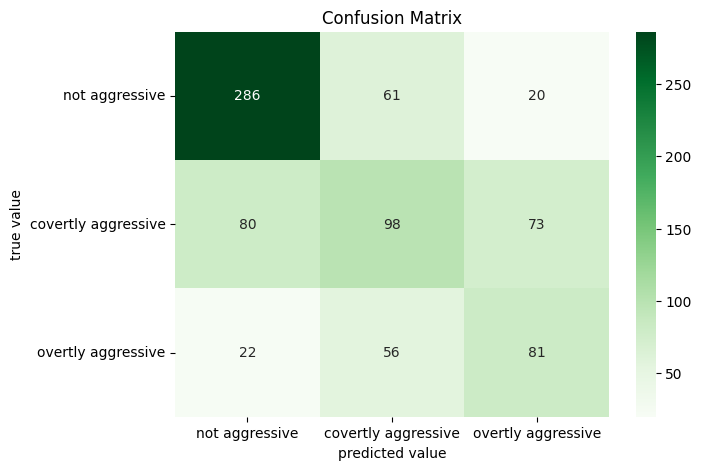

In [ ]:
# Generate test prompts and extract true labels
y_true = d2_test.loc[:, 'label']
X_test = pd.DataFrame(d2_test.apply(generate_test_prompt, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d2_test aggression prediction  without cyber bullying")
evaluate(y_true, y_pred)


  0%|          | 1/777 [00:00<07:41,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 2/777 [00:01<07:43,  1.67it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  0%|          | 3/777 [00:01<06:59,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 4/777 [00:02<06:40,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 5/777 [00:02<07:03,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 6/777 [00:03<06:36,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 7/777 [00:03<06:58,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 8/777 [00:04<07:10,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 9/777 [00:04<07:16,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|▏         | 10/777 [00:05<06:46,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|▏         | 11/777 [00:05<06:26,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 12/777 [00:06<06:43,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 13/777 [00:06<06:26,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 14/777 [00:07<06:43,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 15/777 [00:07<06:25,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 16/777 [00:08<06:46,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 17/777 [00:09<07:04,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 18/777 [00:09<07:14,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 19/777 [00:10<06:49,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 20/777 [00:10<06:32,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 21/777 [00:11<06:48,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 22/777 [00:11<06:58,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 23/777 [00:12<07:06,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 24/777 [00:12<06:41,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 25/777 [00:13<06:22,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 26/777 [00:13<06:17,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 27/777 [00:14<06:07,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▎         | 28/777 [00:14<06:28,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▎         | 29/777 [00:15<06:14,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 30/777 [00:15<06:37,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 31/777 [00:16<06:20,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 32/777 [00:17<06:37,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 33/777 [00:17<06:19,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 34/777 [00:17<06:10,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 35/777 [00:18<06:30,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▍         | 36/777 [00:18<06:12,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 37/777 [00:19<06:29,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 38/777 [00:20<06:12,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 39/777 [00:20<06:36,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▌         | 40/777 [00:21<06:17,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 41/777 [00:21<06:35,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▌         | 42/777 [00:22<06:46,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 43/777 [00:22<06:52,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 44/777 [00:23<06:55,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 45/777 [00:24<06:58,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 46/777 [00:24<07:01,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 47/777 [00:25<07:02,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 48/777 [00:25<06:34,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 49/777 [00:26<06:41,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▋         | 50/777 [00:26<06:23,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 51/777 [00:27<06:38,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 52/777 [00:27<06:48,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 53/777 [00:28<06:56,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 54/777 [00:29<07:00,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 55/777 [00:29<07:10,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 56/777 [00:30<07:10,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 57/777 [00:30<07:12,  1.66it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 58/777 [00:31<06:37,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 59/777 [00:31<06:49,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 60/777 [00:32<06:25,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 61/777 [00:33<06:39,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 62/777 [00:33<06:44,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 63/777 [00:34<06:16,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 64/777 [00:34<05:58,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 65/777 [00:34<05:47,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 66/777 [00:35<06:17,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▊         | 67/777 [00:36<06:01,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 68/777 [00:36<05:48,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 69/777 [00:36<05:39,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 70/777 [00:37<05:33,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 71/777 [00:38<05:57,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 72/777 [00:38<05:51,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 73/777 [00:38<05:41,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 74/777 [00:39<05:34,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 75/777 [00:39<05:28,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 76/777 [00:40<05:22,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 77/777 [00:40<05:48,  2.01it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 78/777 [00:41<06:05,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 79/777 [00:41<05:48,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|█         | 80/777 [00:42<06:04,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 81/777 [00:43<06:18,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 82/777 [00:43<06:27,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 83/777 [00:44<06:06,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 84/777 [00:44<05:53,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 85/777 [00:45<06:15,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 86/777 [00:45<05:59,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 87/777 [00:46<06:13,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█▏        | 88/777 [00:46<05:53,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█▏        | 89/777 [00:47<06:06,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 90/777 [00:47<06:16,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 91/777 [00:48<06:23,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 92/777 [00:49<06:28,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 93/777 [00:49<06:31,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 94/777 [00:50<06:35,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 95/777 [00:50<06:40,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 96/777 [00:51<06:40,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 97/777 [00:52<06:41,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 98/777 [00:52<06:13,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 99/777 [00:52<05:54,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 100/777 [00:53<06:05,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 101/777 [00:53<05:45,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 102/777 [00:54<05:30,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 103/777 [00:54<05:51,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 104/777 [00:55<05:41,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 105/777 [00:55<05:30,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 106/777 [00:56<05:54,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 107/777 [00:57<06:07,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 108/777 [00:57<05:47,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 109/777 [00:58<05:34,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 110/777 [00:58<05:52,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 111/777 [00:59<06:03,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 112/777 [00:59<06:11,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 113/777 [01:00<06:16,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 114/777 [01:00<06:22,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 115/777 [01:01<05:57,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 116/777 [01:02<06:07,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 117/777 [01:02<06:16,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▌        | 118/777 [01:03<05:54,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 119/777 [01:03<05:37,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 120/777 [01:04<05:25,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 121/777 [01:04<05:16,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 122/777 [01:05<05:36,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 123/777 [01:05<05:53,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 124/777 [01:06<06:01,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 125/777 [01:06<06:08,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 126/777 [01:07<05:47,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 127/777 [01:07<05:56,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▋        | 128/777 [01:08<06:02,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 129/777 [01:09<06:09,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 130/777 [01:09<05:47,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 131/777 [01:09<05:32,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 132/777 [01:10<05:20,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 133/777 [01:10<05:12,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 134/777 [01:11<05:32,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 135/777 [01:11<05:18,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 136/777 [01:12<05:34,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 137/777 [01:12<05:20,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 138/777 [01:13<05:10,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 139/777 [01:13<05:07,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 140/777 [01:14<05:25,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 141/777 [01:14<05:12,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 142/777 [01:15<05:31,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 143/777 [01:15<05:14,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▊        | 144/777 [01:16<05:04,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▊        | 145/777 [01:16<05:22,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 146/777 [01:17<05:37,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 147/777 [01:18<05:21,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 148/777 [01:18<05:09,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 149/777 [01:18<05:01,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 150/777 [01:19<04:55,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 151/777 [01:19<04:53,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 152/777 [01:20<04:53,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 153/777 [01:20<05:17,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 154/777 [01:21<05:33,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 155/777 [01:22<05:42,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 156/777 [01:22<05:49,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 157/777 [01:23<05:55,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 158/777 [01:23<05:59,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 159/777 [01:24<06:00,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 160/777 [01:24<05:36,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 161/777 [01:25<05:18,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 162/777 [01:25<05:31,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██        | 163/777 [01:26<05:14,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 164/777 [01:26<05:26,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 165/777 [01:27<05:34,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██▏       | 166/777 [01:28<05:42,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██▏       | 167/777 [01:28<05:48,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 168/777 [01:29<05:52,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 169/777 [01:29<05:31,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 170/777 [01:30<05:37,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 171/777 [01:31<05:46,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 172/777 [01:31<05:53,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 173/777 [01:32<05:29,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 174/777 [01:32<05:39,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 175/777 [01:33<05:18,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 176/777 [01:33<05:06,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 177/777 [01:34<05:18,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 178/777 [01:34<05:03,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 179/777 [01:35<04:55,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 180/777 [01:35<04:47,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 181/777 [01:36<05:05,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 182/777 [01:36<04:53,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 183/777 [01:37<04:45,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 184/777 [01:37<05:06,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 185/777 [01:38<05:18,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 186/777 [01:38<05:01,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 187/777 [01:39<04:50,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 188/777 [01:39<04:41,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 189/777 [01:39<04:36,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 190/777 [01:40<04:31,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 191/777 [01:41<04:53,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▍       | 192/777 [01:41<05:08,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 193/777 [01:42<04:55,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 194/777 [01:42<04:45,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 195/777 [01:42<04:40,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 196/777 [01:43<04:59,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 197/777 [01:44<05:11,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▌       | 198/777 [01:44<04:57,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 199/777 [01:45<05:10,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 200/777 [01:45<05:19,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 201/777 [01:46<05:24,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 202/777 [01:47<05:29,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 203/777 [01:47<05:08,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▋       | 204/777 [01:48<05:19,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▋       | 205/777 [01:48<05:23,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 206/777 [01:49<05:27,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 207/777 [01:49<05:31,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 208/777 [01:50<05:09,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 209/777 [01:50<04:52,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 210/777 [01:51<05:02,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 211/777 [01:51<04:45,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 212/777 [01:52<04:34,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 213/777 [01:52<04:27,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 214/777 [01:53<04:22,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 215/777 [01:53<04:18,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 216/777 [01:54<04:40,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 217/777 [01:54<04:33,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 218/777 [01:55<04:27,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 219/777 [01:55<04:47,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 220/777 [01:56<04:36,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 221/777 [01:56<04:27,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 222/777 [01:56<04:22,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 223/777 [01:57<04:17,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 224/777 [01:58<04:36,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 225/777 [01:58<04:26,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 226/777 [01:58<04:21,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 227/777 [01:59<04:18,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 228/777 [01:59<04:37,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 229/777 [02:00<04:27,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 230/777 [02:01<04:44,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|██▉       | 231/777 [02:01<04:33,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 232/777 [02:01<04:23,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 233/777 [02:02<04:17,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 234/777 [02:02<04:36,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|███       | 235/777 [02:03<04:25,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 236/777 [02:03<04:40,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 237/777 [02:04<04:51,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 238/777 [02:05<04:57,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 239/777 [02:05<04:42,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 240/777 [02:06<04:52,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 241/777 [02:06<04:59,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 242/777 [02:07<05:05,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███▏      | 243/777 [02:07<05:07,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███▏      | 244/777 [02:08<05:11,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 245/777 [02:09<05:10,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 246/777 [02:09<05:09,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 247/777 [02:10<05:09,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 248/777 [02:10<04:47,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 249/777 [02:11<04:35,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 250/777 [02:11<04:45,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 251/777 [02:12<04:52,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 252/777 [02:13<04:56,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 253/777 [02:13<05:01,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 254/777 [02:14<05:03,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 255/777 [02:14<04:42,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 256/777 [02:15<04:49,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 257/777 [02:15<04:33,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 258/777 [02:16<04:22,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 259/777 [02:16<04:37,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 260/777 [02:17<04:22,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 261/777 [02:17<04:33,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▎      | 262/777 [02:18<04:21,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 263/777 [02:18<04:33,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 264/777 [02:19<04:41,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 265/777 [02:19<04:25,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 266/777 [02:20<04:35,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 267/777 [02:21<04:42,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 268/777 [02:21<04:50,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 269/777 [02:22<04:54,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 270/777 [02:22<04:55,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 271/777 [02:23<04:57,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 272/777 [02:23<04:36,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 273/777 [02:24<04:42,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 274/777 [02:25<04:45,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 275/777 [02:25<04:27,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 276/777 [02:25<04:15,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 277/777 [02:26<04:28,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 278/777 [02:27<04:35,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 279/777 [02:27<04:19,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 280/777 [02:28<04:28,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 281/777 [02:28<04:15,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▋      | 282/777 [02:29<04:26,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▋      | 283/777 [02:29<04:33,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 284/777 [02:30<04:36,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 285/777 [02:31<04:39,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 286/777 [02:31<04:42,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 287/777 [02:32<04:43,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 288/777 [02:32<04:45,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 289/777 [02:33<04:45,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 290/777 [02:33<04:24,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 291/777 [02:34<04:10,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 292/777 [02:34<04:20,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 293/777 [02:35<04:29,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 294/777 [02:35<04:11,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 295/777 [02:36<04:18,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 296/777 [02:37<04:23,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 297/777 [02:37<04:10,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 298/777 [02:38<04:20,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 299/777 [02:38<04:05,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▊      | 300/777 [02:38<03:55,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▊      | 301/777 [02:39<03:51,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 302/777 [02:39<03:47,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 303/777 [02:40<03:41,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 304/777 [02:40<03:41,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 305/777 [02:41<03:58,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 306/777 [02:42<04:09,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 307/777 [02:42<04:00,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 308/777 [02:43<04:10,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 309/777 [02:43<03:57,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 310/777 [02:44<04:08,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|████      | 311/777 [02:44<03:56,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 312/777 [02:45<03:48,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 313/777 [02:45<03:42,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 314/777 [02:46<03:58,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 315/777 [02:46<04:08,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 316/777 [02:47<03:57,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 317/777 [02:47<04:08,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 318/777 [02:48<03:55,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 319/777 [02:48<04:07,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 320/777 [02:49<03:54,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 321/777 [02:49<03:45,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 322/777 [02:50<03:58,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 323/777 [02:50<03:48,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 324/777 [02:51<03:39,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 325/777 [02:51<03:34,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 326/777 [02:52<03:48,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 327/777 [02:52<03:59,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 328/777 [02:53<03:47,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 329/777 [02:53<03:39,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 330/777 [02:54<03:33,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 331/777 [02:54<03:48,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 332/777 [02:55<03:38,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 333/777 [02:55<03:51,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 334/777 [02:56<04:00,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 335/777 [02:56<03:48,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 336/777 [02:57<03:39,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 337/777 [02:57<03:54,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▎     | 338/777 [02:58<04:01,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▎     | 339/777 [02:59<04:06,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 340/777 [02:59<04:09,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 341/777 [03:00<03:52,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 342/777 [03:00<03:59,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 343/777 [03:01<04:04,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 344/777 [03:01<03:49,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 345/777 [03:02<03:56,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 346/777 [03:02<03:43,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 347/777 [03:03<03:35,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 348/777 [03:03<03:48,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 349/777 [03:04<03:37,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 350/777 [03:04<03:28,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 351/777 [03:05<03:22,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 352/777 [03:05<03:36,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▌     | 353/777 [03:06<03:47,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 354/777 [03:06<03:54,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 355/777 [03:07<03:42,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 356/777 [03:08<03:48,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 357/777 [03:08<03:54,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 358/777 [03:09<03:39,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 359/777 [03:09<03:31,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 360/777 [03:09<03:23,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 361/777 [03:10<03:20,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 362/777 [03:11<03:32,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 363/777 [03:11<03:25,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 364/777 [03:11<03:18,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 365/777 [03:12<03:29,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 366/777 [03:13<03:37,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 367/777 [03:13<03:28,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 368/777 [03:14<03:36,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 369/777 [03:14<03:42,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 370/777 [03:15<03:46,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 371/777 [03:15<03:33,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 372/777 [03:16<03:24,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 373/777 [03:16<03:36,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 374/777 [03:17<03:25,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 375/777 [03:17<03:36,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 376/777 [03:18<03:42,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▊     | 377/777 [03:18<03:29,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▊     | 378/777 [03:19<03:36,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 379/777 [03:20<03:41,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 380/777 [03:20<03:28,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 381/777 [03:21<03:35,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 382/777 [03:21<03:40,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 383/777 [03:22<03:43,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 384/777 [03:22<03:45,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 385/777 [03:23<03:46,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|████▉     | 386/777 [03:24<03:46,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 387/777 [03:24<03:29,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 388/777 [03:24<03:17,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 389/777 [03:25<03:25,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|█████     | 390/777 [03:25<03:19,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 391/777 [03:26<03:12,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 392/777 [03:27<03:23,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 393/777 [03:27<03:14,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 394/777 [03:28<03:24,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 395/777 [03:28<03:14,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 396/777 [03:28<03:06,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 397/777 [03:29<03:00,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 398/777 [03:29<03:12,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████▏    | 399/777 [03:30<03:22,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████▏    | 400/777 [03:31<03:26,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 401/777 [03:31<03:29,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 402/777 [03:32<03:16,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 403/777 [03:32<03:06,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 404/777 [03:33<03:16,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 405/777 [03:33<03:07,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 406/777 [03:34<03:00,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 407/777 [03:34<02:56,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 408/777 [03:35<02:52,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 409/777 [03:35<02:49,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 410/777 [03:35<02:48,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 411/777 [03:36<03:01,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 412/777 [03:37<03:11,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 413/777 [03:37<03:17,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 414/777 [03:38<03:07,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 415/777 [03:38<03:14,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▎    | 416/777 [03:39<03:04,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 417/777 [03:39<02:57,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 418/777 [03:40<02:52,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 419/777 [03:40<03:02,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 420/777 [03:41<03:10,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 421/777 [03:41<03:18,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 422/777 [03:42<03:22,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 423/777 [03:43<03:23,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▍    | 424/777 [03:43<03:25,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 425/777 [03:44<03:26,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▍    | 426/777 [03:44<03:26,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▍    | 427/777 [03:45<03:11,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 428/777 [03:45<03:15,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 429/777 [03:46<03:17,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 430/777 [03:47<03:18,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 431/777 [03:47<03:20,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 432/777 [03:48<03:10,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 433/777 [03:48<03:01,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 434/777 [03:49<03:07,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 435/777 [03:49<02:57,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 436/777 [03:50<02:49,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 437/777 [03:50<02:44,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 438/777 [03:50<02:40,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 439/777 [03:51<02:53,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 440/777 [03:52<03:01,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 441/777 [03:52<03:05,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 442/777 [03:53<03:09,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 443/777 [03:53<02:58,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 444/777 [03:54<03:03,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 445/777 [03:55<03:06,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 446/777 [03:55<03:10,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 447/777 [03:56<02:57,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 448/777 [03:56<03:02,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 449/777 [03:57<02:50,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 450/777 [03:57<02:43,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 451/777 [03:58<02:37,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 452/777 [03:58<02:48,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 453/777 [03:59<02:54,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 454/777 [03:59<03:00,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 455/777 [04:00<02:49,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▊    | 456/777 [04:00<02:42,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 457/777 [04:01<02:36,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 458/777 [04:01<02:34,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 459/777 [04:02<02:43,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 460/777 [04:02<02:37,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 461/777 [04:03<02:45,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 462/777 [04:03<02:50,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|█████▉    | 463/777 [04:04<02:54,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 464/777 [04:05<02:56,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 465/777 [04:05<03:00,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|█████▉    | 466/777 [04:06<02:47,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 467/777 [04:06<02:38,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 468/777 [04:07<02:43,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 469/777 [04:07<02:48,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|██████    | 470/777 [04:08<02:52,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████    | 471/777 [04:08<02:41,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 472/777 [04:09<02:47,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 473/777 [04:09<02:51,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████    | 474/777 [04:10<02:53,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 475/777 [04:11<02:53,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████▏   | 476/777 [04:11<02:57,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████▏   | 477/777 [04:12<02:56,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 478/777 [04:12<02:43,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 479/777 [04:13<02:47,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 480/777 [04:13<02:36,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 481/777 [04:14<02:41,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 482/777 [04:14<02:33,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 483/777 [04:15<02:27,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 484/777 [04:15<02:36,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 485/777 [04:16<02:40,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 486/777 [04:16<02:31,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 487/777 [04:17<02:24,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 488/777 [04:17<02:31,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 489/777 [04:18<02:24,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 490/777 [04:19<02:30,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 491/777 [04:19<02:23,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 492/777 [04:19<02:19,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 493/777 [04:20<02:29,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▎   | 494/777 [04:21<02:34,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▎   | 495/777 [04:21<02:37,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 496/777 [04:22<02:39,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 497/777 [04:22<02:40,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 498/777 [04:23<02:29,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 499/777 [04:23<02:22,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 500/777 [04:24<02:17,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 501/777 [04:24<02:13,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 502/777 [04:25<02:22,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 503/777 [04:25<02:27,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 504/777 [04:26<02:20,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 505/777 [04:26<02:26,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▌   | 506/777 [04:27<02:19,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 507/777 [04:27<02:13,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 508/777 [04:28<02:09,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 509/777 [04:28<02:17,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 510/777 [04:29<02:11,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 511/777 [04:29<02:18,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 512/777 [04:30<02:11,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 513/777 [04:30<02:07,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 514/777 [04:31<02:04,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 515/777 [04:31<02:13,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▋   | 516/777 [04:32<02:09,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 517/777 [04:32<02:06,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 518/777 [04:33<02:03,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 519/777 [04:33<02:00,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 520/777 [04:34<02:10,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 521/777 [04:34<02:16,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 522/777 [04:35<02:09,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 523/777 [04:35<02:15,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 524/777 [04:36<02:19,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 525/777 [04:37<02:22,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 526/777 [04:37<02:25,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 527/777 [04:38<02:25,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 528/777 [04:38<02:15,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 529/777 [04:39<02:08,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 530/777 [04:39<02:14,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 531/777 [04:40<02:18,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 532/777 [04:41<02:20,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 69%|██████▊   | 533/777 [04:41<02:22,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▊   | 534/777 [04:42<02:11,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 535/777 [04:42<02:04,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 536/777 [04:43<02:09,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▉   | 537/777 [04:43<02:02,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 538/777 [04:44<02:08,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▉   | 539/777 [04:44<02:01,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 540/777 [04:45<02:06,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 541/777 [04:45<02:10,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 542/777 [04:46<02:02,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|██████▉   | 543/777 [04:46<02:06,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 544/777 [04:47<01:58,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 545/777 [04:47<02:03,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 546/777 [04:48<02:07,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 547/777 [04:49<02:09,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 548/777 [04:49<02:10,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 549/777 [04:50<02:10,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 550/777 [04:50<02:01,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 551/777 [04:51<01:54,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 552/777 [04:51<01:59,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 553/777 [04:52<02:02,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████▏  | 554/777 [04:52<02:06,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████▏  | 555/777 [04:53<01:58,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 556/777 [04:53<02:02,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 557/777 [04:54<02:04,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 558/777 [04:54<01:57,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 559/777 [04:55<01:51,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 560/777 [04:56<01:58,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 561/777 [04:56<02:00,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 562/777 [04:57<01:53,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 563/777 [04:57<01:48,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 564/777 [04:58<01:52,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 565/777 [04:58<01:47,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 566/777 [04:59<01:43,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 567/777 [04:59<01:40,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 568/777 [04:59<01:37,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 569/777 [05:00<01:44,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 73%|███████▎  | 570/777 [05:01<01:49,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 571/777 [05:01<01:52,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▎  | 572/777 [05:02<01:55,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▎  | 573/777 [05:02<01:48,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 574/777 [05:03<01:43,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 575/777 [05:03<01:48,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 576/777 [05:04<01:43,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 577/777 [05:04<01:47,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 578/777 [05:05<01:50,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▍  | 579/777 [05:05<01:44,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▍  | 580/777 [05:06<01:39,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▍  | 581/777 [05:07<01:43,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 582/777 [05:07<01:47,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 583/777 [05:08<01:41,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 584/777 [05:08<01:37,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 585/777 [05:09<01:42,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 586/777 [05:09<01:38,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 587/777 [05:10<01:42,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 588/777 [05:10<01:36,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 589/777 [05:11<01:40,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 590/777 [05:11<01:43,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 591/777 [05:12<01:45,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 592/777 [05:12<01:38,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▋  | 593/777 [05:13<01:33,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▋  | 594/777 [05:13<01:29,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 595/777 [05:14<01:34,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 596/777 [05:14<01:37,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 597/777 [05:15<01:32,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 598/777 [05:15<01:28,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 599/777 [05:16<01:32,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 600/777 [05:16<01:28,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 601/777 [05:17<01:24,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 602/777 [05:17<01:28,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 603/777 [05:18<01:24,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 604/777 [05:18<01:28,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 605/777 [05:19<01:31,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 606/777 [05:20<01:33,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 607/777 [05:20<01:27,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 608/777 [05:20<01:23,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 609/777 [05:21<01:20,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▊  | 610/777 [05:21<01:25,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▊  | 611/777 [05:22<01:27,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 612/777 [05:22<01:23,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 613/777 [05:23<01:20,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 614/777 [05:24<01:23,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 615/777 [05:24<01:19,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 616/777 [05:24<01:16,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 617/777 [05:25<01:14,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 618/777 [05:25<01:14,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 619/777 [05:26<01:13,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 620/777 [05:26<01:12,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 621/777 [05:27<01:11,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 622/777 [05:27<01:16,  2.02it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 623/777 [05:28<01:20,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 624/777 [05:28<01:16,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 625/777 [05:29<01:19,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 626/777 [05:29<01:16,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 627/777 [05:30<01:12,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 628/777 [05:30<01:10,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 629/777 [05:31<01:09,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 630/777 [05:31<01:07,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 631/777 [05:32<01:11,  2.05it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████▏ | 632/777 [05:32<01:14,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████▏ | 633/777 [05:33<01:10,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 634/777 [05:33<01:07,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 635/777 [05:34<01:05,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 636/777 [05:34<01:04,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 637/777 [05:35<01:09,  2.02it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 638/777 [05:35<01:12,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 639/777 [05:36<01:14,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 640/777 [05:36<01:15,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 641/777 [05:37<01:10,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 642/777 [05:37<01:12,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 643/777 [05:38<01:08,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 644/777 [05:38<01:10,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 645/777 [05:39<01:06,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 646/777 [05:39<01:09,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 647/777 [05:40<01:10,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 648/777 [05:40<01:06,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 649/777 [05:41<01:08,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▎ | 650/777 [05:42<01:09,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 651/777 [05:42<01:10,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 652/777 [05:43<01:10,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 653/777 [05:43<01:10,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 654/777 [05:44<01:05,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 655/777 [05:44<01:01,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 656/777 [05:45<00:58,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 657/777 [05:45<01:01,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▍ | 658/777 [05:46<01:03,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▍ | 659/777 [05:46<01:04,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 660/777 [05:47<01:04,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 661/777 [05:47<01:00,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 662/777 [05:48<01:01,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 663/777 [05:49<01:02,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 664/777 [05:49<01:02,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 665/777 [05:50<01:02,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 666/777 [05:50<00:58,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 667/777 [05:51<00:54,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 668/777 [05:51<00:56,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 669/777 [05:52<00:53,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 670/777 [05:52<00:51,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▋ | 671/777 [05:53<00:53,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▋ | 672/777 [05:53<00:50,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 673/777 [05:54<00:52,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 674/777 [05:54<00:50,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 675/777 [05:54<00:49,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 676/777 [05:55<00:52,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 677/777 [05:56<00:50,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 678/777 [05:56<00:52,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 679/777 [05:57<00:53,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 680/777 [05:57<00:50,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 681/777 [05:58<00:51,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 682/777 [05:58<00:48,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 683/777 [05:59<00:46,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 684/777 [05:59<00:45,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 685/777 [06:00<00:44,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 686/777 [06:00<00:46,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 687/777 [06:01<00:48,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▊ | 688/777 [06:01<00:46,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▊ | 689/777 [06:02<00:47,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 690/777 [06:02<00:44,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 691/777 [06:03<00:46,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 692/777 [06:04<00:47,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 693/777 [06:04<00:47,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 89%|████████▉ | 694/777 [06:05<00:44,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 695/777 [06:05<00:41,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 696/777 [06:05<00:40,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 697/777 [06:06<00:41,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 698/777 [06:07<00:42,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|████████▉ | 699/777 [06:07<00:44,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|█████████ | 700/777 [06:08<00:44,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|█████████ | 701/777 [06:08<00:41,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 702/777 [06:09<00:41,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 703/777 [06:10<00:42,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 704/777 [06:10<00:39,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 705/777 [06:11<00:39,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 706/777 [06:11<00:40,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 707/777 [06:12<00:37,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 708/777 [06:12<00:35,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 709/777 [06:13<00:36,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████▏| 710/777 [06:13<00:37,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 711/777 [06:14<00:34,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 712/777 [06:14<00:33,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 713/777 [06:15<00:34,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 714/777 [06:15<00:35,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 715/777 [06:16<00:35,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 716/777 [06:17<00:35,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 717/777 [06:17<00:34,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 718/777 [06:18<00:34,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 719/777 [06:18<00:31,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 720/777 [06:19<00:29,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 721/777 [06:19<00:30,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 722/777 [06:20<00:30,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 723/777 [06:20<00:30,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 724/777 [06:21<00:30,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 725/777 [06:22<00:30,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 726/777 [06:22<00:27,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 727/777 [06:23<00:25,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 728/777 [06:23<00:24,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 729/777 [06:24<00:25,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 730/777 [06:24<00:23,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 731/777 [06:25<00:24,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 732/777 [06:25<00:25,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 733/777 [06:26<00:23,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 734/777 [06:26<00:23,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▍| 735/777 [06:27<00:21,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 736/777 [06:27<00:22,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▍| 737/777 [06:28<00:20,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 738/777 [06:28<00:19,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 739/777 [06:29<00:18,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 740/777 [06:29<00:19,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▌| 741/777 [06:30<00:19,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 742/777 [06:31<00:19,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 743/777 [06:31<00:17,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 744/777 [06:32<00:18,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 745/777 [06:32<00:16,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 746/777 [06:32<00:15,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 747/777 [06:33<00:14,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 748/777 [06:34<00:15,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▋| 749/777 [06:34<00:13,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 750/777 [06:34<00:13,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 751/777 [06:35<00:12,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 752/777 [06:35<00:12,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 753/777 [06:36<00:12,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 97%|█████████▋| 754/777 [06:37<00:12,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 97%|█████████▋| 755/777 [06:37<00:12,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 756/777 [06:38<00:11,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 757/777 [06:38<00:10,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 758/777 [06:39<00:09,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 759/777 [06:39<00:08,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 760/777 [06:40<00:08,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 761/777 [06:40<00:08,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 762/777 [06:41<00:07,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 763/777 [06:41<00:06,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 764/777 [06:41<00:06,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 765/777 [06:42<00:06,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 766/777 [06:43<00:05,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 767/777 [06:43<00:05,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 768/777 [06:44<00:04,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 769/777 [06:44<00:04,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 770/777 [06:45<00:03,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▉| 771/777 [06:45<00:03,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 772/777 [06:46<00:02,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 773/777 [06:46<00:02,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 774/777 [06:47<00:01,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 775/777 [06:48<00:01,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 776/777 [06:48<00:00,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|██████████| 777/777 [06:49<00:00,  1.90it/s]

Predicted answer: overtly aggressive
d2_test aggression prediction  with cyber bullying
Accuracy: 0.597
Accuracy for label not aggressive: 0.741
Accuracy for label covertly aggressive: 0.442
Accuracy for label overtly aggressive: 0.509

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.75      0.74      0.75       367
covertly aggressive       0.45      0.44      0.45       251
 overtly aggressive       0.48      0.51      0.49       159

           accuracy                           0.60       777
          macro avg       0.56      0.56      0.56       777
       weighted avg       0.60      0.60      0.60       777


Confusion Matrix:
[[272  75  20]
 [ 71 111  69]
 [ 18  60  81]]


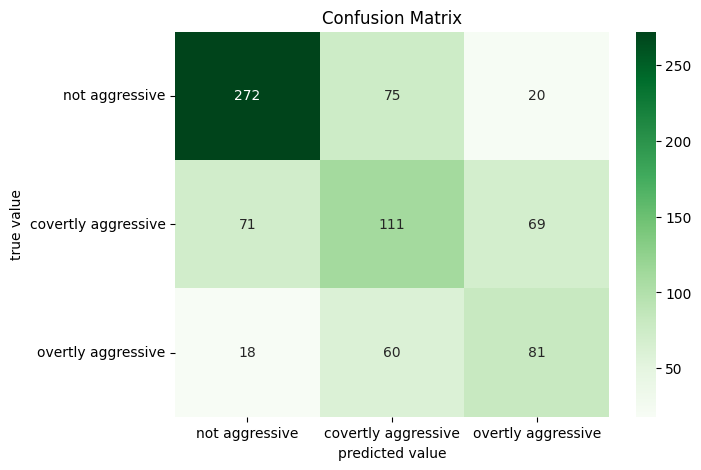

In [ ]:

# Generate test prompts and extract true labels
y_true = d2_test.loc[:, 'label']
X_test = pd.DataFrame(d2_test.apply(generate_test_prompt_cyb_detail_v1, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d2_test aggression prediction  with cyber bullying")
evaluate(y_true, y_pred)

  0%|          | 1/1225 [00:00<09:10,  2.22it/s]Device set to use cuda:0


Predicted answer: not aggressive


  0%|          | 2/1225 [00:00<09:12,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


  0%|          | 3/1225 [00:01<10:32,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 4/1225 [00:02<11:09,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 5/1225 [00:02<10:28,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


  0%|          | 6/1225 [00:03<10:01,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 7/1225 [00:03<10:45,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 8/1225 [00:04<11:04,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 9/1225 [00:04<11:24,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 10/1225 [00:05<11:34,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 11/1225 [00:05<10:49,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 12/1225 [00:06<11:09,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 13/1225 [00:07<11:29,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 14/1225 [00:07<11:36,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 15/1225 [00:08<11:44,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|▏         | 16/1225 [00:08<11:02,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|▏         | 17/1225 [00:09<11:19,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|▏         | 18/1225 [00:09<11:32,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 19/1225 [00:10<11:50,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 20/1225 [00:10<11:08,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 21/1225 [00:11<11:39,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 22/1225 [00:12<11:47,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 23/1225 [00:12<11:51,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 24/1225 [00:13<12:02,  1.66it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 25/1225 [00:14<12:01,  1.66it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 26/1225 [00:14<11:09,  1.79it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 27/1225 [00:15<11:24,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 28/1225 [00:15<11:32,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 29/1225 [00:16<10:45,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 30/1225 [00:16<10:23,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 31/1225 [00:17<10:04,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 32/1225 [00:17<10:42,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 33/1225 [00:18<11:03,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 34/1225 [00:18<11:16,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 35/1225 [00:19<11:26,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 36/1225 [00:20<11:30,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 37/1225 [00:20<10:49,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 38/1225 [00:21<10:15,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 39/1225 [00:21<10:41,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 40/1225 [00:22<11:02,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 41/1225 [00:22<10:30,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 42/1225 [00:23<10:54,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▎         | 43/1225 [00:23<10:19,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▎         | 44/1225 [00:24<10:42,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▎         | 45/1225 [00:24<11:04,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 46/1225 [00:25<11:21,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 47/1225 [00:26<10:34,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 48/1225 [00:26<10:13,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 49/1225 [00:27<10:38,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▍         | 50/1225 [00:27<10:57,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▍         | 51/1225 [00:28<11:07,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 52/1225 [00:28<11:17,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▍         | 53/1225 [00:29<11:26,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▍         | 54/1225 [00:29<10:44,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 55/1225 [00:30<11:09,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▍         | 56/1225 [00:31<10:30,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 57/1225 [00:31<10:52,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 58/1225 [00:32<11:03,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 59/1225 [00:32<10:23,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 60/1225 [00:33<10:48,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 61/1225 [00:33<11:02,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▌         | 62/1225 [00:34<10:24,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 63/1225 [00:34<10:45,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▌         | 64/1225 [00:35<11:03,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 65/1225 [00:36<11:10,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 66/1225 [00:36<10:26,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 67/1225 [00:37<09:52,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 68/1225 [00:37<10:20,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 69/1225 [00:38<09:51,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 70/1225 [00:38<10:24,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 71/1225 [00:39<10:45,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 72/1225 [00:39<11:07,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 73/1225 [00:40<10:24,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 74/1225 [00:40<10:41,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 75/1225 [00:41<10:52,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 76/1225 [00:42<11:04,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▋         | 77/1225 [00:42<10:23,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 78/1225 [00:43<09:56,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 79/1225 [00:43<09:34,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 80/1225 [00:44<10:04,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 81/1225 [00:44<10:39,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 82/1225 [00:45<10:02,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 83/1225 [00:45<10:26,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 84/1225 [00:46<09:55,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 85/1225 [00:46<09:31,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 86/1225 [00:47<09:57,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 87/1225 [00:47<09:34,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 88/1225 [00:48<09:15,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 89/1225 [00:48<09:06,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 90/1225 [00:49<08:55,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 91/1225 [00:49<09:33,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 92/1225 [00:50<09:13,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 93/1225 [00:50<09:47,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 94/1225 [00:51<10:08,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 95/1225 [00:51<10:29,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 96/1225 [00:52<10:40,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 97/1225 [00:52<09:58,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 98/1225 [00:53<10:19,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 99/1225 [00:54<10:33,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 100/1225 [00:54<10:40,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 101/1225 [00:55<10:42,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 102/1225 [00:55<10:49,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 103/1225 [00:56<10:03,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 104/1225 [00:56<10:26,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▊         | 105/1225 [00:57<10:37,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▊         | 106/1225 [00:58<09:55,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▊         | 107/1225 [00:58<10:18,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 108/1225 [00:59<09:41,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 109/1225 [00:59<10:08,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 110/1225 [01:00<09:34,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 111/1225 [01:00<09:20,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 112/1225 [01:01<09:03,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 113/1225 [01:01<09:42,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 114/1225 [01:02<10:05,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 115/1225 [01:02<10:21,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 116/1225 [01:03<09:45,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 117/1225 [01:03<10:10,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 118/1225 [01:04<10:22,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 119/1225 [01:04<09:49,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 120/1225 [01:05<10:11,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 121/1225 [01:06<10:22,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 122/1225 [01:06<10:33,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 123/1225 [01:07<10:38,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 124/1225 [01:07<10:43,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 125/1225 [01:08<10:01,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|█         | 126/1225 [01:08<09:35,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|█         | 127/1225 [01:09<09:59,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 128/1225 [01:10<10:20,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 129/1225 [01:10<10:35,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 130/1225 [01:11<10:41,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 131/1225 [01:11<10:48,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 132/1225 [01:12<10:07,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 133/1225 [01:12<09:37,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 134/1225 [01:13<09:12,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 135/1225 [01:13<09:38,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 136/1225 [01:14<09:11,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 137/1225 [01:14<09:37,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█▏        | 138/1225 [01:15<09:11,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█▏        | 139/1225 [01:15<09:37,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█▏        | 140/1225 [01:16<09:10,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 141/1225 [01:16<08:52,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 142/1225 [01:17<09:25,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 143/1225 [01:17<09:03,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 144/1225 [01:18<08:49,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 145/1225 [01:18<08:35,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 146/1225 [01:19<08:29,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 147/1225 [01:19<09:09,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 148/1225 [01:20<09:37,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 149/1225 [01:20<09:10,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 150/1225 [01:21<08:51,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 151/1225 [01:21<08:39,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 152/1225 [01:22<08:32,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 153/1225 [01:22<09:07,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 154/1225 [01:23<09:43,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 155/1225 [01:23<09:11,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 156/1225 [01:24<08:54,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 157/1225 [01:24<08:36,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 158/1225 [01:25<09:09,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 159/1225 [01:26<09:44,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 160/1225 [01:26<09:56,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 161/1225 [01:27<09:18,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 162/1225 [01:27<08:55,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 163/1225 [01:27<08:34,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 164/1225 [01:28<08:22,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 165/1225 [01:28<08:14,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 166/1225 [01:29<08:09,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 167/1225 [01:29<08:47,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▎        | 168/1225 [01:30<08:29,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 169/1225 [01:30<09:02,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 170/1225 [01:31<09:37,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 171/1225 [01:32<09:10,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 172/1225 [01:32<08:50,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 173/1225 [01:32<08:35,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 174/1225 [01:33<09:11,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 175/1225 [01:34<09:33,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 176/1225 [01:34<09:03,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 177/1225 [01:35<09:26,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 178/1225 [01:35<09:42,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 179/1225 [01:36<09:52,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 180/1225 [01:36<10:00,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 181/1225 [01:37<09:22,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 182/1225 [01:38<09:38,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 183/1225 [01:38<09:46,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▌        | 184/1225 [01:39<09:55,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 185/1225 [01:39<10:01,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 186/1225 [01:40<09:21,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 187/1225 [01:40<09:35,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 188/1225 [01:41<09:04,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 189/1225 [01:41<08:45,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 190/1225 [01:42<09:10,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 191/1225 [01:42<09:31,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 192/1225 [01:43<09:42,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 193/1225 [01:44<09:07,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 194/1225 [01:44<09:27,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 195/1225 [01:45<09:40,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 196/1225 [01:45<09:57,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 197/1225 [01:46<09:59,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 198/1225 [01:46<09:18,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 199/1225 [01:47<09:31,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▋        | 200/1225 [01:47<08:59,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 201/1225 [01:48<08:36,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 202/1225 [01:48<08:21,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 203/1225 [01:49<08:54,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 204/1225 [01:49<09:11,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 205/1225 [01:50<08:42,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 206/1225 [01:50<08:22,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 207/1225 [01:51<08:07,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 208/1225 [01:51<08:42,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 209/1225 [01:52<08:22,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 210/1225 [01:52<08:11,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 211/1225 [01:53<08:41,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 212/1225 [01:54<09:05,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 213/1225 [01:54<09:22,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 214/1225 [01:55<09:36,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 215/1225 [01:55<09:48,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 216/1225 [01:56<09:57,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 217/1225 [01:57<10:03,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 218/1225 [01:57<10:07,  1.66it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 219/1225 [01:58<09:21,  1.79it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 220/1225 [01:58<09:29,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 221/1225 [01:59<08:52,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 222/1225 [01:59<09:10,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 223/1225 [02:00<08:40,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 224/1225 [02:00<09:03,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 225/1225 [02:01<08:33,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 226/1225 [02:01<09:01,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▊        | 227/1225 [02:02<09:19,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▊        | 228/1225 [02:03<09:25,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▊        | 229/1225 [02:03<08:51,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 230/1225 [02:04<09:04,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 231/1225 [02:04<08:41,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 232/1225 [02:04<08:21,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 233/1225 [02:05<08:07,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 234/1225 [02:06<08:38,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 235/1225 [02:06<08:18,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 236/1225 [02:06<08:00,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 237/1225 [02:07<07:48,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 238/1225 [02:07<07:39,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 239/1225 [02:08<08:15,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 240/1225 [02:09<08:40,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 241/1225 [02:09<08:58,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 242/1225 [02:10<09:09,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 243/1225 [02:10<09:17,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 244/1225 [02:11<08:41,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 245/1225 [02:11<08:54,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 246/1225 [02:12<09:03,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 247/1225 [02:12<09:12,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 248/1225 [02:13<09:22,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 249/1225 [02:14<09:25,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 250/1225 [02:14<08:48,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 251/1225 [02:15<08:21,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 252/1225 [02:15<08:06,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 253/1225 [02:16<08:29,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██        | 254/1225 [02:16<08:07,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 255/1225 [02:17<08:34,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 256/1225 [02:17<08:20,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 257/1225 [02:18<08:03,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 258/1225 [02:18<07:57,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 259/1225 [02:19<07:48,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 260/1225 [02:19<08:17,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██▏       | 261/1225 [02:20<07:56,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██▏       | 262/1225 [02:20<07:46,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██▏       | 263/1225 [02:21<08:14,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 264/1225 [02:21<07:53,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 265/1225 [02:22<08:17,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 266/1225 [02:22<08:37,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 267/1225 [02:23<08:53,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 268/1225 [02:23<08:25,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 269/1225 [02:24<08:40,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 270/1225 [02:24<08:19,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 271/1225 [02:25<08:00,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 272/1225 [02:25<08:22,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 273/1225 [02:26<08:39,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 274/1225 [02:26<08:12,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 275/1225 [02:27<08:33,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 276/1225 [02:27<08:09,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 277/1225 [02:28<08:35,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 278/1225 [02:29<08:48,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 279/1225 [02:29<08:17,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 280/1225 [02:30<07:56,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 281/1225 [02:30<08:20,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 282/1225 [02:31<07:59,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 283/1225 [02:31<07:44,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 284/1225 [02:32<08:10,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 285/1225 [02:32<07:51,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 286/1225 [02:33<08:16,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 287/1225 [02:33<07:55,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 288/1225 [02:34<07:38,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 289/1225 [02:34<08:06,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▎       | 290/1225 [02:35<08:24,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 291/1225 [02:35<08:39,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 292/1225 [02:36<08:12,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 293/1225 [02:36<07:51,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 294/1225 [02:37<07:37,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 295/1225 [02:37<08:04,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 296/1225 [02:38<08:24,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 297/1225 [02:39<08:38,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 298/1225 [02:39<08:08,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 299/1225 [02:39<07:50,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 300/1225 [02:40<08:15,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▍       | 301/1225 [02:41<07:52,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 302/1225 [02:41<08:14,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▍       | 303/1225 [02:42<08:28,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 304/1225 [02:42<08:07,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 305/1225 [02:43<08:24,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▍       | 306/1225 [02:43<07:59,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 307/1225 [02:44<07:40,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 308/1225 [02:44<07:30,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 309/1225 [02:45<07:19,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 310/1225 [02:45<07:14,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 311/1225 [02:46<07:45,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▌       | 312/1225 [02:46<08:10,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 313/1225 [02:47<08:25,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 314/1225 [02:47<07:58,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 315/1225 [02:48<08:16,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 316/1225 [02:49<08:27,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 317/1225 [02:49<08:35,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 318/1225 [02:50<08:41,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 319/1225 [02:50<08:13,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 320/1225 [02:51<07:51,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 321/1225 [02:51<07:35,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▋       | 322/1225 [02:52<07:21,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▋       | 323/1225 [02:52<07:49,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▋       | 324/1225 [02:53<07:31,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 325/1225 [02:53<07:56,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 326/1225 [02:54<07:36,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 327/1225 [02:54<07:26,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 328/1225 [02:55<07:50,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 329/1225 [02:55<08:14,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 330/1225 [02:56<07:50,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 331/1225 [02:56<07:35,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 332/1225 [02:57<07:19,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 333/1225 [02:57<07:48,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 334/1225 [02:58<07:27,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 335/1225 [02:58<07:12,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 336/1225 [02:59<07:39,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 337/1225 [02:59<07:22,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 338/1225 [03:00<07:47,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 339/1225 [03:00<07:27,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 340/1225 [03:01<07:12,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 341/1225 [03:01<07:05,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 342/1225 [03:02<06:59,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 343/1225 [03:02<06:52,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 344/1225 [03:03<07:21,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 345/1225 [03:03<07:45,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 346/1225 [03:04<08:01,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 347/1225 [03:05<08:17,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 348/1225 [03:05<08:28,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 349/1225 [03:06<07:51,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 350/1225 [03:06<08:06,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▊       | 351/1225 [03:07<08:15,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▊       | 352/1225 [03:07<07:51,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 353/1225 [03:08<07:30,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 354/1225 [03:08<07:12,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 355/1225 [03:09<07:37,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 356/1225 [03:09<07:56,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 357/1225 [03:10<08:07,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 358/1225 [03:11<08:14,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 359/1225 [03:11<08:22,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 360/1225 [03:12<08:25,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 361/1225 [03:12<07:54,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 362/1225 [03:13<08:07,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|██▉       | 363/1225 [03:13<07:38,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 364/1225 [03:14<07:17,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 365/1225 [03:14<07:39,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|██▉       | 366/1225 [03:15<07:17,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 367/1225 [03:15<07:07,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 368/1225 [03:16<06:56,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 369/1225 [03:16<07:23,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 370/1225 [03:17<07:47,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 371/1225 [03:17<08:05,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|███       | 372/1225 [03:18<07:38,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 373/1225 [03:19<07:52,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 374/1225 [03:19<08:05,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 375/1225 [03:20<08:11,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 376/1225 [03:20<07:41,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 377/1225 [03:21<07:57,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 378/1225 [03:21<08:06,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 379/1225 [03:22<07:34,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 380/1225 [03:22<07:15,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 381/1225 [03:23<07:00,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 382/1225 [03:23<06:49,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███▏      | 383/1225 [03:24<07:14,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███▏      | 384/1225 [03:24<06:57,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███▏      | 385/1225 [03:25<06:45,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 386/1225 [03:25<06:36,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 387/1225 [03:26<06:28,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 388/1225 [03:26<06:29,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 389/1225 [03:27<07:00,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 390/1225 [03:27<06:47,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 391/1225 [03:28<07:14,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 392/1225 [03:28<06:58,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 393/1225 [03:29<07:20,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 394/1225 [03:29<07:04,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 395/1225 [03:30<07:26,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 396/1225 [03:30<07:07,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 397/1225 [03:31<06:52,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 398/1225 [03:31<06:42,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 399/1225 [03:32<07:08,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 400/1225 [03:32<07:29,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 401/1225 [03:33<07:44,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 402/1225 [03:34<07:50,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 403/1225 [03:34<07:21,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 404/1225 [03:35<07:35,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 405/1225 [03:35<07:10,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 406/1225 [03:36<06:53,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 407/1225 [03:36<06:44,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 408/1225 [03:37<07:05,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 409/1225 [03:37<06:47,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 410/1225 [03:38<06:36,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 411/1225 [03:38<06:29,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 412/1225 [03:38<06:22,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 413/1225 [03:39<06:53,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 414/1225 [03:40<07:09,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 415/1225 [03:40<06:52,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 416/1225 [03:41<06:38,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 417/1225 [03:41<06:32,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 418/1225 [03:42<07:05,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 419/1225 [03:42<06:52,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 420/1225 [03:43<07:23,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 421/1225 [03:43<07:38,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 422/1225 [03:44<07:45,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▍      | 423/1225 [03:45<07:49,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 424/1225 [03:45<07:17,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 425/1225 [03:46<06:55,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 426/1225 [03:46<06:40,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 427/1225 [03:47<07:01,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▍      | 428/1225 [03:47<06:44,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 429/1225 [03:48<07:04,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 430/1225 [03:48<07:19,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 431/1225 [03:49<07:29,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 432/1225 [03:49<07:04,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 433/1225 [03:50<07:18,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 434/1225 [03:50<07:32,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 435/1225 [03:51<07:39,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 436/1225 [03:52<07:42,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 437/1225 [03:52<07:13,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 438/1225 [03:53<06:51,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 439/1225 [03:53<06:40,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 440/1225 [03:54<06:28,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 441/1225 [03:54<06:54,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 442/1225 [03:55<06:35,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 443/1225 [03:55<06:58,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 444/1225 [03:56<07:14,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▋      | 445/1225 [03:56<07:21,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▋      | 446/1225 [03:57<06:55,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▋      | 447/1225 [03:57<06:36,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 448/1225 [03:58<06:23,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 449/1225 [03:58<06:14,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 450/1225 [03:59<06:07,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 451/1225 [03:59<06:33,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 452/1225 [04:00<06:51,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 453/1225 [04:00<06:33,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 454/1225 [04:01<06:22,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 455/1225 [04:01<06:44,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 456/1225 [04:02<06:59,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 457/1225 [04:03<07:10,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 458/1225 [04:03<06:48,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 459/1225 [04:04<06:59,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 460/1225 [04:04<07:13,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 461/1225 [04:05<07:23,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 462/1225 [04:05<07:26,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 463/1225 [04:06<07:00,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 464/1225 [04:07<07:10,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 465/1225 [04:07<06:50,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 466/1225 [04:08<07:02,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 467/1225 [04:08<06:43,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 468/1225 [04:09<06:57,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 469/1225 [04:09<07:07,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 470/1225 [04:10<06:43,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 471/1225 [04:10<06:59,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▊      | 472/1225 [04:11<06:38,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▊      | 473/1225 [04:11<06:23,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▊      | 474/1225 [04:12<06:44,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 475/1225 [04:12<06:55,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 476/1225 [04:13<07:04,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 477/1225 [04:13<06:38,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 478/1225 [04:14<06:23,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 479/1225 [04:15<06:41,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 480/1225 [04:15<06:53,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 39%|███▉      | 481/1225 [04:16<06:28,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 482/1225 [04:16<06:49,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 483/1225 [04:17<06:27,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 484/1225 [04:17<06:17,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 485/1225 [04:18<06:37,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|███▉      | 486/1225 [04:18<06:17,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 487/1225 [04:19<06:03,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 488/1225 [04:19<06:24,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 489/1225 [04:20<06:39,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|████      | 490/1225 [04:20<06:49,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|████      | 491/1225 [04:21<07:00,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 492/1225 [04:22<07:04,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 493/1225 [04:22<06:36,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 494/1225 [04:23<06:45,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|████      | 495/1225 [04:23<06:53,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 496/1225 [04:24<06:59,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 497/1225 [04:24<07:02,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 498/1225 [04:25<06:35,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 499/1225 [04:25<06:15,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 500/1225 [04:26<06:31,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 501/1225 [04:26<06:12,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 502/1225 [04:27<06:30,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 503/1225 [04:28<06:41,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 504/1225 [04:28<06:19,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 505/1225 [04:29<06:04,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 506/1225 [04:29<06:24,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████▏     | 507/1225 [04:30<06:08,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 508/1225 [04:30<05:57,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 509/1225 [04:31<06:15,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 510/1225 [04:31<06:01,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 511/1225 [04:32<06:21,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 512/1225 [04:32<06:37,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 513/1225 [04:33<06:42,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 514/1225 [04:33<06:47,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 515/1225 [04:34<06:22,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 516/1225 [04:34<06:03,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 517/1225 [04:35<05:50,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 518/1225 [04:35<05:41,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 519/1225 [04:36<06:02,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 520/1225 [04:36<06:21,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 521/1225 [04:37<06:05,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 522/1225 [04:38<06:22,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 523/1225 [04:38<06:05,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 524/1225 [04:39<06:20,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 525/1225 [04:39<06:05,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 526/1225 [04:40<05:52,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 527/1225 [04:40<05:44,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 528/1225 [04:41<06:02,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 529/1225 [04:41<06:15,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 530/1225 [04:42<06:31,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 531/1225 [04:42<06:40,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 532/1225 [04:43<06:14,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▎     | 533/1225 [04:43<06:26,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▎     | 534/1225 [04:44<06:06,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▎     | 535/1225 [04:44<05:50,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 536/1225 [04:45<05:40,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 537/1225 [04:45<06:02,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 538/1225 [04:46<05:48,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 539/1225 [04:47<06:07,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 540/1225 [04:47<06:19,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 541/1225 [04:48<06:25,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 542/1225 [04:48<06:02,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 543/1225 [04:49<06:13,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 544/1225 [04:49<05:56,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 545/1225 [04:50<06:09,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 546/1225 [04:50<06:19,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 547/1225 [04:51<05:58,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 548/1225 [04:51<06:13,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▍     | 549/1225 [04:52<05:54,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 550/1225 [04:52<05:43,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 551/1225 [04:53<06:05,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▌     | 552/1225 [04:54<06:13,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 553/1225 [04:54<06:22,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 554/1225 [04:55<05:59,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 555/1225 [04:55<05:45,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 556/1225 [04:56<05:32,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 557/1225 [04:56<05:51,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 558/1225 [04:57<05:37,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 559/1225 [04:57<05:57,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 560/1225 [04:58<06:09,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 561/1225 [04:58<06:19,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 562/1225 [04:59<05:56,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 563/1225 [04:59<05:39,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 564/1225 [05:00<05:59,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 565/1225 [05:00<05:40,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 566/1225 [05:01<05:55,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▋     | 567/1225 [05:02<06:04,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▋     | 568/1225 [05:02<05:44,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 569/1225 [05:03<05:56,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 570/1225 [05:03<05:38,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 571/1225 [05:04<05:53,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 572/1225 [05:04<06:04,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 573/1225 [05:05<05:43,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 574/1225 [05:05<05:59,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 575/1225 [05:06<06:06,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 576/1225 [05:07<06:10,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 577/1225 [05:07<06:16,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 578/1225 [05:08<06:18,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 579/1225 [05:08<06:23,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 580/1225 [05:09<06:25,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 581/1225 [05:09<05:57,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 582/1225 [05:10<06:06,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 583/1225 [05:10<05:42,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 584/1225 [05:11<05:52,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 585/1225 [05:12<05:59,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 586/1225 [05:12<06:05,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 587/1225 [05:13<05:41,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 588/1225 [05:13<05:51,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 589/1225 [05:14<05:32,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 590/1225 [05:14<05:47,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 591/1225 [05:15<05:54,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 592/1225 [05:15<05:34,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 593/1225 [05:16<05:46,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 594/1225 [05:17<05:51,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▊     | 595/1225 [05:17<05:57,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▊     | 596/1225 [05:18<05:33,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▊     | 597/1225 [05:18<05:16,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 598/1225 [05:19<05:30,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 599/1225 [05:19<05:42,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 600/1225 [05:20<05:51,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 601/1225 [05:20<05:58,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 602/1225 [05:21<05:35,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 603/1225 [05:21<05:19,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 604/1225 [05:22<05:07,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 605/1225 [05:22<05:26,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 606/1225 [05:23<05:39,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 607/1225 [05:23<05:21,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 608/1225 [05:24<05:36,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 609/1225 [05:25<05:44,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 610/1225 [05:25<05:52,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|████▉     | 611/1225 [05:26<05:54,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|████▉     | 612/1225 [05:26<05:30,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 613/1225 [05:27<05:41,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 614/1225 [05:27<05:21,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 615/1225 [05:28<05:07,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 616/1225 [05:28<05:25,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|█████     | 617/1225 [05:29<05:39,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|█████     | 618/1225 [05:29<05:20,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 619/1225 [05:30<05:32,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 620/1225 [05:31<05:14,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 621/1225 [05:31<05:29,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 622/1225 [05:32<05:38,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 623/1225 [05:32<05:18,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 624/1225 [05:33<05:02,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 625/1225 [05:33<05:19,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 626/1225 [05:34<05:28,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 627/1225 [05:34<05:36,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████▏    | 628/1225 [05:35<05:17,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████▏    | 629/1225 [05:35<05:03,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████▏    | 630/1225 [05:36<04:53,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 631/1225 [05:36<05:10,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 632/1225 [05:37<04:59,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 633/1225 [05:37<05:13,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 634/1225 [05:38<04:59,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 635/1225 [05:38<05:13,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 636/1225 [05:39<05:25,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 637/1225 [05:40<05:31,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 638/1225 [05:40<05:37,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 639/1225 [05:41<05:39,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 640/1225 [05:41<05:16,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 641/1225 [05:42<05:00,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 642/1225 [05:42<04:48,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 643/1225 [05:43<04:41,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 644/1225 [05:43<04:58,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 645/1225 [05:44<05:09,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 646/1225 [05:44<04:54,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 647/1225 [05:45<05:06,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 648/1225 [05:45<05:16,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 649/1225 [05:46<04:59,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 650/1225 [05:46<05:11,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 651/1225 [05:47<04:58,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 652/1225 [05:48<05:12,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 653/1225 [05:48<04:56,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 654/1225 [05:49<05:10,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 655/1225 [05:49<04:58,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 656/1225 [05:50<05:10,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▎    | 657/1225 [05:50<04:54,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 658/1225 [05:51<05:08,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 659/1225 [05:51<05:15,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 660/1225 [05:52<05:20,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 661/1225 [05:52<05:00,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 662/1225 [05:53<05:10,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 663/1225 [05:54<05:16,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 664/1225 [05:54<05:19,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 665/1225 [05:55<05:22,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 666/1225 [05:55<05:28,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 667/1225 [05:56<05:31,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 668/1225 [05:56<05:08,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 669/1225 [05:57<05:14,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▍    | 670/1225 [05:57<04:55,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 671/1225 [05:58<05:05,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 672/1225 [05:59<04:49,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 673/1225 [05:59<05:02,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 674/1225 [06:00<05:08,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 675/1225 [06:00<05:13,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 676/1225 [06:01<05:17,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 677/1225 [06:02<05:20,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 678/1225 [06:02<05:21,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 679/1225 [06:03<04:59,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 680/1225 [06:03<05:06,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 681/1225 [06:04<05:10,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 682/1225 [06:04<05:13,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 683/1225 [06:05<05:16,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 684/1225 [06:05<04:54,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 685/1225 [06:06<04:41,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 686/1225 [06:06<04:55,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 687/1225 [06:07<04:38,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 688/1225 [06:08<04:51,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 689/1225 [06:08<04:37,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 690/1225 [06:08<04:26,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 691/1225 [06:09<04:41,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▋    | 692/1225 [06:10<04:50,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 693/1225 [06:10<04:57,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 694/1225 [06:11<05:01,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 695/1225 [06:11<04:44,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 696/1225 [06:12<04:29,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 697/1225 [06:12<04:19,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 698/1225 [06:13<04:12,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 699/1225 [06:13<04:12,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 700/1225 [06:14<04:06,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 701/1225 [06:14<04:04,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 702/1225 [06:14<04:01,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 703/1225 [06:15<04:19,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 704/1225 [06:16<04:34,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 705/1225 [06:16<04:20,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 706/1225 [06:17<04:32,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 707/1225 [06:17<04:19,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 708/1225 [06:18<04:34,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 709/1225 [06:18<04:45,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 710/1225 [06:19<04:50,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 711/1225 [06:19<04:33,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 712/1225 [06:20<04:42,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 713/1225 [06:20<04:27,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 714/1225 [06:21<04:19,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 715/1225 [06:21<04:10,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 716/1225 [06:22<04:24,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 717/1225 [06:22<04:33,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▊    | 718/1225 [06:23<04:43,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 719/1225 [06:24<04:26,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 720/1225 [06:24<04:14,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 721/1225 [06:25<04:28,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 722/1225 [06:25<04:17,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 723/1225 [06:26<04:28,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 724/1225 [06:26<04:36,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 725/1225 [06:27<04:40,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 726/1225 [06:27<04:43,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 727/1225 [06:28<04:45,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 728/1225 [06:29<04:49,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|█████▉    | 729/1225 [06:29<04:30,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 730/1225 [06:30<04:36,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 731/1225 [06:30<04:40,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 732/1225 [06:31<04:42,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 733/1225 [06:31<04:23,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 734/1225 [06:32<04:32,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|██████    | 735/1225 [06:32<04:35,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 736/1225 [06:33<04:16,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 737/1225 [06:33<04:24,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 738/1225 [06:34<04:10,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 739/1225 [06:34<04:01,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 740/1225 [06:35<03:54,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 741/1225 [06:35<04:09,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 742/1225 [06:36<04:00,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 743/1225 [06:36<04:14,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 744/1225 [06:37<04:22,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 745/1225 [06:38<04:28,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████    | 746/1225 [06:38<04:11,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 747/1225 [06:39<03:59,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 748/1225 [06:39<03:53,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 749/1225 [06:40<04:06,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 750/1225 [06:40<04:16,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████▏   | 751/1225 [06:41<04:04,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████▏   | 752/1225 [06:41<03:56,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████▏   | 753/1225 [06:42<04:09,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 754/1225 [06:42<03:59,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 755/1225 [06:43<03:50,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 756/1225 [06:43<03:44,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 757/1225 [06:44<03:59,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 758/1225 [06:44<03:52,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 759/1225 [06:45<03:44,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 760/1225 [06:45<04:00,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 761/1225 [06:46<04:09,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 762/1225 [06:46<04:15,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 763/1225 [06:47<04:18,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 764/1225 [06:47<04:02,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 765/1225 [06:48<03:50,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 766/1225 [06:48<04:01,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 767/1225 [06:49<03:52,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 768/1225 [06:49<04:02,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 769/1225 [06:50<04:10,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 770/1225 [06:50<03:55,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 771/1225 [06:51<04:10,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 772/1225 [06:52<03:57,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 773/1225 [06:52<03:48,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 774/1225 [06:53<03:59,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 775/1225 [06:53<03:49,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 776/1225 [06:54<03:41,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 777/1225 [06:54<03:55,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▎   | 778/1225 [06:55<04:04,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▎   | 779/1225 [06:55<04:09,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▎   | 780/1225 [06:56<04:13,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 781/1225 [06:56<03:58,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 782/1225 [06:57<04:05,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 783/1225 [06:57<03:51,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 784/1225 [06:58<04:02,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 785/1225 [06:59<04:05,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 786/1225 [06:59<03:52,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 787/1225 [07:00<03:41,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 788/1225 [07:00<03:51,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 789/1225 [07:01<03:58,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 790/1225 [07:01<03:48,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 791/1225 [07:02<03:55,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 792/1225 [07:02<04:01,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 793/1225 [07:03<04:05,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 794/1225 [07:04<04:07,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 795/1225 [07:04<04:08,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 796/1225 [07:05<03:52,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 797/1225 [07:05<03:57,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▌   | 798/1225 [07:06<03:43,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 799/1225 [07:06<03:33,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 800/1225 [07:07<03:44,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▌   | 801/1225 [07:07<03:34,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 802/1225 [07:08<03:27,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 803/1225 [07:08<03:25,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 804/1225 [07:09<03:36,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 805/1225 [07:09<03:44,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 806/1225 [07:10<03:33,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 807/1225 [07:10<03:42,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 808/1225 [07:11<03:47,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 809/1225 [07:11<03:51,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 810/1225 [07:12<03:37,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 811/1225 [07:12<03:28,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 812/1225 [07:13<03:23,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 813/1225 [07:13<03:18,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 814/1225 [07:14<03:14,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 815/1225 [07:14<03:30,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 816/1225 [07:15<03:23,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 817/1225 [07:15<03:21,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 818/1225 [07:16<03:15,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 819/1225 [07:16<03:13,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 820/1225 [07:17<03:10,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 821/1225 [07:17<03:27,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 822/1225 [07:18<03:19,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 823/1225 [07:18<03:31,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 824/1225 [07:19<03:22,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 825/1225 [07:19<03:14,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 826/1225 [07:20<03:26,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 827/1225 [07:20<03:18,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 828/1225 [07:21<03:12,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 829/1225 [07:21<03:07,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 830/1225 [07:22<03:20,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 831/1225 [07:22<03:15,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 832/1225 [07:23<03:10,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 833/1225 [07:23<03:07,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 834/1225 [07:24<03:03,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 835/1225 [07:24<03:17,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 836/1225 [07:25<03:28,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 837/1225 [07:25<03:36,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 838/1225 [07:26<03:40,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 839/1225 [07:26<03:27,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 840/1225 [07:27<03:17,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 841/1225 [07:27<03:09,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 842/1225 [07:28<03:03,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 843/1225 [07:28<03:00,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 844/1225 [07:29<02:58,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 845/1225 [07:29<02:59,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 846/1225 [07:30<02:57,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 847/1225 [07:30<03:11,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▉   | 848/1225 [07:31<03:03,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 849/1225 [07:31<03:00,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 850/1225 [07:32<02:56,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 851/1225 [07:32<02:53,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|██████▉   | 852/1225 [07:33<03:06,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 853/1225 [07:33<03:17,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 854/1225 [07:34<03:23,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 855/1225 [07:34<03:27,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 856/1225 [07:35<03:29,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 857/1225 [07:36<03:31,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 858/1225 [07:36<03:32,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 859/1225 [07:37<03:19,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 860/1225 [07:37<03:10,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 861/1225 [07:38<03:17,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 862/1225 [07:38<03:22,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 863/1225 [07:39<03:10,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 864/1225 [07:39<03:17,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 865/1225 [07:40<03:21,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 866/1225 [07:40<03:24,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 867/1225 [07:41<03:25,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 868/1225 [07:42<03:26,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 869/1225 [07:42<03:27,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 870/1225 [07:43<03:27,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 871/1225 [07:43<03:28,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 872/1225 [07:44<03:14,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████▏  | 873/1225 [07:44<03:05,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████▏  | 874/1225 [07:45<02:56,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████▏  | 875/1225 [07:45<03:05,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 876/1225 [07:46<03:11,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 877/1225 [07:46<03:01,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 878/1225 [07:47<03:09,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 879/1225 [07:47<02:59,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 880/1225 [07:48<02:52,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 881/1225 [07:48<02:47,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 882/1225 [07:49<02:58,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 883/1225 [07:49<02:51,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 884/1225 [07:50<03:01,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 885/1225 [07:51<03:06,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 886/1225 [07:51<03:11,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 887/1225 [07:52<02:59,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 888/1225 [07:52<03:05,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 889/1225 [07:53<02:55,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 890/1225 [07:53<02:46,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 891/1225 [07:54<02:54,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 892/1225 [07:54<02:47,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 893/1225 [07:55<02:54,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 894/1225 [07:55<03:00,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 73%|███████▎  | 895/1225 [07:56<03:04,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 896/1225 [07:56<02:54,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 897/1225 [07:57<03:02,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 898/1225 [07:58<02:52,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 899/1225 [07:58<02:44,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 900/1225 [07:58<02:38,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▎  | 901/1225 [07:59<02:47,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▎  | 902/1225 [08:00<02:53,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▎  | 903/1225 [08:00<02:45,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 904/1225 [08:01<02:53,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 905/1225 [08:01<02:58,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 906/1225 [08:02<03:02,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 907/1225 [08:02<03:03,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 908/1225 [08:03<03:04,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 909/1225 [08:04<03:04,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 910/1225 [08:04<02:51,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 911/1225 [08:05<02:42,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 912/1225 [08:05<02:48,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 913/1225 [08:06<02:40,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▍  | 914/1225 [08:06<02:48,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 915/1225 [08:07<02:52,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 916/1225 [08:07<02:54,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 917/1225 [08:08<02:55,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▍  | 918/1225 [08:09<02:57,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 919/1225 [08:09<02:46,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 920/1225 [08:09<02:37,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 921/1225 [08:10<02:31,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 922/1225 [08:11<02:40,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 923/1225 [08:11<02:48,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 924/1225 [08:12<02:51,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 925/1225 [08:12<02:53,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 926/1225 [08:13<02:42,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 927/1225 [08:13<02:34,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 928/1225 [08:14<02:27,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 929/1225 [08:14<02:25,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 930/1225 [08:15<02:34,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 931/1225 [08:15<02:40,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 932/1225 [08:16<02:44,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 933/1225 [08:17<02:47,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 934/1225 [08:17<02:48,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▋  | 935/1225 [08:18<02:48,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▋  | 936/1225 [08:18<02:47,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▋  | 937/1225 [08:19<02:36,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 938/1225 [08:19<02:27,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 939/1225 [08:20<02:21,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 940/1225 [08:20<02:29,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 941/1225 [08:21<02:33,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 942/1225 [08:21<02:36,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 943/1225 [08:22<02:27,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 944/1225 [08:22<02:20,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 945/1225 [08:23<02:26,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 946/1225 [08:23<02:20,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 947/1225 [08:24<02:27,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 948/1225 [08:25<02:33,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 949/1225 [08:25<02:37,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 950/1225 [08:26<02:26,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 951/1225 [08:26<02:21,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 952/1225 [08:27<02:16,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 953/1225 [08:27<02:13,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 954/1225 [08:28<02:20,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 955/1225 [08:28<02:15,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 956/1225 [08:29<02:21,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 957/1225 [08:29<02:27,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 958/1225 [08:30<02:30,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 959/1225 [08:30<02:21,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 960/1225 [08:31<02:14,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 961/1225 [08:31<02:10,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▊  | 962/1225 [08:32<02:17,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▊  | 963/1225 [08:32<02:21,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▊  | 964/1225 [08:33<02:25,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 965/1225 [08:33<02:16,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 966/1225 [08:34<02:20,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 967/1225 [08:35<02:23,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 968/1225 [08:35<02:27,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 969/1225 [08:36<02:29,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 970/1225 [08:36<02:30,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 971/1225 [08:37<02:30,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 972/1225 [08:38<02:30,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 973/1225 [08:38<02:29,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|███████▉  | 974/1225 [08:39<02:28,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|███████▉  | 975/1225 [08:39<02:16,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 976/1225 [08:40<02:09,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 977/1225 [08:40<02:04,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 978/1225 [08:41<02:11,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|███████▉  | 979/1225 [08:41<02:04,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 980/1225 [08:42<01:59,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 981/1225 [08:42<02:06,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 982/1225 [08:43<02:11,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 983/1225 [08:43<02:05,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 984/1225 [08:44<02:10,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|████████  | 985/1225 [08:44<02:03,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 986/1225 [08:45<01:58,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 987/1225 [08:45<02:04,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 988/1225 [08:46<01:58,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 989/1225 [08:46<01:54,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 990/1225 [08:47<01:51,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 991/1225 [08:47<02:00,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 992/1225 [08:48<01:55,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 993/1225 [08:48<02:02,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 994/1225 [08:49<02:05,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 995/1225 [08:50<02:07,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████▏ | 996/1225 [08:50<02:09,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████▏ | 997/1225 [08:51<02:10,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████▏ | 998/1225 [08:51<02:10,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 999/1225 [08:52<02:01,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1000/1225 [08:52<01:55,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1001/1225 [08:53<01:50,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1002/1225 [08:53<01:48,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1003/1225 [08:54<01:54,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 1004/1225 [08:54<01:50,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1005/1225 [08:55<01:55,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1006/1225 [08:55<01:58,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1007/1225 [08:56<01:51,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1008/1225 [08:56<01:56,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 1009/1225 [08:57<01:50,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1010/1225 [08:58<01:55,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1011/1225 [08:58<01:50,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1012/1225 [08:58<01:45,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1013/1225 [08:59<01:42,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1014/1225 [08:59<01:41,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1015/1225 [09:00<01:48,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1016/1225 [09:00<01:45,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1017/1225 [09:01<01:41,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1018/1225 [09:01<01:39,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1019/1225 [09:02<01:36,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1020/1225 [09:02<01:36,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1021/1225 [09:03<01:34,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1022/1225 [09:03<01:42,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▎ | 1023/1225 [09:04<01:38,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 1024/1225 [09:04<01:36,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 1025/1225 [09:05<01:35,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1026/1225 [09:05<01:42,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 1027/1225 [09:06<01:46,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1028/1225 [09:06<01:49,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1029/1225 [09:07<01:50,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 1030/1225 [09:08<01:52,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 1031/1225 [09:08<01:45,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1032/1225 [09:09<01:40,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1033/1225 [09:09<01:35,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1034/1225 [09:09<01:33,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1035/1225 [09:10<01:39,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1036/1225 [09:11<01:35,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 1037/1225 [09:11<01:39,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1038/1225 [09:12<01:42,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1039/1225 [09:12<01:45,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▍ | 1040/1225 [09:13<01:39,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 1041/1225 [09:13<01:41,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 1042/1225 [09:14<01:36,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1043/1225 [09:14<01:32,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1044/1225 [09:15<01:36,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 1045/1225 [09:15<01:32,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1046/1225 [09:16<01:28,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1047/1225 [09:16<01:26,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1048/1225 [09:17<01:31,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1049/1225 [09:17<01:34,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1050/1225 [09:18<01:29,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1051/1225 [09:18<01:26,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1052/1225 [09:19<01:30,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1053/1225 [09:20<01:33,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 1054/1225 [09:20<01:35,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 1055/1225 [09:21<01:36,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1056/1225 [09:21<01:36,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 1057/1225 [09:22<01:37,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 1058/1225 [09:23<01:38,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 1059/1225 [09:23<01:31,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1060/1225 [09:23<01:26,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1061/1225 [09:24<01:30,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1062/1225 [09:25<01:32,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1063/1225 [09:25<01:33,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1064/1225 [09:26<01:34,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1065/1225 [09:27<01:34,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1066/1225 [09:27<01:33,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1067/1225 [09:28<01:26,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1068/1225 [09:28<01:21,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1069/1225 [09:28<01:18,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1070/1225 [09:29<01:23,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1071/1225 [09:30<01:25,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1072/1225 [09:30<01:28,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1073/1225 [09:31<01:28,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1074/1225 [09:31<01:28,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1075/1225 [09:32<01:28,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1076/1225 [09:33<01:28,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1077/1225 [09:33<01:27,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1078/1225 [09:34<01:27,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1079/1225 [09:34<01:26,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1080/1225 [09:35<01:26,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1081/1225 [09:36<01:26,  1.66it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1082/1225 [09:36<01:19,  1.79it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 1083/1225 [09:37<01:20,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1084/1225 [09:37<01:20,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 89%|████████▊ | 1085/1225 [09:38<01:14,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▊ | 1086/1225 [09:38<01:10,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▊ | 1087/1225 [09:39<01:08,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1088/1225 [09:39<01:11,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1089/1225 [09:40<01:08,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1090/1225 [09:40<01:11,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1091/1225 [09:41<01:07,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1092/1225 [09:41<01:11,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1093/1225 [09:42<01:07,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1094/1225 [09:42<01:10,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1095/1225 [09:43<01:11,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 89%|████████▉ | 1096/1225 [09:44<01:11,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|████████▉ | 1097/1225 [09:44<01:08,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 1098/1225 [09:45<01:09,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|████████▉ | 1099/1225 [09:45<01:05,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 1100/1225 [09:46<01:02,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 1101/1225 [09:46<01:00,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 1102/1225 [09:47<01:04,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1103/1225 [09:47<01:01,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 1104/1225 [09:48<01:04,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1105/1225 [09:48<01:05,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1106/1225 [09:49<01:01,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 1107/1225 [09:49<01:03,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1108/1225 [09:50<01:00,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1109/1225 [09:50<00:57,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1110/1225 [09:51<00:59,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 1111/1225 [09:51<00:57,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1112/1225 [09:52<00:54,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1113/1225 [09:52<00:53,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1114/1225 [09:53<00:56,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1115/1225 [09:53<00:58,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1116/1225 [09:54<01:00,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 1117/1225 [09:54<00:56,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████▏| 1118/1225 [09:55<00:58,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████▏| 1119/1225 [09:55<00:55,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████▏| 1120/1225 [09:56<00:52,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1121/1225 [09:57<00:55,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1122/1225 [09:57<00:52,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1123/1225 [09:58<00:54,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 1124/1225 [09:58<00:55,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1125/1225 [09:59<00:56,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1126/1225 [09:59<00:52,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1127/1225 [10:00<00:53,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1128/1225 [10:00<00:54,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 1129/1225 [10:01<00:51,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1130/1225 [10:01<00:48,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1131/1225 [10:02<00:50,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1132/1225 [10:02<00:47,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1133/1225 [10:03<00:45,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1134/1225 [10:03<00:47,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1135/1225 [10:04<00:49,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1136/1225 [10:05<00:49,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1137/1225 [10:05<00:46,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1138/1225 [10:06<00:47,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1139/1225 [10:06<00:48,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1140/1225 [10:07<00:48,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1141/1225 [10:07<00:45,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1142/1225 [10:08<00:42,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1143/1225 [10:08<00:44,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1144/1225 [10:09<00:41,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1145/1225 [10:09<00:40,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 1146/1225 [10:10<00:38,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 1147/1225 [10:10<00:40,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▎| 1148/1225 [10:11<00:38,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1149/1225 [10:11<00:36,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1150/1225 [10:12<00:35,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1151/1225 [10:12<00:34,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1152/1225 [10:13<00:33,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1153/1225 [10:13<00:36,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1154/1225 [10:14<00:37,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1155/1225 [10:14<00:38,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1156/1225 [10:15<00:36,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1157/1225 [10:15<00:37,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▍| 1158/1225 [10:16<00:34,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 1159/1225 [10:16<00:35,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1160/1225 [10:17<00:36,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▍| 1161/1225 [10:18<00:33,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 1162/1225 [10:18<00:34,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1163/1225 [10:19<00:34,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1164/1225 [10:19<00:32,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 1165/1225 [10:20<00:30,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 1166/1225 [10:20<00:31,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1167/1225 [10:21<00:31,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▌| 1168/1225 [10:21<00:29,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 1169/1225 [10:22<00:30,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▌| 1170/1225 [10:22<00:30,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1171/1225 [10:23<00:28,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1172/1225 [10:23<00:27,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1173/1225 [10:24<00:27,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1174/1225 [10:25<00:28,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▌| 1175/1225 [10:25<00:26,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1176/1225 [10:25<00:24,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1177/1225 [10:26<00:25,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1178/1225 [10:27<00:25,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1179/1225 [10:27<00:23,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 1180/1225 [10:28<00:24,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▋| 1181/1225 [10:28<00:22,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 1182/1225 [10:29<00:21,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1183/1225 [10:29<00:22,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1184/1225 [10:30<00:22,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 97%|█████████▋| 1185/1225 [10:30<00:20,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1186/1225 [10:31<00:19,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1187/1225 [10:31<00:19,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1188/1225 [10:32<00:20,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1189/1225 [10:32<00:18,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1190/1225 [10:33<00:18,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1191/1225 [10:33<00:17,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1192/1225 [10:34<00:16,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1193/1225 [10:34<00:15,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1194/1225 [10:35<00:15,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1195/1225 [10:35<00:15,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1196/1225 [10:36<00:15,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1197/1225 [10:37<00:15,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1198/1225 [10:37<00:15,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1199/1225 [10:38<00:14,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1200/1225 [10:38<00:14,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1201/1225 [10:39<00:13,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1202/1225 [10:39<00:12,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1203/1225 [10:40<00:12,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1204/1225 [10:40<00:11,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1205/1225 [10:41<00:11,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1206/1225 [10:42<00:10,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 1207/1225 [10:42<00:09,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▊| 1208/1225 [10:43<00:09,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 1209/1225 [10:43<00:09,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▉| 1210/1225 [10:44<00:08,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1211/1225 [10:45<00:08,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1212/1225 [10:45<00:07,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1213/1225 [10:45<00:06,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1214/1225 [10:46<00:05,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1215/1225 [10:46<00:05,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1216/1225 [10:47<00:04,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1217/1225 [10:48<00:04,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▉| 1218/1225 [10:48<00:03,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|█████████▉| 1219/1225 [10:49<00:03,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|█████████▉| 1220/1225 [10:49<00:02,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1221/1225 [10:50<00:02,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|█████████▉| 1222/1225 [10:50<00:01,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1223/1225 [10:51<00:01,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|█████████▉| 1224/1225 [10:51<00:00,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|██████████| 1225/1225 [10:52<00:00,  1.88it/s]

Predicted answer: covertly aggressive
d3_test aggression prediction  without cyber bullying
Accuracy: 0.696
Accuracy for label not aggressive: 0.816
Accuracy for label covertly aggressive: 0.502
Accuracy for label overtly aggressive: 0.745

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.80      0.82      0.81       544
covertly aggressive       0.67      0.50      0.58       410
 overtly aggressive       0.55      0.75      0.64       271

           accuracy                           0.70      1225
          macro avg       0.68      0.69      0.67      1225
       weighted avg       0.70      0.70      0.69      1225


Confusion Matrix:
[[444  45  55]
 [ 96 206 108]
 [ 14  55 202]]


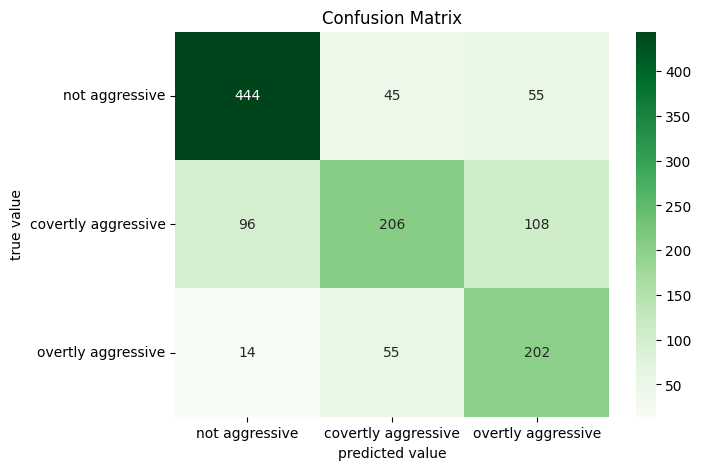

In [ ]:
# Generate test prompts and extract true labels
y_true = d3_test.loc[:, 'label']
X_test = pd.DataFrame(d3_test.apply(generate_test_prompt, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d3_test aggression prediction  without cyber bullying")
evaluate(y_true, y_pred)


  0%|          | 1/533 [00:00<05:13,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  0%|          | 2/533 [00:01<04:29,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 3/533 [00:01<04:15,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 4/533 [00:02<04:40,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 5/533 [00:02<04:26,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 6/533 [00:03<04:41,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|▏         | 7/533 [00:03<04:27,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 8/533 [00:04<04:16,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 9/533 [00:04<04:09,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 10/533 [00:05<04:27,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 11/533 [00:05<04:17,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 12/533 [00:06<04:12,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 13/533 [00:06<04:07,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 14/533 [00:06<04:02,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 15/533 [00:07<04:20,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 16/533 [00:08<04:36,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 17/533 [00:08<04:23,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 18/533 [00:09<04:37,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▎         | 19/533 [00:09<04:25,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 20/533 [00:10<04:15,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 21/533 [00:10<04:29,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▍         | 22/533 [00:11<04:18,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 23/533 [00:11<04:10,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 24/533 [00:12<04:25,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 25/533 [00:12<04:37,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 26/533 [00:13<04:43,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 27/533 [00:13<04:26,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 28/533 [00:14<04:13,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 29/533 [00:14<04:07,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 30/533 [00:15<04:02,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 31/533 [00:15<03:58,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 32/533 [00:16<03:55,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 33/533 [00:16<03:52,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 34/533 [00:17<03:50,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 35/533 [00:17<03:50,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 36/533 [00:17<03:50,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 37/533 [00:18<03:50,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 38/533 [00:19<04:10,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 39/533 [00:19<04:02,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 40/533 [00:19<03:56,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 41/533 [00:20<04:12,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 42/533 [00:21<04:23,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 43/533 [00:21<04:10,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 44/533 [00:22<04:01,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 45/533 [00:22<03:55,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▊         | 46/533 [00:22<03:51,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 47/533 [00:23<03:47,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 48/533 [00:23<03:49,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 49/533 [00:24<03:46,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 50/533 [00:24<03:44,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 51/533 [00:25<04:01,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 52/533 [00:25<03:53,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 53/533 [00:26<04:07,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 54/533 [00:27<04:19,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 55/533 [00:27<04:06,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 56/533 [00:27<03:56,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 57/533 [00:28<04:09,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 58/533 [00:28<03:57,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 59/533 [00:29<03:50,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█▏        | 60/533 [00:29<03:45,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█▏        | 61/533 [00:30<04:02,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 62/533 [00:30<03:54,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 63/533 [00:31<03:48,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 64/533 [00:31<03:45,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 65/533 [00:32<03:40,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 66/533 [00:32<03:37,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 67/533 [00:33<03:54,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 68/533 [00:33<03:47,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 69/533 [00:34<03:59,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 70/533 [00:34<03:49,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 71/533 [00:35<04:02,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▎        | 72/533 [00:35<03:51,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 73/533 [00:36<03:43,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 74/533 [00:36<03:56,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 75/533 [00:37<03:46,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 76/533 [00:37<03:40,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 77/533 [00:38<03:36,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 78/533 [00:38<03:33,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 79/533 [00:39<03:31,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 80/533 [00:39<03:28,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 81/533 [00:40<03:45,  2.01it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 82/533 [00:40<03:38,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 83/533 [00:41<03:52,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 84/533 [00:41<04:01,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 85/533 [00:42<04:07,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 86/533 [00:42<03:53,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 87/533 [00:43<03:43,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 88/533 [00:43<03:37,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 89/533 [00:44<03:51,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 90/533 [00:44<03:42,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 91/533 [00:45<03:34,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 92/533 [00:45<03:46,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 93/533 [00:46<03:56,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 94/533 [00:46<03:46,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 95/533 [00:47<03:37,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 96/533 [00:47<03:48,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 97/533 [00:48<03:38,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 98/533 [00:48<03:33,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▊        | 99/533 [00:49<03:45,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 100/533 [00:50<03:56,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 101/533 [00:50<03:43,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 102/533 [00:51<03:52,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 103/533 [00:51<03:58,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 104/533 [00:52<04:04,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 105/533 [00:52<03:49,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 106/533 [00:53<03:37,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 107/533 [00:53<03:30,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 108/533 [00:54<03:42,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 109/533 [00:54<03:33,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 110/533 [00:55<03:26,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 111/533 [00:55<03:21,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 112/533 [00:56<03:18,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 113/533 [00:56<03:15,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██▏       | 114/533 [00:56<03:12,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 115/533 [00:57<03:28,  2.01it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 116/533 [00:58<03:21,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 117/533 [00:58<03:33,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 118/533 [00:59<03:27,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 119/533 [00:59<03:20,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 120/533 [00:59<03:17,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 121/533 [01:00<03:30,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 122/533 [01:01<03:24,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 123/533 [01:01<03:35,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 124/533 [01:02<03:27,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 125/533 [01:02<03:37,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▎       | 126/533 [01:03<03:43,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 127/533 [01:03<03:33,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 128/533 [01:04<03:41,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 129/533 [01:04<03:29,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 130/533 [01:05<03:38,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 131/533 [01:06<03:48,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 132/533 [01:06<03:34,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 133/533 [01:07<03:40,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 134/533 [01:07<03:27,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 135/533 [01:08<03:36,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 136/533 [01:08<03:25,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 137/533 [01:09<03:32,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 138/533 [01:09<03:21,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 139/533 [01:10<03:29,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▋       | 140/533 [01:10<03:39,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▋       | 141/533 [01:11<03:26,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 142/533 [01:11<03:19,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 143/533 [01:12<03:28,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 144/533 [01:12<03:18,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 145/533 [01:13<03:11,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 146/533 [01:13<03:06,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 147/533 [01:14<03:02,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 148/533 [01:14<02:59,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 149/533 [01:15<02:57,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 150/533 [01:15<02:55,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 151/533 [01:15<02:55,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 152/533 [01:16<02:53,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 153/533 [01:16<02:55,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 154/533 [01:17<02:56,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 155/533 [01:17<02:54,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 156/533 [01:18<03:05,  2.03it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 157/533 [01:18<03:00,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 158/533 [01:19<03:10,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|██▉       | 159/533 [01:19<03:03,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 160/533 [01:20<02:57,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 161/533 [01:20<03:07,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 162/533 [01:21<03:15,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 163/533 [01:21<03:05,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 164/533 [01:22<02:58,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 165/533 [01:22<03:07,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 166/533 [01:23<02:58,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███▏      | 167/533 [01:23<02:52,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 168/533 [01:24<02:48,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 169/533 [01:24<02:45,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 170/533 [01:25<02:44,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 171/533 [01:25<02:42,  2.23it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 172/533 [01:25<02:41,  2.24it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 173/533 [01:26<02:54,  2.06it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 174/533 [01:26<02:51,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 175/533 [01:27<02:47,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 176/533 [01:28<02:58,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 177/533 [01:28<02:51,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 178/533 [01:28<02:47,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 179/533 [01:29<02:43,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 180/533 [01:29<02:41,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 181/533 [01:30<02:39,  2.20it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 182/533 [01:30<02:38,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 183/533 [01:31<02:38,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 184/533 [01:31<02:37,  2.22it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 185/533 [01:32<02:35,  2.24it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 186/533 [01:32<02:34,  2.25it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 187/533 [01:33<02:47,  2.07it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 188/533 [01:33<02:42,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 189/533 [01:34<02:53,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 190/533 [01:34<02:45,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 191/533 [01:34<02:42,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 192/533 [01:35<02:52,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 193/533 [01:35<02:46,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▋      | 194/533 [01:36<02:40,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 195/533 [01:36<02:50,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 196/533 [01:37<02:43,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 197/533 [01:37<02:37,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 198/533 [01:38<02:33,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 199/533 [01:38<02:44,  2.03it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 200/533 [01:39<02:39,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 201/533 [01:39<02:35,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 202/533 [01:40<02:32,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 203/533 [01:40<02:29,  2.20it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 204/533 [01:41<02:27,  2.22it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 205/533 [01:41<02:40,  2.05it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▊      | 206/533 [01:42<02:34,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 207/533 [01:42<02:30,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 208/533 [01:42<02:28,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 209/533 [01:43<02:25,  2.22it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 210/533 [01:43<02:25,  2.22it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 211/533 [01:44<02:23,  2.24it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 212/533 [01:44<02:22,  2.25it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 213/533 [01:45<02:21,  2.26it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 214/533 [01:45<02:20,  2.27it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 215/533 [01:46<02:19,  2.27it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 216/533 [01:46<02:19,  2.27it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 217/533 [01:47<02:33,  2.06it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 218/533 [01:47<02:43,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 219/533 [01:48<02:35,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 220/533 [01:48<02:42,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████▏     | 221/533 [01:49<02:47,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 222/533 [01:49<02:38,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 223/533 [01:50<02:33,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 224/533 [01:50<02:28,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 225/533 [01:51<02:25,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 226/533 [01:51<02:23,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 227/533 [01:51<02:21,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 228/533 [01:52<02:32,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 229/533 [01:53<02:27,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 230/533 [01:53<02:23,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 231/533 [01:54<02:33,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▎     | 232/533 [01:54<02:28,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▎     | 233/533 [01:54<02:23,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 234/533 [01:55<02:20,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 235/533 [01:55<02:18,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 236/533 [01:56<02:28,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 237/533 [01:57<02:34,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 238/533 [01:57<02:26,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 239/533 [01:57<02:22,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 240/533 [01:58<02:31,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 241/533 [01:58<02:25,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 242/533 [01:59<02:20,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 243/533 [01:59<02:29,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 244/533 [02:00<02:23,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 245/533 [02:00<02:18,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 246/533 [02:01<02:26,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▋     | 247/533 [02:01<02:22,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 248/533 [02:02<02:18,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 249/533 [02:02<02:15,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 250/533 [02:03<02:24,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 251/533 [02:03<02:20,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 252/533 [02:04<02:19,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 253/533 [02:04<02:15,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 254/533 [02:05<02:12,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 255/533 [02:05<02:22,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 256/533 [02:06<02:16,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 257/533 [02:06<02:12,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 258/533 [02:07<02:09,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▊     | 259/533 [02:07<02:07,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 260/533 [02:08<02:05,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 261/533 [02:08<02:15,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 262/533 [02:09<02:11,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 263/533 [02:09<02:18,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 264/533 [02:10<02:13,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 265/533 [02:10<02:09,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 266/533 [02:11<02:05,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 267/533 [02:11<02:02,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 268/533 [02:12<02:12,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|█████     | 269/533 [02:12<02:07,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 270/533 [02:13<02:04,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 271/533 [02:13<02:11,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 272/533 [02:14<02:08,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 273/533 [02:14<02:16,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████▏    | 274/533 [02:15<02:20,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 275/533 [02:15<02:25,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 276/533 [02:16<02:16,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 277/533 [02:16<02:11,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 278/533 [02:17<02:05,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 279/533 [02:17<02:02,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 280/533 [02:18<01:59,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 281/533 [02:18<01:58,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 282/533 [02:19<01:56,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 283/533 [02:19<01:54,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 284/533 [02:20<02:04,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 285/533 [02:20<02:11,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▎    | 286/533 [02:21<02:05,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 287/533 [02:21<02:00,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 288/533 [02:22<02:08,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 289/533 [02:22<02:02,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 290/533 [02:23<01:58,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 291/533 [02:23<01:55,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 292/533 [02:24<01:54,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 293/533 [02:24<01:52,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 294/533 [02:24<01:50,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 295/533 [02:25<01:59,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 296/533 [02:25<01:55,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 297/533 [02:26<01:52,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 298/533 [02:26<01:50,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 299/533 [02:27<01:49,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 300/533 [02:27<01:48,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 301/533 [02:28<01:46,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 302/533 [02:28<01:46,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 303/533 [02:29<01:54,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 304/533 [02:29<01:51,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 305/533 [02:30<01:56,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 306/533 [02:30<02:01,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 307/533 [02:31<01:55,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 308/533 [02:31<01:51,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 309/533 [02:32<01:48,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 310/533 [02:32<01:56,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 311/533 [02:33<02:00,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 312/533 [02:34<02:02,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 313/533 [02:34<01:55,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 314/533 [02:34<01:49,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 315/533 [02:35<01:45,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 316/533 [02:36<01:52,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 317/533 [02:36<01:46,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 318/533 [02:36<01:44,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 319/533 [02:37<01:41,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 320/533 [02:37<01:39,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 321/533 [02:38<01:38,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 322/533 [02:38<01:46,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 323/533 [02:39<01:51,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 324/533 [02:40<01:55,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████    | 325/533 [02:40<01:48,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 326/533 [02:40<01:43,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████▏   | 327/533 [02:41<01:48,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 328/533 [02:42<01:43,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 329/533 [02:42<01:39,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 330/533 [02:42<01:37,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 331/533 [02:43<01:34,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 332/533 [02:43<01:33,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 333/533 [02:44<01:40,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 334/533 [02:44<01:36,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 335/533 [02:45<01:34,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 336/533 [02:45<01:32,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 337/533 [02:46<01:30,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 338/533 [02:46<01:28,  2.20it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▎   | 339/533 [02:47<01:27,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 340/533 [02:47<01:27,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 341/533 [02:48<01:26,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 342/533 [02:48<01:26,  2.22it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 343/533 [02:49<01:33,  2.03it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 344/533 [02:49<01:31,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 345/533 [02:50<01:38,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 346/533 [02:50<01:34,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 347/533 [02:51<01:38,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▌   | 348/533 [02:51<01:33,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 349/533 [02:52<01:38,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 350/533 [02:52<01:33,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 351/533 [02:53<01:36,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 352/533 [02:53<01:31,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 353/533 [02:54<01:35,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▋   | 354/533 [02:54<01:30,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 355/533 [02:55<01:27,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 356/533 [02:55<01:25,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 357/533 [02:56<01:23,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 358/533 [02:56<01:29,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 359/533 [02:57<01:25,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 360/533 [02:57<01:22,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 361/533 [02:58<01:21,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 362/533 [02:58<01:20,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 363/533 [02:58<01:18,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 364/533 [02:59<01:17,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 365/533 [02:59<01:16,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 366/533 [03:00<01:15,  2.20it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 367/533 [03:00<01:22,  2.02it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 69%|██████▉   | 368/533 [03:01<01:21,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 369/533 [03:01<01:19,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 370/533 [03:02<01:24,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 371/533 [03:02<01:20,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|██████▉   | 372/533 [03:03<01:24,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 373/533 [03:03<01:20,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 374/533 [03:04<01:18,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 375/533 [03:04<01:16,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 376/533 [03:05<01:13,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 377/533 [03:05<01:18,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 378/533 [03:06<01:16,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 379/533 [03:06<01:20,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████▏  | 380/533 [03:07<01:22,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████▏  | 381/533 [03:08<01:24,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 382/533 [03:08<01:25,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 383/533 [03:09<01:19,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 384/533 [03:09<01:21,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 385/533 [03:10<01:16,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 386/533 [03:10<01:14,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 387/533 [03:11<01:11,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 388/533 [03:11<01:08,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 389/533 [03:12<01:07,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 390/533 [03:12<01:07,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 391/533 [03:13<01:12,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▎  | 392/533 [03:13<01:10,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▎  | 393/533 [03:14<01:13,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 394/533 [03:14<01:15,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 395/533 [03:15<01:11,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 396/533 [03:15<01:14,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 397/533 [03:16<01:09,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▍  | 398/533 [03:16<01:12,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 399/533 [03:17<01:14,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 400/533 [03:17<01:09,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 401/533 [03:18<01:06,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 402/533 [03:18<01:09,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 403/533 [03:19<01:11,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 404/533 [03:20<01:06,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 405/533 [03:20<01:04,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 406/533 [03:20<01:01,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▋  | 407/533 [03:21<01:00,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 408/533 [03:21<00:59,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 409/533 [03:22<01:03,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 410/533 [03:22<01:00,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 411/533 [03:23<00:58,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 412/533 [03:23<00:58,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 413/533 [03:24<00:57,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 414/533 [03:24<00:55,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 415/533 [03:25<00:54,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 416/533 [03:25<00:54,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 417/533 [03:26<00:53,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 418/533 [03:26<00:57,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▊  | 419/533 [03:27<00:54,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 420/533 [03:27<00:53,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 421/533 [03:28<00:52,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 422/533 [03:28<00:51,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 423/533 [03:28<00:50,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 424/533 [03:29<00:50,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 425/533 [03:29<00:49,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 426/533 [03:30<00:48,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 427/533 [03:30<00:52,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 428/533 [03:31<00:50,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 429/533 [03:31<00:49,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 430/533 [03:32<00:52,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 431/533 [03:32<00:50,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 432/533 [03:33<00:48,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 433/533 [03:33<00:47,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████▏ | 434/533 [03:34<00:46,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 435/533 [03:34<00:49,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 436/533 [03:35<00:47,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 437/533 [03:35<00:46,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 438/533 [03:36<00:44,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 439/533 [03:36<00:43,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 440/533 [03:37<00:46,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 83%|████████▎ | 441/533 [03:37<00:44,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 442/533 [03:38<00:43,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 443/533 [03:38<00:42,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 444/533 [03:39<00:41,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 445/533 [03:39<00:40,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 446/533 [03:39<00:39,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 447/533 [03:40<00:38,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 448/533 [03:40<00:39,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 449/533 [03:41<00:41,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 450/533 [03:41<00:40,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 451/533 [03:42<00:38,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 452/533 [03:42<00:38,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 453/533 [03:43<00:37,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 454/533 [03:43<00:36,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 455/533 [03:44<00:35,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 456/533 [03:44<00:35,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 457/533 [03:45<00:34,  2.20it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 458/533 [03:45<00:37,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 459/533 [03:46<00:36,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▋ | 460/533 [03:46<00:34,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▋ | 461/533 [03:47<00:37,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 462/533 [03:47<00:35,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 463/533 [03:48<00:34,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 464/533 [03:48<00:36,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 465/533 [03:49<00:34,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 466/533 [03:49<00:33,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 467/533 [03:50<00:31,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 468/533 [03:50<00:30,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 469/533 [03:51<00:29,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 470/533 [03:51<00:29,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 471/533 [03:51<00:28,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▊ | 472/533 [03:52<00:30,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▊ | 473/533 [03:53<00:31,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 474/533 [03:53<00:30,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 475/533 [03:54<00:28,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 476/533 [03:54<00:27,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 477/533 [03:55<00:26,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 478/533 [03:55<00:25,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 479/533 [03:55<00:24,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 480/533 [03:56<00:24,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 481/533 [03:56<00:23,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 482/533 [03:57<00:23,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 483/533 [03:57<00:23,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 484/533 [03:58<00:24,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 485/533 [03:58<00:23,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 486/533 [03:59<00:24,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████▏| 487/533 [03:59<00:23,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 488/533 [04:00<00:22,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 489/533 [04:00<00:23,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 490/533 [04:01<00:21,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 491/533 [04:01<00:22,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 492/533 [04:02<00:20,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 493/533 [04:02<00:19,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 494/533 [04:03<00:18,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 495/533 [04:03<00:18,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 496/533 [04:04<00:17,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 497/533 [04:04<00:16,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 498/533 [04:05<00:16,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 499/533 [04:05<00:15,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 500/533 [04:06<00:15,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 501/533 [04:06<00:16,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▍| 502/533 [04:07<00:15,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 503/533 [04:07<00:15,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 504/533 [04:08<00:14,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 505/533 [04:08<00:13,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 506/533 [04:09<00:13,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 507/533 [04:09<00:12,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 508/533 [04:10<00:12,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 509/533 [04:10<00:12,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 510/533 [04:11<00:12,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▌| 511/533 [04:11<00:11,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 512/533 [04:12<00:10,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 513/533 [04:12<00:09,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 514/533 [04:13<00:09,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 515/533 [04:13<00:08,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 516/533 [04:14<00:08,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 97%|█████████▋| 517/533 [04:14<00:07,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 518/533 [04:15<00:07,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 519/533 [04:15<00:07,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 520/533 [04:16<00:07,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 521/533 [04:16<00:06,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 522/533 [04:17<00:05,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 523/533 [04:17<00:05,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 524/533 [04:18<00:04,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 525/533 [04:18<00:04,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 526/533 [04:19<00:03,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 527/533 [04:19<00:02,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 528/533 [04:20<00:02,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 529/533 [04:21<00:02,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 530/533 [04:21<00:01,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|█████████▉| 531/533 [04:21<00:00,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|█████████▉| 532/533 [04:22<00:00,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|██████████| 533/533 [04:22<00:00,  2.03it/s]

Predicted answer: not aggressive
d4_test aggression prediction  without cyber bullying
Accuracy: 0.745
Accuracy for label not aggressive: 0.816
Accuracy for label covertly aggressive: 0.241
Accuracy for label overtly aggressive: 0.737

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.90      0.82      0.86       418
covertly aggressive       0.36      0.24      0.29        58
 overtly aggressive       0.37      0.74      0.49        57

           accuracy                           0.74       533
          macro avg       0.54      0.60      0.54       533
       weighted avg       0.78      0.74      0.75       533


Confusion Matrix:
[[341  21  56]
 [ 27  14  17]
 [ 11   4  42]]


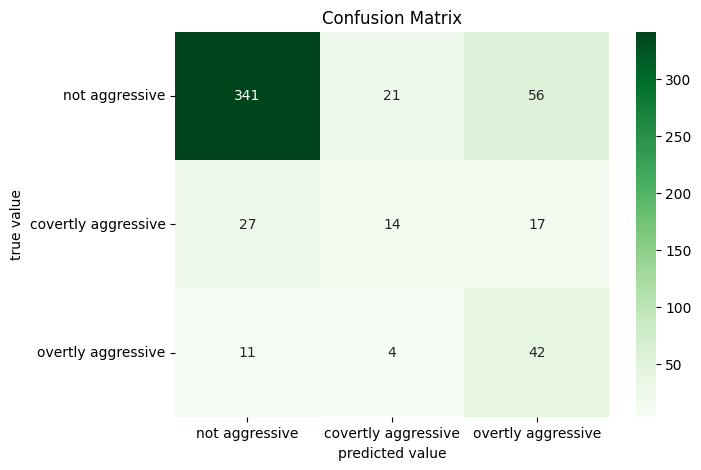

In [ ]:
# Generate test prompts and extract true labels
y_true = d4_test.loc[:, 'label']
X_test = pd.DataFrame(d4_test.apply(generate_test_prompt, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d4_test aggression prediction  without cyber bullying")
evaluate(y_true, y_pred)


  0%|          | 1/1493 [00:00<15:37,  1.59it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 2/1493 [00:01<13:03,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  0%|          | 3/1493 [00:01<13:46,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  0%|          | 4/1493 [00:02<12:45,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


  0%|          | 5/1493 [00:02<13:33,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 6/1493 [00:03<13:53,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 7/1493 [00:03<12:58,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 8/1493 [00:04<12:23,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 9/1493 [00:04<11:59,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 10/1493 [00:05<12:46,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 11/1493 [00:05<12:32,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 12/1493 [00:06<12:10,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 13/1493 [00:06<11:57,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 14/1493 [00:07<12:42,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 15/1493 [00:07<13:21,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 16/1493 [00:08<12:41,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 17/1493 [00:08<13:18,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 18/1493 [00:09<13:39,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|▏         | 19/1493 [00:10<13:52,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|▏         | 20/1493 [00:10<14:04,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|▏         | 21/1493 [00:11<14:06,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|▏         | 22/1493 [00:11<14:12,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 23/1493 [00:12<14:17,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 24/1493 [00:13<14:17,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 25/1493 [00:13<14:21,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 26/1493 [00:14<13:18,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 27/1493 [00:14<12:37,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 28/1493 [00:15<13:04,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 29/1493 [00:15<12:27,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 30/1493 [00:16<12:57,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 31/1493 [00:16<12:27,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 32/1493 [00:17<13:08,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 33/1493 [00:17<13:24,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 34/1493 [00:18<13:51,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 35/1493 [00:18<14:05,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 36/1493 [00:19<14:16,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 37/1493 [00:20<13:17,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 38/1493 [00:20<12:37,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 39/1493 [00:20<12:06,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 40/1493 [00:21<11:49,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 41/1493 [00:22<12:31,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 42/1493 [00:22<13:05,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 43/1493 [00:23<13:26,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 44/1493 [00:23<12:41,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 45/1493 [00:24<12:10,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 46/1493 [00:24<12:55,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 47/1493 [00:25<13:18,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 48/1493 [00:25<13:35,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 49/1493 [00:26<12:52,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 50/1493 [00:26<13:18,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 51/1493 [00:27<13:32,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 52/1493 [00:28<13:36,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▎         | 53/1493 [00:28<12:59,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▎         | 54/1493 [00:29<13:18,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▎         | 55/1493 [00:29<12:38,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 56/1493 [00:30<12:06,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 57/1493 [00:30<11:51,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 58/1493 [00:31<12:30,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 59/1493 [00:31<11:58,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 60/1493 [00:32<11:36,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 61/1493 [00:32<12:19,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 62/1493 [00:33<12:51,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 63/1493 [00:33<13:12,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 64/1493 [00:34<12:29,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 65/1493 [00:34<12:04,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 66/1493 [00:35<12:40,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 67/1493 [00:35<12:12,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 68/1493 [00:36<12:46,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 69/1493 [00:37<13:10,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 70/1493 [00:37<13:24,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 71/1493 [00:38<13:35,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▍         | 72/1493 [00:38<12:40,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 73/1493 [00:39<12:00,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 74/1493 [00:39<11:34,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 75/1493 [00:40<12:16,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 76/1493 [00:40<12:47,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▌         | 77/1493 [00:41<13:08,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▌         | 78/1493 [00:41<12:26,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 79/1493 [00:42<11:54,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 80/1493 [00:42<12:25,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 81/1493 [00:43<11:49,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 82/1493 [00:43<12:22,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 83/1493 [00:44<12:47,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 84/1493 [00:44<13:02,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 85/1493 [00:45<13:14,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 86/1493 [00:46<13:23,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 87/1493 [00:46<13:32,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 88/1493 [00:47<12:38,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 89/1493 [00:47<12:01,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 90/1493 [00:48<12:33,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 91/1493 [00:48<12:59,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 92/1493 [00:49<13:24,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 93/1493 [00:49<12:30,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 94/1493 [00:50<12:50,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▋         | 95/1493 [00:51<13:06,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▋         | 96/1493 [00:51<12:27,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 97/1493 [00:52<11:54,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 98/1493 [00:52<11:30,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 99/1493 [00:52<11:15,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 100/1493 [00:53<12:02,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 101/1493 [00:53<11:35,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 102/1493 [00:54<12:14,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 103/1493 [00:55<12:40,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 104/1493 [00:55<12:59,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 105/1493 [00:56<13:11,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 106/1493 [00:56<13:23,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 107/1493 [00:57<13:29,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 108/1493 [00:58<13:24,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 109/1493 [00:58<13:33,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 110/1493 [00:59<13:33,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 111/1493 [00:59<13:48,  1.67it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 112/1493 [01:00<13:49,  1.66it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 113/1493 [01:01<12:47,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 114/1493 [01:01<13:01,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 115/1493 [01:02<12:16,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 116/1493 [01:02<11:43,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 117/1493 [01:03<12:14,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 118/1493 [01:03<11:41,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 119/1493 [01:04<12:19,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 120/1493 [01:04<12:43,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 121/1493 [01:05<11:57,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 122/1493 [01:05<11:27,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 123/1493 [01:06<12:02,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 124/1493 [01:06<11:34,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 125/1493 [01:07<12:06,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 126/1493 [01:07<12:27,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▊         | 127/1493 [01:08<12:45,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▊         | 128/1493 [01:09<13:00,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▊         | 129/1493 [01:09<13:10,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▊         | 130/1493 [01:10<13:20,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 131/1493 [01:10<12:28,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 132/1493 [01:11<12:43,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 133/1493 [01:11<12:53,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 134/1493 [01:12<13:07,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 135/1493 [01:12<12:12,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 136/1493 [01:13<12:43,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 137/1493 [01:14<12:56,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 138/1493 [01:14<13:04,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 139/1493 [01:15<13:09,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 140/1493 [01:15<13:14,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 141/1493 [01:16<13:21,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 142/1493 [01:17<13:18,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|▉         | 143/1493 [01:17<13:15,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 144/1493 [01:18<12:16,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 145/1493 [01:18<12:42,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 146/1493 [01:19<12:51,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|▉         | 147/1493 [01:19<12:56,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|▉         | 148/1493 [01:20<13:01,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 149/1493 [01:21<13:06,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 150/1493 [01:21<13:08,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 151/1493 [01:22<13:08,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 152/1493 [01:22<13:04,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 153/1493 [01:23<13:03,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 154/1493 [01:24<13:06,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 155/1493 [01:24<13:19,  1.67it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 156/1493 [01:25<13:17,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 157/1493 [01:25<13:14,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 158/1493 [01:26<12:19,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 159/1493 [01:26<12:32,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 160/1493 [01:27<12:43,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 161/1493 [01:28<12:50,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 162/1493 [01:28<12:57,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 163/1493 [01:29<13:07,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 164/1493 [01:29<13:02,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 165/1493 [01:30<13:08,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 166/1493 [01:31<13:04,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 167/1493 [01:31<13:02,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█▏        | 168/1493 [01:32<12:05,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█▏        | 169/1493 [01:32<11:26,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█▏        | 170/1493 [01:33<12:02,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█▏        | 171/1493 [01:33<12:28,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 172/1493 [01:34<12:42,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 173/1493 [01:34<11:57,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 174/1493 [01:35<12:18,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 175/1493 [01:36<12:28,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 176/1493 [01:36<11:41,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 177/1493 [01:37<11:57,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 178/1493 [01:37<12:10,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 179/1493 [01:38<11:27,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 180/1493 [01:38<11:50,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 181/1493 [01:39<12:13,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 182/1493 [01:39<12:26,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 183/1493 [01:40<12:36,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 184/1493 [01:40<11:44,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 185/1493 [01:41<11:59,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 186/1493 [01:42<12:13,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 187/1493 [01:42<11:31,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 188/1493 [01:42<10:59,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 189/1493 [01:43<11:32,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 190/1493 [01:44<11:01,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 191/1493 [01:44<11:33,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 192/1493 [01:45<11:55,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 193/1493 [01:45<12:10,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 194/1493 [01:46<11:26,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 195/1493 [01:46<11:48,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 196/1493 [01:47<12:08,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 197/1493 [01:48<12:18,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 198/1493 [01:48<12:29,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 199/1493 [01:49<12:31,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 200/1493 [01:49<12:32,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 201/1493 [01:50<11:40,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 202/1493 [01:50<12:04,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▎        | 203/1493 [01:51<12:23,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▎        | 204/1493 [01:52<12:28,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▎        | 205/1493 [01:52<11:39,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 206/1493 [01:53<11:53,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 207/1493 [01:53<12:08,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 208/1493 [01:54<11:22,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 209/1493 [01:54<10:51,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 210/1493 [01:55<10:28,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 211/1493 [01:55<11:06,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 212/1493 [01:56<11:30,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 213/1493 [01:56<11:47,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 214/1493 [01:57<11:58,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 215/1493 [01:57<12:03,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 216/1493 [01:58<12:12,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 217/1493 [01:59<11:24,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 218/1493 [01:59<11:43,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 219/1493 [02:00<11:56,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 220/1493 [02:00<12:06,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 221/1493 [02:01<11:20,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 222/1493 [02:01<11:39,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 223/1493 [02:02<10:59,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 224/1493 [02:02<10:40,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 225/1493 [02:03<11:20,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 226/1493 [02:03<11:37,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 227/1493 [02:04<10:59,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 228/1493 [02:04<11:26,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▌        | 229/1493 [02:05<11:43,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▌        | 230/1493 [02:06<11:02,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 231/1493 [02:06<11:26,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 232/1493 [02:07<11:41,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 233/1493 [02:07<11:56,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 234/1493 [02:08<12:03,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 235/1493 [02:08<11:16,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 236/1493 [02:09<11:34,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 237/1493 [02:09<11:42,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 238/1493 [02:10<10:59,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 239/1493 [02:11<11:22,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 240/1493 [02:11<11:38,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 241/1493 [02:12<11:48,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 242/1493 [02:12<12:01,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▋        | 243/1493 [02:13<11:13,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 244/1493 [02:13<10:38,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 245/1493 [02:14<10:11,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 246/1493 [02:14<10:47,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 247/1493 [02:15<10:18,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 248/1493 [02:15<10:55,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 249/1493 [02:16<11:16,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 250/1493 [02:16<11:31,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 251/1493 [02:17<11:40,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 252/1493 [02:17<10:56,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 253/1493 [02:18<11:19,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 254/1493 [02:19<11:42,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 255/1493 [02:19<11:48,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 256/1493 [02:20<11:02,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 257/1493 [02:20<10:29,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 258/1493 [02:21<10:58,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 259/1493 [02:21<10:28,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 260/1493 [02:22<11:02,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 261/1493 [02:22<11:21,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 262/1493 [02:23<10:42,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 263/1493 [02:23<10:21,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 264/1493 [02:24<10:05,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 265/1493 [02:24<10:39,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 266/1493 [02:25<10:13,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 267/1493 [02:25<10:47,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 268/1493 [02:26<11:20,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 269/1493 [02:27<11:29,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 270/1493 [02:27<11:38,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 271/1493 [02:28<10:52,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 272/1493 [02:28<11:10,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 273/1493 [02:29<10:31,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 274/1493 [02:29<10:59,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 275/1493 [02:30<11:14,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 276/1493 [02:30<11:28,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▊        | 277/1493 [02:31<11:35,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▊        | 278/1493 [02:32<11:43,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▊        | 279/1493 [02:32<11:48,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 280/1493 [02:33<11:52,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 281/1493 [02:33<11:51,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 282/1493 [02:34<12:03,  1.67it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 283/1493 [02:35<12:06,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 284/1493 [02:35<12:01,  1.67it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 285/1493 [02:36<11:57,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 286/1493 [02:36<11:59,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 287/1493 [02:37<11:05,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 288/1493 [02:37<10:29,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 289/1493 [02:38<11:00,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 290/1493 [02:38<10:24,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 291/1493 [02:39<10:45,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 292/1493 [02:39<10:57,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 293/1493 [02:40<10:17,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 294/1493 [02:41<10:43,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 295/1493 [02:41<11:00,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 296/1493 [02:42<11:25,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 297/1493 [02:42<10:43,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 298/1493 [02:43<10:59,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 299/1493 [02:43<11:11,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 300/1493 [02:44<11:19,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 301/1493 [02:45<11:24,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 302/1493 [02:45<10:36,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 303/1493 [02:46<10:52,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 304/1493 [02:46<10:25,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 305/1493 [02:47<10:46,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 306/1493 [02:47<10:12,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 307/1493 [02:48<10:36,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 308/1493 [02:48<10:56,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██        | 309/1493 [02:49<11:07,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 310/1493 [02:49<11:18,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██        | 311/1493 [02:50<11:23,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 312/1493 [02:51<11:26,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██        | 313/1493 [02:51<11:30,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 314/1493 [02:52<11:29,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 315/1493 [02:52<11:29,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 316/1493 [02:53<10:36,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 317/1493 [02:53<10:00,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██▏       | 318/1493 [02:54<10:21,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██▏       | 319/1493 [02:54<09:54,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██▏       | 320/1493 [02:55<09:33,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 321/1493 [02:55<09:22,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 322/1493 [02:56<09:12,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 323/1493 [02:56<09:52,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 324/1493 [02:57<10:19,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 325/1493 [02:57<10:42,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 326/1493 [02:58<10:08,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 327/1493 [02:58<10:31,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 328/1493 [02:59<09:58,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 329/1493 [02:59<10:23,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 330/1493 [03:00<10:40,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 331/1493 [03:01<10:02,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 332/1493 [03:01<10:28,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 333/1493 [03:02<09:57,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 334/1493 [03:02<09:37,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 335/1493 [03:03<10:09,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 336/1493 [03:03<10:29,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 337/1493 [03:04<10:43,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 338/1493 [03:04<10:15,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 339/1493 [03:05<09:46,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 340/1493 [03:05<09:24,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 341/1493 [03:06<09:10,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 342/1493 [03:06<09:50,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 343/1493 [03:07<09:27,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 344/1493 [03:07<09:58,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 345/1493 [03:08<10:23,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 346/1493 [03:08<09:48,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 347/1493 [03:09<09:22,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 348/1493 [03:09<09:06,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 349/1493 [03:10<08:55,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 350/1493 [03:10<08:50,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 351/1493 [03:11<09:31,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▎       | 352/1493 [03:11<09:13,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 353/1493 [03:12<09:00,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 354/1493 [03:12<09:41,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 355/1493 [03:13<09:23,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 356/1493 [03:13<10:00,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 357/1493 [03:14<10:23,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 358/1493 [03:14<10:38,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 359/1493 [03:15<10:53,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 360/1493 [03:16<11:01,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 361/1493 [03:16<11:05,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 362/1493 [03:17<11:02,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 363/1493 [03:17<11:02,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 364/1493 [03:18<11:01,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 365/1493 [03:19<11:00,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 366/1493 [03:19<11:04,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 367/1493 [03:20<10:59,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 368/1493 [03:20<10:11,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 369/1493 [03:21<10:25,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 370/1493 [03:21<09:47,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 371/1493 [03:22<10:07,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▍       | 372/1493 [03:22<10:17,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 373/1493 [03:23<10:26,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 374/1493 [03:24<10:36,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 375/1493 [03:24<10:44,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▌       | 376/1493 [03:25<10:49,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▌       | 377/1493 [03:25<10:52,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 378/1493 [03:26<10:06,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 379/1493 [03:26<10:22,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 380/1493 [03:27<09:45,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 381/1493 [03:27<10:07,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 382/1493 [03:28<09:34,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 383/1493 [03:28<09:57,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 384/1493 [03:29<10:12,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 385/1493 [03:30<10:25,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 386/1493 [03:30<10:31,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 387/1493 [03:31<10:34,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 388/1493 [03:31<10:44,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 389/1493 [03:32<09:59,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 390/1493 [03:32<10:16,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 391/1493 [03:33<10:24,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▋       | 392/1493 [03:33<09:44,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▋       | 393/1493 [03:34<10:04,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▋       | 394/1493 [03:35<10:11,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▋       | 395/1493 [03:35<10:17,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 396/1493 [03:36<10:25,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 397/1493 [03:36<10:33,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 398/1493 [03:37<10:34,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 399/1493 [03:37<09:49,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 400/1493 [03:38<09:16,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 401/1493 [03:38<09:03,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 402/1493 [03:39<08:47,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 403/1493 [03:39<09:24,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 404/1493 [03:40<09:47,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 405/1493 [03:41<10:01,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 406/1493 [03:41<09:30,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 407/1493 [03:42<09:50,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 408/1493 [03:42<10:02,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 409/1493 [03:43<10:11,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 410/1493 [03:43<10:21,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 411/1493 [03:44<10:23,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 412/1493 [03:45<10:25,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 413/1493 [03:45<10:26,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 414/1493 [03:46<10:23,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 415/1493 [03:46<10:24,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 416/1493 [03:47<10:25,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 417/1493 [03:47<10:28,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 418/1493 [03:48<09:43,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 419/1493 [03:48<09:55,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 420/1493 [03:49<10:06,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 421/1493 [03:49<09:27,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 422/1493 [03:50<09:57,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 423/1493 [03:51<09:21,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 424/1493 [03:51<09:39,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 425/1493 [03:52<09:06,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 426/1493 [03:52<09:30,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▊       | 427/1493 [03:53<09:04,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 428/1493 [03:53<08:49,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 429/1493 [03:54<09:18,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 430/1493 [03:54<09:37,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 431/1493 [03:55<09:53,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 432/1493 [03:55<09:19,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 433/1493 [03:56<09:46,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 434/1493 [03:57<09:57,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 435/1493 [03:57<09:21,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 436/1493 [03:58<09:38,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 437/1493 [03:58<09:50,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 438/1493 [03:59<09:57,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 439/1493 [03:59<10:15,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 440/1493 [04:00<10:16,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|██▉       | 441/1493 [04:00<09:33,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 442/1493 [04:01<09:03,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 443/1493 [04:01<08:40,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 444/1493 [04:02<08:25,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 445/1493 [04:02<09:00,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|██▉       | 446/1493 [04:03<09:21,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|██▉       | 447/1493 [04:03<09:35,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|███       | 448/1493 [04:04<09:03,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 449/1493 [04:05<09:24,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 450/1493 [04:05<09:37,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 451/1493 [04:06<09:00,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 452/1493 [04:06<09:17,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 453/1493 [04:07<09:28,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 454/1493 [04:07<08:57,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 455/1493 [04:08<09:15,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 456/1493 [04:08<09:30,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 457/1493 [04:09<08:58,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 458/1493 [04:09<09:14,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 459/1493 [04:10<09:32,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 460/1493 [04:11<09:41,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 461/1493 [04:11<09:49,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 462/1493 [04:12<09:12,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 463/1493 [04:12<08:47,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 464/1493 [04:12<08:28,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 465/1493 [04:13<08:14,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 466/1493 [04:14<08:46,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███▏      | 467/1493 [04:14<09:10,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███▏      | 468/1493 [04:15<09:21,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███▏      | 469/1493 [04:15<08:54,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███▏      | 470/1493 [04:16<09:13,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 471/1493 [04:16<09:34,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 472/1493 [04:17<09:41,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 473/1493 [04:18<09:45,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 474/1493 [04:18<09:54,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 475/1493 [04:19<09:51,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 476/1493 [04:19<09:58,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 477/1493 [04:20<09:54,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 478/1493 [04:20<09:55,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 479/1493 [04:21<09:13,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 480/1493 [04:21<09:26,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 481/1493 [04:22<09:34,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 482/1493 [04:23<08:57,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 483/1493 [04:23<09:13,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 484/1493 [04:24<09:24,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 485/1493 [04:24<08:53,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 486/1493 [04:25<09:11,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 487/1493 [04:25<09:22,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 488/1493 [04:26<09:33,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 489/1493 [04:26<08:58,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 490/1493 [04:27<08:32,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 491/1493 [04:27<08:54,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 492/1493 [04:28<09:09,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 493/1493 [04:29<09:18,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 494/1493 [04:29<08:49,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 495/1493 [04:30<09:06,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 496/1493 [04:30<09:18,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 497/1493 [04:31<08:45,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 498/1493 [04:31<09:02,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 499/1493 [04:32<09:19,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 500/1493 [04:32<09:24,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▎      | 501/1493 [04:33<09:30,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▎      | 502/1493 [04:34<09:31,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▎      | 503/1493 [04:34<09:37,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 504/1493 [04:35<09:35,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 505/1493 [04:35<09:39,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 506/1493 [04:36<09:37,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 507/1493 [04:37<09:36,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 508/1493 [04:37<09:35,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 509/1493 [04:38<09:34,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 510/1493 [04:38<08:52,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 511/1493 [04:39<09:02,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 512/1493 [04:39<08:31,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 513/1493 [04:40<08:09,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 514/1493 [04:40<08:35,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 515/1493 [04:41<08:52,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▍      | 516/1493 [04:41<09:04,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 517/1493 [04:42<09:14,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▍      | 518/1493 [04:43<09:19,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 519/1493 [04:43<09:24,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▍      | 520/1493 [04:44<08:46,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 521/1493 [04:44<08:18,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 522/1493 [04:45<08:36,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 523/1493 [04:45<08:49,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 524/1493 [04:46<09:02,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 525/1493 [04:46<09:08,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 526/1493 [04:47<09:14,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 527/1493 [04:47<08:45,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 528/1493 [04:48<08:57,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 529/1493 [04:49<09:06,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 530/1493 [04:49<08:31,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 531/1493 [04:50<08:47,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 532/1493 [04:50<09:04,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 533/1493 [04:51<08:29,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 534/1493 [04:51<08:43,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 535/1493 [04:52<08:13,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 536/1493 [04:52<08:31,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 537/1493 [04:53<08:45,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 538/1493 [04:54<08:55,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 539/1493 [04:54<08:26,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 540/1493 [04:54<08:02,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 541/1493 [04:55<08:25,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▋      | 542/1493 [04:56<08:41,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▋      | 543/1493 [04:56<08:56,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▋      | 544/1493 [04:57<09:05,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 545/1493 [04:57<09:13,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 546/1493 [04:58<09:17,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 547/1493 [04:58<08:38,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 548/1493 [04:59<08:52,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 549/1493 [05:00<08:59,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 550/1493 [05:00<08:28,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 551/1493 [05:01<08:40,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 552/1493 [05:01<08:49,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 553/1493 [05:02<08:56,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 554/1493 [05:02<08:22,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 555/1493 [05:03<07:57,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 556/1493 [05:03<07:40,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 557/1493 [05:04<08:07,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 558/1493 [05:04<08:28,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 559/1493 [05:05<08:40,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 560/1493 [05:06<08:45,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 561/1493 [05:06<08:52,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 562/1493 [05:07<08:56,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 563/1493 [05:07<08:23,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 564/1493 [05:08<07:57,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 565/1493 [05:08<08:20,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 566/1493 [05:09<08:34,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 567/1493 [05:09<08:44,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 568/1493 [05:10<08:54,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 569/1493 [05:11<08:58,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 570/1493 [05:11<08:22,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 571/1493 [05:12<07:56,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 572/1493 [05:12<07:39,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 573/1493 [05:12<07:25,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 574/1493 [05:13<07:14,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▊      | 575/1493 [05:14<07:47,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 39%|███▊      | 576/1493 [05:14<07:34,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▊      | 577/1493 [05:15<07:56,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▊      | 578/1493 [05:15<07:33,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 579/1493 [05:15<07:20,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 580/1493 [05:16<07:46,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 581/1493 [05:16<07:29,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 582/1493 [05:17<07:17,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 583/1493 [05:18<07:44,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 584/1493 [05:18<08:06,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 39%|███▉      | 585/1493 [05:19<08:21,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 586/1493 [05:19<07:51,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 587/1493 [05:20<07:30,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 588/1493 [05:20<07:16,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 589/1493 [05:21<07:45,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 590/1493 [05:21<08:11,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 591/1493 [05:22<08:26,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 592/1493 [05:22<08:36,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 593/1493 [05:23<08:52,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 594/1493 [05:24<08:13,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 595/1493 [05:24<07:53,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 596/1493 [05:24<07:31,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 597/1493 [05:25<07:18,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 598/1493 [05:25<07:45,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 599/1493 [05:26<08:02,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|████      | 600/1493 [05:27<07:37,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 601/1493 [05:27<07:19,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 602/1493 [05:28<07:42,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 603/1493 [05:28<07:59,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 604/1493 [05:29<07:32,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 605/1493 [05:29<07:56,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 606/1493 [05:30<07:34,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 607/1493 [05:30<07:55,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 608/1493 [05:31<08:10,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 609/1493 [05:31<08:22,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 610/1493 [05:32<08:30,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 611/1493 [05:33<08:33,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 612/1493 [05:33<08:35,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 613/1493 [05:34<08:34,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 614/1493 [05:34<08:04,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 615/1493 [05:35<08:13,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████▏     | 616/1493 [05:35<08:17,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████▏     | 617/1493 [05:36<08:20,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████▏     | 618/1493 [05:36<07:48,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 619/1493 [05:37<08:01,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 620/1493 [05:38<08:06,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 621/1493 [05:38<08:13,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 622/1493 [05:39<07:42,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 623/1493 [05:39<07:57,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 624/1493 [05:40<07:31,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 625/1493 [05:40<07:12,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 626/1493 [05:41<07:34,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 627/1493 [05:41<07:14,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 628/1493 [05:42<07:37,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 629/1493 [05:42<07:16,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 630/1493 [05:43<06:58,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 631/1493 [05:43<06:46,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 632/1493 [05:44<07:18,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 633/1493 [05:44<07:03,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 634/1493 [05:45<07:32,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 635/1493 [05:45<07:46,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 636/1493 [05:46<07:25,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 637/1493 [05:46<07:09,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 638/1493 [05:47<07:33,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 639/1493 [05:47<07:45,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 640/1493 [05:48<07:55,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 641/1493 [05:49<08:04,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 642/1493 [05:49<07:33,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 643/1493 [05:50<07:13,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 644/1493 [05:50<07:01,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 645/1493 [05:51<07:26,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 646/1493 [05:51<07:41,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 647/1493 [05:52<07:17,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 648/1493 [05:52<07:36,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 649/1493 [05:53<07:48,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▎     | 650/1493 [05:53<07:59,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▎     | 651/1493 [05:54<08:04,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▎     | 652/1493 [05:55<08:07,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▎     | 653/1493 [05:55<08:09,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 654/1493 [05:56<08:09,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 655/1493 [05:56<08:15,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 656/1493 [05:57<07:42,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 657/1493 [05:57<07:54,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 658/1493 [05:58<07:25,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 659/1493 [05:58<07:04,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 660/1493 [05:59<07:25,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 661/1493 [05:59<07:03,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 662/1493 [06:00<07:27,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 663/1493 [06:01<07:38,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 664/1493 [06:01<07:14,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 665/1493 [06:02<06:55,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 666/1493 [06:02<07:17,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 667/1493 [06:03<07:31,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 668/1493 [06:03<07:45,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 669/1493 [06:04<07:52,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▍     | 670/1493 [06:04<07:56,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▍     | 671/1493 [06:05<08:03,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 672/1493 [06:06<08:00,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 673/1493 [06:06<07:28,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 674/1493 [06:07<07:35,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 675/1493 [06:07<07:45,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▌     | 676/1493 [06:08<07:50,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▌     | 677/1493 [06:08<07:57,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▌     | 678/1493 [06:09<07:27,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 679/1493 [06:10<07:37,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 680/1493 [06:10<07:14,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 681/1493 [06:10<06:54,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 682/1493 [06:11<07:12,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 683/1493 [06:12<07:25,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 684/1493 [06:12<07:02,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 685/1493 [06:13<07:14,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 686/1493 [06:13<07:23,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 687/1493 [06:14<07:30,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 688/1493 [06:14<07:37,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 689/1493 [06:15<07:08,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 690/1493 [06:15<06:48,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 691/1493 [06:16<07:10,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▋     | 692/1493 [06:16<06:48,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 693/1493 [06:17<07:06,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▋     | 694/1493 [06:17<06:46,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 695/1493 [06:18<07:05,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 696/1493 [06:18<06:46,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 697/1493 [06:19<07:08,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 698/1493 [06:20<07:23,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 699/1493 [06:20<06:59,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 700/1493 [06:21<07:15,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 701/1493 [06:21<07:30,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 702/1493 [06:22<07:34,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 703/1493 [06:23<07:37,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 704/1493 [06:23<07:38,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 705/1493 [06:24<07:07,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 706/1493 [06:24<06:50,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 707/1493 [06:25<07:06,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 708/1493 [06:25<06:45,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 709/1493 [06:26<06:29,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 710/1493 [06:26<06:51,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 711/1493 [06:27<07:10,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 712/1493 [06:27<06:46,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 713/1493 [06:28<07:02,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 714/1493 [06:28<06:39,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 715/1493 [06:29<06:58,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 716/1493 [06:29<06:39,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 717/1493 [06:30<06:59,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 718/1493 [06:30<07:12,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 719/1493 [06:31<06:46,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 720/1493 [06:32<07:00,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 721/1493 [06:32<07:16,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 722/1493 [06:33<07:23,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 723/1493 [06:33<07:23,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 724/1493 [06:34<07:25,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▊     | 725/1493 [06:34<06:55,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▊     | 726/1493 [06:35<07:02,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▊     | 727/1493 [06:35<06:38,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 728/1493 [06:36<06:53,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 729/1493 [06:37<07:06,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 730/1493 [06:37<07:11,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 731/1493 [06:38<06:44,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 732/1493 [06:38<06:24,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 733/1493 [06:39<06:40,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 734/1493 [06:39<06:52,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 735/1493 [06:40<06:31,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 736/1493 [06:40<06:47,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 737/1493 [06:41<06:24,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 738/1493 [06:41<06:41,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 739/1493 [06:42<06:23,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 740/1493 [06:42<06:42,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 741/1493 [06:43<06:54,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 742/1493 [06:43<07:02,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 743/1493 [06:44<06:38,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 744/1493 [06:45<06:49,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|████▉     | 745/1493 [06:45<06:26,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 746/1493 [06:46<06:38,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 747/1493 [06:46<06:54,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 748/1493 [06:47<07:00,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 749/1493 [06:47<07:05,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 750/1493 [06:48<06:37,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 751/1493 [06:48<06:49,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|█████     | 752/1493 [06:49<06:57,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 753/1493 [06:50<06:58,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 754/1493 [06:50<07:04,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 755/1493 [06:51<07:05,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 756/1493 [06:51<06:36,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 757/1493 [06:52<06:48,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 758/1493 [06:52<06:26,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 759/1493 [06:53<06:38,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 760/1493 [06:53<06:20,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 761/1493 [06:54<06:04,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 762/1493 [06:54<06:24,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 763/1493 [06:55<06:07,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 764/1493 [06:55<05:59,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 765/1493 [06:56<05:49,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████▏    | 766/1493 [06:56<05:44,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████▏    | 767/1493 [06:57<06:09,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████▏    | 768/1493 [06:57<05:55,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 769/1493 [06:58<06:16,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 770/1493 [06:58<06:01,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 771/1493 [06:59<05:49,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 772/1493 [06:59<06:11,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 773/1493 [07:00<06:26,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 774/1493 [07:00<06:09,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 775/1493 [07:01<06:25,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 776/1493 [07:01<06:35,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 777/1493 [07:02<06:13,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 778/1493 [07:02<05:55,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 779/1493 [07:03<06:11,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 780/1493 [07:04<06:25,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 781/1493 [07:04<06:38,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 782/1493 [07:05<06:13,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 783/1493 [07:05<06:29,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 784/1493 [07:06<06:06,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 785/1493 [07:06<06:21,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 786/1493 [07:07<06:31,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 787/1493 [07:07<06:40,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 788/1493 [07:08<06:46,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 789/1493 [07:09<06:47,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 790/1493 [07:09<06:47,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 791/1493 [07:10<06:51,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 792/1493 [07:10<06:55,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 793/1493 [07:11<06:54,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 794/1493 [07:11<06:23,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 795/1493 [07:12<06:06,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 796/1493 [07:12<05:50,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 797/1493 [07:13<05:43,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 798/1493 [07:13<05:34,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 799/1493 [07:14<05:27,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 800/1493 [07:14<05:25,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 801/1493 [07:15<05:19,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 802/1493 [07:15<05:15,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 803/1493 [07:16<05:42,  2.02it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 804/1493 [07:16<06:00,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 805/1493 [07:17<06:13,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 806/1493 [07:17<06:21,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 807/1493 [07:18<06:28,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 808/1493 [07:18<06:05,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 809/1493 [07:19<06:16,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 810/1493 [07:19<05:55,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 811/1493 [07:20<06:10,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 812/1493 [07:21<06:19,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 813/1493 [07:21<05:56,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 814/1493 [07:22<06:08,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 815/1493 [07:22<06:16,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 816/1493 [07:23<06:19,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 817/1493 [07:23<06:25,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▍    | 818/1493 [07:24<06:00,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 819/1493 [07:24<06:11,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▍    | 820/1493 [07:25<06:20,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 821/1493 [07:26<06:24,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 822/1493 [07:26<06:30,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 823/1493 [07:27<06:31,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 824/1493 [07:27<06:03,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 825/1493 [07:28<06:12,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 826/1493 [07:28<05:50,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 827/1493 [07:29<05:34,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 828/1493 [07:29<05:23,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 829/1493 [07:30<05:44,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 830/1493 [07:30<05:58,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 831/1493 [07:31<06:08,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 832/1493 [07:31<05:45,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 833/1493 [07:32<05:57,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 834/1493 [07:33<06:05,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 835/1493 [07:33<05:44,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 836/1493 [07:34<05:54,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 837/1493 [07:34<05:34,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 838/1493 [07:35<05:46,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 839/1493 [07:35<05:29,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 840/1493 [07:36<05:43,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▋    | 841/1493 [07:36<05:30,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 842/1493 [07:37<05:18,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 843/1493 [07:37<05:37,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 844/1493 [07:38<05:47,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 845/1493 [07:38<05:59,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 846/1493 [07:39<06:05,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 847/1493 [07:40<06:09,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 848/1493 [07:40<05:45,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 849/1493 [07:40<05:27,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 850/1493 [07:41<05:41,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 851/1493 [07:42<05:52,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 852/1493 [07:42<05:58,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 853/1493 [07:43<06:01,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 854/1493 [07:43<06:06,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 855/1493 [07:44<06:08,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 856/1493 [07:45<06:09,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 857/1493 [07:45<06:09,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 858/1493 [07:46<05:43,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 859/1493 [07:46<05:51,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 860/1493 [07:47<05:30,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 861/1493 [07:47<05:17,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 862/1493 [07:48<05:32,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 863/1493 [07:48<05:42,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 864/1493 [07:49<05:47,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 865/1493 [07:49<05:29,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 866/1493 [07:50<05:39,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 867/1493 [07:50<05:49,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 868/1493 [07:51<05:53,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 869/1493 [07:52<05:31,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 870/1493 [07:52<05:16,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 871/1493 [07:53<05:30,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 872/1493 [07:53<05:41,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 873/1493 [07:54<05:47,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 874/1493 [07:54<05:54,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 875/1493 [07:55<05:54,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 876/1493 [07:55<05:34,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▊    | 877/1493 [07:56<05:41,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 878/1493 [07:56<05:21,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 879/1493 [07:57<05:07,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 880/1493 [07:57<05:23,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 881/1493 [07:58<05:37,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 882/1493 [07:58<05:18,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 883/1493 [07:59<05:31,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 884/1493 [08:00<05:38,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 885/1493 [08:00<05:50,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 886/1493 [08:01<05:26,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 887/1493 [08:01<05:10,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 888/1493 [08:02<05:00,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 889/1493 [08:02<05:16,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|█████▉    | 890/1493 [08:03<05:26,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 891/1493 [08:03<05:32,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 892/1493 [08:04<05:37,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 893/1493 [08:05<05:40,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|█████▉    | 894/1493 [08:05<05:18,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 895/1493 [08:06<05:25,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|██████    | 896/1493 [08:06<05:09,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 897/1493 [08:07<05:19,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 898/1493 [08:07<05:05,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 899/1493 [08:08<05:18,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 900/1493 [08:08<05:26,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|██████    | 901/1493 [08:09<05:30,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 902/1493 [08:09<05:11,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 903/1493 [08:10<05:21,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████    | 904/1493 [08:10<05:06,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 905/1493 [08:11<05:17,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 906/1493 [08:11<05:01,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 907/1493 [08:12<04:49,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 908/1493 [08:12<04:44,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 909/1493 [08:13<05:01,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 910/1493 [08:13<04:49,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 911/1493 [08:14<05:04,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 912/1493 [08:14<04:51,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 913/1493 [08:15<04:41,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 914/1493 [08:15<04:58,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████▏   | 915/1493 [08:16<05:11,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████▏   | 916/1493 [08:16<04:57,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████▏   | 917/1493 [08:17<05:10,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████▏   | 918/1493 [08:18<05:19,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 919/1493 [08:18<05:23,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 920/1493 [08:19<05:24,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 921/1493 [08:19<05:03,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 922/1493 [08:20<05:11,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 923/1493 [08:20<05:21,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 924/1493 [08:21<05:26,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 925/1493 [08:22<05:28,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 926/1493 [08:22<05:06,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 927/1493 [08:23<04:50,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 928/1493 [08:23<05:03,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 929/1493 [08:24<05:10,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 930/1493 [08:24<05:17,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 931/1493 [08:25<04:55,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 932/1493 [08:25<05:03,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 933/1493 [08:26<05:08,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 934/1493 [08:26<04:49,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 935/1493 [08:27<04:35,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 936/1493 [08:27<04:52,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 937/1493 [08:28<05:05,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 938/1493 [08:29<05:11,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 939/1493 [08:29<05:14,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 940/1493 [08:30<05:17,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 941/1493 [08:30<05:20,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 942/1493 [08:31<04:58,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 943/1493 [08:31<04:45,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 944/1493 [08:32<04:33,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 945/1493 [08:32<04:49,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 946/1493 [08:33<05:00,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 947/1493 [08:33<04:43,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 948/1493 [08:34<04:33,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▎   | 949/1493 [08:34<04:48,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▎   | 950/1493 [08:35<04:55,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▎   | 951/1493 [08:35<04:39,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 952/1493 [08:36<04:51,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 953/1493 [08:37<04:58,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 954/1493 [08:37<05:04,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 955/1493 [08:38<05:06,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 956/1493 [08:38<04:48,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 957/1493 [08:39<04:33,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 958/1493 [08:39<04:48,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 959/1493 [08:40<04:56,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 960/1493 [08:40<05:04,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 961/1493 [08:41<05:09,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 962/1493 [08:42<05:08,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 963/1493 [08:42<04:46,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 964/1493 [08:43<04:53,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 965/1493 [08:43<04:57,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 966/1493 [08:44<04:38,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 967/1493 [08:44<04:52,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 968/1493 [08:45<04:35,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 969/1493 [08:45<04:47,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 970/1493 [08:46<04:55,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▌   | 971/1493 [08:46<04:39,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 972/1493 [08:47<04:47,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▌   | 973/1493 [08:48<04:52,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▌   | 974/1493 [08:48<04:58,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▌   | 975/1493 [08:49<04:39,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 976/1493 [08:49<04:24,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 977/1493 [08:50<04:36,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 978/1493 [08:50<04:45,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 979/1493 [08:51<04:49,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 980/1493 [08:52<04:52,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 981/1493 [08:52<04:33,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 982/1493 [08:53<04:40,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 983/1493 [08:53<04:50,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 984/1493 [08:54<04:52,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 985/1493 [08:54<04:31,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 986/1493 [08:55<04:16,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 987/1493 [08:55<04:06,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 988/1493 [08:56<04:01,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 989/1493 [08:56<03:55,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 990/1493 [08:56<03:52,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 991/1493 [08:57<04:12,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▋   | 992/1493 [08:58<04:24,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 993/1493 [08:58<04:32,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 994/1493 [08:59<04:39,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 995/1493 [08:59<04:43,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 996/1493 [09:00<04:46,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 997/1493 [09:00<04:27,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 998/1493 [09:01<04:33,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 999/1493 [09:02<04:38,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 1000/1493 [09:02<04:23,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 1001/1493 [09:03<04:10,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 1002/1493 [09:03<04:22,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 1003/1493 [09:04<04:29,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 1004/1493 [09:04<04:34,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 1005/1493 [09:05<04:17,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 1006/1493 [09:05<04:05,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 1007/1493 [09:06<04:18,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1008/1493 [09:06<04:06,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 1009/1493 [09:07<04:17,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1010/1493 [09:07<04:05,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 1011/1493 [09:08<04:15,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 1012/1493 [09:08<04:23,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1013/1493 [09:09<04:08,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 1014/1493 [09:09<03:59,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 1015/1493 [09:10<04:16,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 1016/1493 [09:11<04:23,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1017/1493 [09:11<04:30,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1018/1493 [09:12<04:32,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 1019/1493 [09:12<04:36,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 1020/1493 [09:13<04:36,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1021/1493 [09:14<04:35,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1022/1493 [09:14<04:18,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 1023/1493 [09:14<04:03,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 1024/1493 [09:15<04:13,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▊   | 1025/1493 [09:16<04:19,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 69%|██████▊   | 1026/1493 [09:16<04:04,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1027/1493 [09:17<03:54,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1028/1493 [09:17<04:07,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▉   | 1029/1493 [09:18<03:55,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1030/1493 [09:18<03:47,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1031/1493 [09:18<03:41,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1032/1493 [09:19<03:57,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▉   | 1033/1493 [09:20<04:06,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 69%|██████▉   | 1034/1493 [09:20<03:53,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1035/1493 [09:21<03:45,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1036/1493 [09:21<03:38,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1037/1493 [09:22<03:52,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 1038/1493 [09:22<04:01,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 1039/1493 [09:23<04:08,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 1040/1493 [09:23<04:12,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 1041/1493 [09:24<04:16,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 1042/1493 [09:25<04:20,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 1043/1493 [09:25<04:22,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 1044/1493 [09:26<04:20,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 1045/1493 [09:26<04:19,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 1046/1493 [09:27<04:19,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 1047/1493 [09:27<04:18,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 1048/1493 [09:28<04:03,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 1049/1493 [09:29<04:08,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 1050/1493 [09:29<04:14,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 1051/1493 [09:30<04:15,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 1052/1493 [09:30<04:16,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1053/1493 [09:31<04:19,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1054/1493 [09:31<04:16,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1055/1493 [09:32<04:14,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 1056/1493 [09:33<04:13,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1057/1493 [09:33<04:17,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 1058/1493 [09:34<04:16,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 1059/1493 [09:34<04:16,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1060/1493 [09:35<04:16,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 1061/1493 [09:36<04:16,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1062/1493 [09:36<04:16,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1063/1493 [09:37<03:57,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████▏  | 1064/1493 [09:37<04:02,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████▏  | 1065/1493 [09:38<03:46,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████▏  | 1066/1493 [09:38<03:55,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████▏  | 1067/1493 [09:39<04:00,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 1068/1493 [09:39<03:47,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 1069/1493 [09:40<03:58,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1070/1493 [09:41<04:02,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1071/1493 [09:41<04:05,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1072/1493 [09:42<04:05,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1073/1493 [09:42<04:04,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 1074/1493 [09:43<04:03,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 1075/1493 [09:43<03:45,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 1076/1493 [09:44<03:50,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 1077/1493 [09:45<03:52,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1078/1493 [09:45<03:39,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 1079/1493 [09:45<03:27,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 1080/1493 [09:46<03:36,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1081/1493 [09:46<03:25,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 1082/1493 [09:47<03:35,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1083/1493 [09:48<03:43,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1084/1493 [09:48<03:47,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1085/1493 [09:49<03:34,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1086/1493 [09:49<03:25,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1087/1493 [09:50<03:18,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1088/1493 [09:50<03:30,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1089/1493 [09:51<03:38,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1090/1493 [09:51<03:27,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1091/1493 [09:52<03:34,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 73%|███████▎  | 1092/1493 [09:52<03:23,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1093/1493 [09:53<03:31,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 73%|███████▎  | 1094/1493 [09:53<03:38,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1095/1493 [09:54<03:25,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1096/1493 [09:54<03:34,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1097/1493 [09:55<03:39,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▎  | 1098/1493 [09:56<03:41,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▎  | 1099/1493 [09:56<03:43,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▎  | 1100/1493 [09:57<03:45,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▎  | 1101/1493 [09:57<03:47,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 1102/1493 [09:58<03:49,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 1103/1493 [09:58<03:33,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 1104/1493 [09:59<03:22,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 1105/1493 [09:59<03:15,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 1106/1493 [10:00<03:24,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 1107/1493 [10:00<03:15,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 1108/1493 [10:01<03:25,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 1109/1493 [10:02<03:30,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 1110/1493 [10:02<03:34,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 1111/1493 [10:03<03:37,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 1112/1493 [10:03<03:39,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 1113/1493 [10:04<03:40,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▍  | 1114/1493 [10:05<03:39,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 1115/1493 [10:05<03:23,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▍  | 1116/1493 [10:06<03:27,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▍  | 1117/1493 [10:06<03:31,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▍  | 1118/1493 [10:07<03:18,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▍  | 1119/1493 [10:07<03:23,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▌  | 1120/1493 [10:08<03:12,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 1121/1493 [10:08<03:19,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▌  | 1122/1493 [10:09<03:24,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 1123/1493 [10:09<03:29,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 1124/1493 [10:10<03:31,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 1125/1493 [10:11<03:31,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 1126/1493 [10:11<03:18,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 1127/1493 [10:12<03:21,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 1128/1493 [10:12<03:09,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 1129/1493 [10:13<03:14,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 1130/1493 [10:13<03:20,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 1131/1493 [10:14<03:22,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 1132/1493 [10:14<03:25,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 1133/1493 [10:15<03:28,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 1134/1493 [10:15<03:13,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 1135/1493 [10:16<03:02,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 1136/1493 [10:16<02:54,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 1137/1493 [10:17<03:04,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 1138/1493 [10:17<03:09,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▋  | 1139/1493 [10:18<03:00,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▋  | 1140/1493 [10:19<03:07,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▋  | 1141/1493 [10:19<03:10,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▋  | 1142/1493 [10:20<02:58,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 1143/1493 [10:20<03:05,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 1144/1493 [10:21<02:55,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 1145/1493 [10:21<03:03,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 1146/1493 [10:22<03:07,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1147/1493 [10:22<02:57,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 1148/1493 [10:23<03:03,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1149/1493 [10:23<03:09,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1150/1493 [10:24<03:11,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1151/1493 [10:24<03:12,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1152/1493 [10:25<03:15,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 1153/1493 [10:26<03:15,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1154/1493 [10:26<03:02,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 1155/1493 [10:27<03:04,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1156/1493 [10:27<02:52,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 1157/1493 [10:28<02:57,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1158/1493 [10:28<02:49,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 1159/1493 [10:29<02:42,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 1160/1493 [10:29<02:51,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1161/1493 [10:30<02:43,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 1162/1493 [10:30<02:54,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1163/1493 [10:31<02:58,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1164/1493 [10:31<03:02,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1165/1493 [10:32<03:05,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 1166/1493 [10:32<03:06,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 1167/1493 [10:33<03:06,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1168/1493 [10:34<02:53,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 1169/1493 [10:34<02:56,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1170/1493 [10:35<02:46,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 1171/1493 [10:35<02:52,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1172/1493 [10:36<02:43,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▊  | 1173/1493 [10:36<02:49,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▊  | 1174/1493 [10:37<02:54,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▊  | 1175/1493 [10:37<02:57,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1176/1493 [10:38<02:59,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1177/1493 [10:38<03:00,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 1178/1493 [10:39<02:47,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 1179/1493 [10:39<02:51,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1180/1493 [10:40<02:54,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1181/1493 [10:41<02:43,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 1182/1493 [10:41<02:48,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 1183/1493 [10:42<02:52,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1184/1493 [10:42<02:55,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 1185/1493 [10:43<02:57,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1186/1493 [10:43<02:44,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 1187/1493 [10:44<02:48,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|███████▉  | 1188/1493 [10:44<02:39,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 1189/1493 [10:45<02:32,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 1190/1493 [10:45<02:38,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|███████▉  | 1191/1493 [10:46<02:44,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|███████▉  | 1192/1493 [10:47<02:48,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|███████▉  | 1193/1493 [10:47<02:50,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|███████▉  | 1194/1493 [10:48<02:51,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 1195/1493 [10:48<02:41,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 1196/1493 [10:49<02:44,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|████████  | 1197/1493 [10:49<02:47,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|████████  | 1198/1493 [10:50<02:49,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|████████  | 1199/1493 [10:50<02:36,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 1200/1493 [10:51<02:40,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 1201/1493 [10:51<02:31,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1202/1493 [10:52<02:24,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1203/1493 [10:53<02:31,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 1204/1493 [10:53<02:24,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1205/1493 [10:54<02:33,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 1206/1493 [10:54<02:25,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1207/1493 [10:55<02:29,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 1208/1493 [10:55<02:34,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 1209/1493 [10:56<02:37,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 1210/1493 [10:56<02:27,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1211/1493 [10:57<02:30,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 1212/1493 [10:57<02:21,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1213/1493 [10:58<02:27,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████▏ | 1214/1493 [10:58<02:31,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████▏ | 1215/1493 [10:59<02:23,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████▏ | 1216/1493 [10:59<02:27,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1217/1493 [11:00<02:19,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1218/1493 [11:00<02:25,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1219/1493 [11:01<02:29,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 1220/1493 [11:01<02:19,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1221/1493 [11:02<02:26,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 1222/1493 [11:03<02:29,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1223/1493 [11:03<02:20,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1224/1493 [11:03<02:13,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1225/1493 [11:04<02:19,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1226/1493 [11:05<02:23,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1227/1493 [11:05<02:26,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 1228/1493 [11:06<02:17,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1229/1493 [11:06<02:12,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1230/1493 [11:07<02:17,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1231/1493 [11:07<02:21,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1232/1493 [11:08<02:23,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 83%|████████▎ | 1233/1493 [11:08<02:24,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 83%|████████▎ | 1234/1493 [11:09<02:15,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1235/1493 [11:09<02:19,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 83%|████████▎ | 1236/1493 [11:10<02:23,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1237/1493 [11:10<02:13,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1238/1493 [11:11<02:17,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1239/1493 [11:12<02:20,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1240/1493 [11:12<02:21,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1241/1493 [11:13<02:22,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1242/1493 [11:13<02:22,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1243/1493 [11:14<02:12,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1244/1493 [11:14<02:04,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1245/1493 [11:15<01:58,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1246/1493 [11:15<01:56,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 1247/1493 [11:16<02:03,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▎ | 1248/1493 [11:16<01:58,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 1249/1493 [11:17<02:03,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▎ | 1250/1493 [11:17<01:58,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1251/1493 [11:18<02:03,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1252/1493 [11:18<02:09,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1253/1493 [11:19<02:12,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1254/1493 [11:19<02:04,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1255/1493 [11:20<02:08,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1256/1493 [11:21<02:10,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 1257/1493 [11:21<02:01,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1258/1493 [11:21<01:56,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1259/1493 [11:22<01:51,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1260/1493 [11:22<01:59,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1261/1493 [11:23<01:52,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 1262/1493 [11:23<01:58,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1263/1493 [11:24<02:01,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1264/1493 [11:24<01:54,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 1265/1493 [11:25<01:59,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1266/1493 [11:26<02:01,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1267/1493 [11:26<02:04,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▍ | 1268/1493 [11:27<02:04,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▍ | 1269/1493 [11:27<02:05,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▌ | 1270/1493 [11:28<01:57,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1271/1493 [11:28<02:00,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▌ | 1272/1493 [11:29<01:53,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1273/1493 [11:29<01:47,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1274/1493 [11:30<01:52,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▌ | 1275/1493 [11:30<01:46,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1276/1493 [11:31<01:42,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1277/1493 [11:31<01:40,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1278/1493 [11:31<01:37,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1279/1493 [11:32<01:44,  2.04it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 1280/1493 [11:33<01:41,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1281/1493 [11:33<01:46,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 1282/1493 [11:34<01:50,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 1283/1493 [11:34<01:53,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1284/1493 [11:35<01:47,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1285/1493 [11:35<01:51,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1286/1493 [11:36<01:45,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1287/1493 [11:36<01:51,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 1288/1493 [11:37<01:53,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▋ | 1289/1493 [11:38<01:54,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 1290/1493 [11:38<01:56,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▋ | 1291/1493 [11:39<01:56,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1292/1493 [11:39<01:48,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1293/1493 [11:40<01:48,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1294/1493 [11:40<01:41,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1295/1493 [11:41<01:37,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1296/1493 [11:41<01:41,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1297/1493 [11:42<01:44,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1298/1493 [11:42<01:46,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1299/1493 [11:43<01:47,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1300/1493 [11:43<01:40,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1301/1493 [11:44<01:43,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1302/1493 [11:44<01:45,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1303/1493 [11:45<01:38,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1304/1493 [11:46<01:41,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1305/1493 [11:46<01:43,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1306/1493 [11:47<01:37,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 1307/1493 [11:47<01:39,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1308/1493 [11:48<01:41,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1309/1493 [11:48<01:42,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1310/1493 [11:49<01:42,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1311/1493 [11:49<01:35,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 1312/1493 [11:50<01:30,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 1313/1493 [11:50<01:35,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1314/1493 [11:51<01:37,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1315/1493 [11:51<01:33,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 1316/1493 [11:52<01:37,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1317/1493 [11:53<01:39,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1318/1493 [11:53<01:40,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1319/1493 [11:54<01:40,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1320/1493 [11:54<01:40,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1321/1493 [11:55<01:39,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▊ | 1322/1493 [11:55<01:39,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▊ | 1323/1493 [11:56<01:31,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▊ | 1324/1493 [11:57<01:34,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 89%|████████▊ | 1325/1493 [11:57<01:34,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1326/1493 [11:58<01:28,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1327/1493 [11:58<01:24,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1328/1493 [11:58<01:20,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1329/1493 [11:59<01:18,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1330/1493 [12:00<01:23,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1331/1493 [12:00<01:27,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1332/1493 [12:01<01:21,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1333/1493 [12:01<01:27,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 89%|████████▉ | 1334/1493 [12:02<01:28,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 89%|████████▉ | 1335/1493 [12:02<01:23,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1336/1493 [12:03<01:25,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 1337/1493 [12:03<01:27,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|████████▉ | 1338/1493 [12:04<01:27,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 1339/1493 [12:04<01:20,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 1340/1493 [12:05<01:22,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|████████▉ | 1341/1493 [12:06<01:23,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 1342/1493 [12:06<01:25,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 1343/1493 [12:07<01:25,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1344/1493 [12:07<01:25,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|█████████ | 1345/1493 [12:08<01:19,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 1346/1493 [12:08<01:20,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1347/1493 [12:09<01:15,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 1348/1493 [12:09<01:18,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|█████████ | 1349/1493 [12:10<01:19,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|█████████ | 1350/1493 [12:11<01:20,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|█████████ | 1351/1493 [12:11<01:20,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1352/1493 [12:12<01:20,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1353/1493 [12:12<01:20,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1354/1493 [12:13<01:13,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1355/1493 [12:13<01:15,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1356/1493 [12:14<01:16,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1357/1493 [12:14<01:17,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 1358/1493 [12:15<01:17,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1359/1493 [12:16<01:10,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1360/1493 [12:16<01:12,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1361/1493 [12:17<01:12,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 1362/1493 [12:17<01:13,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████▏| 1363/1493 [12:18<01:13,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████▏| 1364/1493 [12:18<01:08,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████▏| 1365/1493 [12:19<01:09,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████▏| 1366/1493 [12:19<01:10,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 1367/1493 [12:20<01:05,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1368/1493 [12:20<01:02,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1369/1493 [12:21<00:59,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1370/1493 [12:21<01:03,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1371/1493 [12:22<01:04,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 1372/1493 [12:22<01:05,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1373/1493 [12:23<01:02,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1374/1493 [12:24<01:03,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 1375/1493 [12:24<00:59,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1376/1493 [12:24<00:57,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1377/1493 [12:25<00:54,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1378/1493 [12:25<00:57,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1379/1493 [12:26<00:55,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1380/1493 [12:26<00:58,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 1381/1493 [12:27<00:55,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1382/1493 [12:27<00:53,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1383/1493 [12:28<00:51,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1384/1493 [12:28<00:49,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1385/1493 [12:29<00:52,  2.04it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1386/1493 [12:29<00:55,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1387/1493 [12:30<00:56,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1388/1493 [12:30<00:53,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1389/1493 [12:31<00:54,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1390/1493 [12:31<00:51,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1391/1493 [12:32<00:53,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1392/1493 [12:33<00:54,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1393/1493 [12:33<00:55,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1394/1493 [12:34<00:51,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1395/1493 [12:34<00:52,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▎| 1396/1493 [12:35<00:53,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▎| 1397/1493 [12:35<00:53,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▎| 1398/1493 [12:36<00:49,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 1399/1493 [12:36<00:50,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1400/1493 [12:37<00:50,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1401/1493 [12:37<00:47,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1402/1493 [12:38<00:48,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▍| 1403/1493 [12:38<00:49,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▍| 1404/1493 [12:39<00:50,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1405/1493 [12:40<00:46,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1406/1493 [12:40<00:47,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1407/1493 [12:41<00:48,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▍| 1408/1493 [12:41<00:44,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1409/1493 [12:42<00:42,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1410/1493 [12:42<00:44,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▍| 1411/1493 [12:43<00:41,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 1412/1493 [12:43<00:42,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1413/1493 [12:44<00:43,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▍| 1414/1493 [12:44<00:44,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1415/1493 [12:45<00:43,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1416/1493 [12:46<00:43,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1417/1493 [12:46<00:43,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1418/1493 [12:47<00:42,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1419/1493 [12:47<00:41,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▌| 1420/1493 [12:48<00:41,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1421/1493 [12:48<00:40,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1422/1493 [12:49<00:40,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1423/1493 [12:49<00:37,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 1424/1493 [12:50<00:37,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1425/1493 [12:51<00:37,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▌| 1426/1493 [12:51<00:34,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1427/1493 [12:51<00:32,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1428/1493 [12:52<00:31,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1429/1493 [12:52<00:30,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1430/1493 [12:53<00:29,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1431/1493 [12:53<00:28,  2.20it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1432/1493 [12:54<00:29,  2.04it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1433/1493 [12:54<00:30,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1434/1493 [12:55<00:31,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1435/1493 [12:55<00:29,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1436/1493 [12:56<00:30,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1437/1493 [12:56<00:28,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 1438/1493 [12:57<00:28,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▋| 1439/1493 [12:57<00:27,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 1440/1493 [12:58<00:25,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1441/1493 [12:58<00:26,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1442/1493 [12:59<00:24,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1443/1493 [12:59<00:25,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1444/1493 [13:00<00:26,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 97%|█████████▋| 1445/1493 [13:01<00:26,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1446/1493 [13:01<00:24,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1447/1493 [13:02<00:22,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1448/1493 [13:02<00:23,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1449/1493 [13:03<00:21,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1450/1493 [13:03<00:20,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1451/1493 [13:03<00:19,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1452/1493 [13:04<00:18,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1453/1493 [13:04<00:19,  2.03it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1454/1493 [13:05<00:20,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1455/1493 [13:06<00:20,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1456/1493 [13:06<00:20,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1457/1493 [13:07<00:18,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1458/1493 [13:07<00:17,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1459/1493 [13:08<00:17,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1460/1493 [13:08<00:17,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1461/1493 [13:09<00:17,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1462/1493 [13:09<00:16,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1463/1493 [13:10<00:16,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1464/1493 [13:10<00:14,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1465/1493 [13:11<00:13,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1466/1493 [13:11<00:13,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1467/1493 [13:12<00:13,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1468/1493 [13:12<00:13,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1469/1493 [13:13<00:13,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1470/1493 [13:14<00:12,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▊| 1471/1493 [13:14<00:12,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▊| 1472/1493 [13:15<00:11,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▊| 1473/1493 [13:15<00:11,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 1474/1493 [13:16<00:10,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1475/1493 [13:16<00:10,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▉| 1476/1493 [13:17<00:09,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1477/1493 [13:17<00:08,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1478/1493 [13:18<00:08,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1479/1493 [13:19<00:07,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1480/1493 [13:19<00:06,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1481/1493 [13:20<00:06,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1482/1493 [13:20<00:06,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1483/1493 [13:21<00:05,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1484/1493 [13:21<00:05,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▉| 1485/1493 [13:22<00:04,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|█████████▉| 1486/1493 [13:22<00:03,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1487/1493 [13:23<00:03,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|█████████▉| 1488/1493 [13:24<00:02,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|█████████▉| 1489/1493 [13:24<00:02,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1490/1493 [13:25<00:01,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1491/1493 [13:25<00:01,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1492/1493 [13:26<00:00,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|██████████| 1493/1493 [13:27<00:00,  1.85it/s]

Predicted answer: overtly aggressive
d5_test aggression prediction  without cyber bullying
Accuracy: 0.630
Accuracy for label not aggressive: 0.648
Accuracy for label covertly aggressive: 0.559
Accuracy for label overtly aggressive: 0.704

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.77      0.65      0.70       616
covertly aggressive       0.55      0.56      0.56       522
 overtly aggressive       0.56      0.70      0.62       355

           accuracy                           0.63      1493
          macro avg       0.63      0.64      0.63      1493
       weighted avg       0.64      0.63      0.63      1493


Confusion Matrix:
[[399 151  66]
 [ 97 292 133]
 [ 20  85 250]]


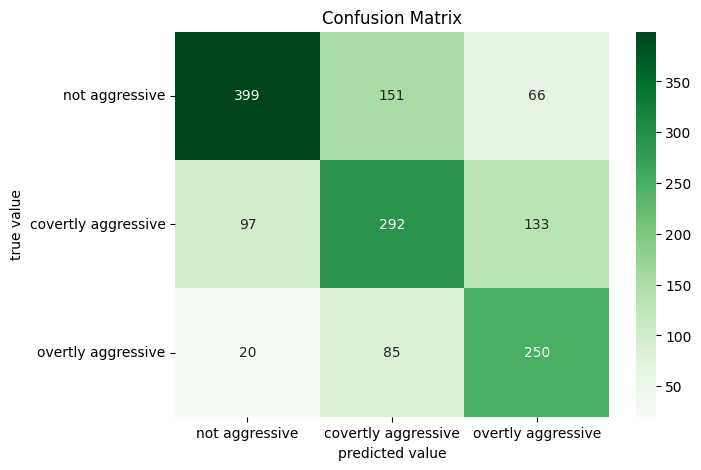

In [ ]:
# Generate test prompts and extract true labels
y_true = d5_test.loc[:, 'label']
X_test = pd.DataFrame(d5_test.apply(generate_test_prompt, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d5_test aggression prediction  without cyber bullying")
evaluate(y_true, y_pred)


In [ ]:
# Version 1: Confidence filtering + neutral language
def generate_test_prompt_cyb_detail_v2(row):
    confidence = row['confidence_cyb']
    cyb_type = row['predictions_cyb']

    # Only provide auxiliary info for high-confidence predictions
    if confidence >= 0.70:
        if cyb_type == 'not_cyberbullying':
            aux_info = f"Cyberbullying classifier: not cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'other_cyberbullying':
            aux_info = f"Cyberbullying classifier: other cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'age':
            aux_info = f"Cyberbullying classifier: age-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'religion':
            aux_info = f"Cyberbullying classifier: religion-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'ethnicity':
            aux_info = f"Cyberbullying classifier: ethnicity-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'gender':
            aux_info = f"Cyberbullying classifier: gender-related cyberbullying (confidence: {confidence:.2f})"
        else:
            aux_info = "Not provided"
    else:
        aux_info = "Not provided"

    return f"""You are a strict Aggression classifier.
Analyze the text and classify it into exactly one category:

The possible categories are:
- not aggressive: neutral or non-hostile statements
- covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks, subtle put-downs, indirect verbal attacks
- overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility

TEXT: "{row['text']}"

Auxiliary information: {aux_info}

CLASSIFICATION: """.strip()

  0%|          | 1/1225 [00:00<09:08,  2.23it/s]Device set to use cuda:0


Predicted answer: not aggressive


  0%|          | 2/1225 [00:00<09:23,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


  0%|          | 3/1225 [00:01<10:34,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 4/1225 [00:02<11:08,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 5/1225 [00:02<10:31,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


  0%|          | 6/1225 [00:03<10:05,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 7/1225 [00:03<10:41,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 8/1225 [00:04<11:01,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 9/1225 [00:04<11:16,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 10/1225 [00:05<11:26,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 11/1225 [00:05<10:49,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 12/1225 [00:06<11:17,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 13/1225 [00:07<11:25,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 14/1225 [00:07<11:33,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 15/1225 [00:08<11:40,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|▏         | 16/1225 [00:08<11:01,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|▏         | 17/1225 [00:09<11:17,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|▏         | 18/1225 [00:09<11:27,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 19/1225 [00:10<11:43,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 20/1225 [00:10<10:51,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 21/1225 [00:11<11:04,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 22/1225 [00:12<11:19,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 23/1225 [00:12<11:26,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 24/1225 [00:13<11:28,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 25/1225 [00:13<11:33,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 26/1225 [00:14<10:45,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 27/1225 [00:14<11:01,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 28/1225 [00:15<11:11,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 29/1225 [00:15<10:30,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 30/1225 [00:16<10:05,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 31/1225 [00:16<09:45,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 32/1225 [00:17<10:20,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 33/1225 [00:17<10:47,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 34/1225 [00:18<11:12,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 35/1225 [00:19<11:24,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 36/1225 [00:19<11:36,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 37/1225 [00:20<10:50,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 38/1225 [00:20<10:16,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 39/1225 [00:21<10:42,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 40/1225 [00:21<10:59,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 41/1225 [00:22<10:24,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 42/1225 [00:22<10:48,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▎         | 43/1225 [00:23<10:22,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▎         | 44/1225 [00:24<10:42,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▎         | 45/1225 [00:24<10:59,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 46/1225 [00:25<11:10,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 47/1225 [00:25<10:29,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 48/1225 [00:26<10:05,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 49/1225 [00:26<10:36,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▍         | 50/1225 [00:27<10:58,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▍         | 51/1225 [00:27<11:12,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 52/1225 [00:28<11:23,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▍         | 53/1225 [00:29<11:28,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▍         | 54/1225 [00:29<10:41,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 55/1225 [00:30<10:59,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▍         | 56/1225 [00:30<10:24,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 57/1225 [00:31<10:42,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 58/1225 [00:31<10:56,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▍         | 59/1225 [00:32<10:16,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 60/1225 [00:32<10:40,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 61/1225 [00:33<10:52,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 62/1225 [00:33<10:11,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 63/1225 [00:34<10:34,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▌         | 64/1225 [00:35<10:49,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 65/1225 [00:35<11:01,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 66/1225 [00:36<10:21,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 67/1225 [00:36<09:53,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 68/1225 [00:37<10:21,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 69/1225 [00:37<09:51,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 70/1225 [00:38<10:20,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 71/1225 [00:38<10:38,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 72/1225 [00:39<10:50,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 73/1225 [00:39<10:10,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 74/1225 [00:40<10:29,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 75/1225 [00:41<10:51,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 76/1225 [00:41<11:05,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▋         | 77/1225 [00:42<10:25,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 78/1225 [00:42<09:55,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 79/1225 [00:43<09:39,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 80/1225 [00:43<10:14,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 81/1225 [00:44<10:33,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 82/1225 [00:44<09:59,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 83/1225 [00:45<10:22,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 84/1225 [00:45<09:50,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 85/1225 [00:46<09:27,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 86/1225 [00:46<10:00,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 87/1225 [00:47<09:35,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 88/1225 [00:47<09:23,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 89/1225 [00:48<09:55,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 90/1225 [00:48<09:32,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 91/1225 [00:49<09:12,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 92/1225 [00:49<08:58,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 93/1225 [00:50<09:33,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 94/1225 [00:50<10:01,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 95/1225 [00:51<10:25,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 96/1225 [00:52<10:38,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 97/1225 [00:52<09:59,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 98/1225 [00:53<10:21,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 99/1225 [00:53<10:34,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 100/1225 [00:54<10:44,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 101/1225 [00:54<10:52,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 102/1225 [00:55<10:59,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 103/1225 [00:56<11:01,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 104/1225 [00:56<11:01,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▊         | 105/1225 [00:57<10:59,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▊         | 106/1225 [00:57<10:10,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▊         | 107/1225 [00:58<10:22,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 108/1225 [00:58<09:48,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 109/1225 [00:59<10:13,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 110/1225 [00:59<09:46,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 111/1225 [01:00<09:25,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 112/1225 [01:00<09:06,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 113/1225 [01:01<09:35,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 114/1225 [01:01<09:58,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 115/1225 [01:02<10:16,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 116/1225 [01:03<09:44,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 117/1225 [01:03<10:07,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 118/1225 [01:04<10:18,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|▉         | 119/1225 [01:04<09:42,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 120/1225 [01:05<10:04,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 121/1225 [01:05<10:20,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 122/1225 [01:06<10:30,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 123/1225 [01:07<10:36,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 124/1225 [01:07<10:46,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 125/1225 [01:08<10:02,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|█         | 126/1225 [01:08<09:31,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|█         | 127/1225 [01:09<09:54,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 128/1225 [01:09<10:14,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 129/1225 [01:10<10:25,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 130/1225 [01:10<10:30,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 131/1225 [01:11<10:32,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 132/1225 [01:11<09:49,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 133/1225 [01:12<09:23,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 134/1225 [01:12<09:03,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 135/1225 [01:13<09:33,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 136/1225 [01:13<09:11,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 137/1225 [01:14<09:38,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█▏        | 138/1225 [01:15<10:00,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█▏        | 139/1225 [01:15<10:18,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█▏        | 140/1225 [01:16<09:40,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 141/1225 [01:16<09:14,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 142/1225 [01:17<09:43,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 143/1225 [01:17<09:23,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 144/1225 [01:18<09:55,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 145/1225 [01:18<09:27,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 146/1225 [01:19<09:02,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 147/1225 [01:19<09:27,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 148/1225 [01:20<09:47,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 149/1225 [01:20<09:22,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 150/1225 [01:21<09:06,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 151/1225 [01:21<08:46,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 152/1225 [01:22<08:32,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 153/1225 [01:22<09:05,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 154/1225 [01:23<09:39,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 155/1225 [01:23<09:09,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 156/1225 [01:24<08:51,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 157/1225 [01:24<08:37,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 158/1225 [01:25<09:09,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 159/1225 [01:25<09:29,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 160/1225 [01:26<09:52,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 161/1225 [01:27<09:20,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 162/1225 [01:27<09:01,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 163/1225 [01:27<08:43,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 164/1225 [01:28<08:32,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 165/1225 [01:28<08:23,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 166/1225 [01:29<08:25,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 167/1225 [01:29<09:04,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▎        | 168/1225 [01:30<08:50,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 169/1225 [01:31<09:22,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 170/1225 [01:31<09:38,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 171/1225 [01:32<09:09,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 172/1225 [01:32<08:49,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 173/1225 [01:33<08:31,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 174/1225 [01:33<09:05,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 175/1225 [01:34<09:27,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 176/1225 [01:34<09:00,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 177/1225 [01:35<09:20,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 178/1225 [01:35<09:35,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 179/1225 [01:36<09:46,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 180/1225 [01:36<09:55,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 181/1225 [01:37<09:18,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 182/1225 [01:38<09:35,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▍        | 183/1225 [01:38<09:53,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▌        | 184/1225 [01:39<09:57,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 185/1225 [01:39<10:00,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 186/1225 [01:40<09:20,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 187/1225 [01:40<09:37,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 188/1225 [01:41<09:09,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 189/1225 [01:41<08:53,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 190/1225 [01:42<09:16,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 191/1225 [01:43<09:34,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 192/1225 [01:43<09:50,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 193/1225 [01:44<09:12,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 194/1225 [01:44<09:29,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 195/1225 [01:45<09:39,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 196/1225 [01:45<09:49,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 197/1225 [01:46<09:54,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 198/1225 [01:46<09:14,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 199/1225 [01:47<09:28,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▋        | 200/1225 [01:47<09:01,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 201/1225 [01:48<08:38,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 202/1225 [01:48<08:22,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 203/1225 [01:49<08:52,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 204/1225 [01:50<09:12,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 205/1225 [01:50<08:43,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 206/1225 [01:50<08:25,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 207/1225 [01:51<08:13,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 208/1225 [01:51<08:46,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 209/1225 [01:52<08:30,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 210/1225 [01:52<08:17,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 211/1225 [01:53<08:55,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 212/1225 [01:54<09:17,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 213/1225 [01:54<09:31,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 214/1225 [01:55<09:40,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 215/1225 [01:55<09:47,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 216/1225 [01:56<09:51,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 217/1225 [01:57<09:52,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 218/1225 [01:57<09:52,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 219/1225 [01:58<09:12,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 220/1225 [01:58<09:22,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 221/1225 [01:59<08:48,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 222/1225 [01:59<09:08,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 223/1225 [02:00<08:39,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 224/1225 [02:00<09:04,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 225/1225 [02:01<08:36,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 226/1225 [02:01<08:57,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▊        | 227/1225 [02:02<09:09,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▊        | 228/1225 [02:03<09:23,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▊        | 229/1225 [02:03<08:52,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 230/1225 [02:04<09:05,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 231/1225 [02:04<08:36,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 232/1225 [02:05<08:15,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 233/1225 [02:05<07:59,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 234/1225 [02:06<08:33,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 235/1225 [02:06<08:18,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 236/1225 [02:06<08:02,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 237/1225 [02:07<07:49,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 238/1225 [02:07<07:45,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 239/1225 [02:08<07:40,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 240/1225 [02:08<08:13,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 241/1225 [02:09<08:37,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 242/1225 [02:10<08:55,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 243/1225 [02:10<09:06,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 244/1225 [02:11<08:33,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 245/1225 [02:11<08:53,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 246/1225 [02:12<09:03,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 247/1225 [02:12<09:13,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 248/1225 [02:13<09:22,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 249/1225 [02:14<09:26,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 250/1225 [02:14<08:49,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 251/1225 [02:15<08:28,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 252/1225 [02:15<08:10,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 253/1225 [02:16<08:34,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██        | 254/1225 [02:16<08:12,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 255/1225 [02:17<08:35,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 256/1225 [02:17<08:12,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 257/1225 [02:18<07:56,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 258/1225 [02:18<07:45,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 259/1225 [02:18<07:35,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 260/1225 [02:19<08:12,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██▏       | 261/1225 [02:19<07:52,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██▏       | 262/1225 [02:20<07:39,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██▏       | 263/1225 [02:20<08:11,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 264/1225 [02:21<07:53,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 265/1225 [02:22<08:19,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 266/1225 [02:22<08:38,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 267/1225 [02:23<08:53,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 268/1225 [02:23<08:21,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 269/1225 [02:24<08:38,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 270/1225 [02:24<08:14,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 271/1225 [02:25<07:55,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 272/1225 [02:25<08:24,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 273/1225 [02:26<08:44,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 274/1225 [02:26<08:20,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 275/1225 [02:27<08:38,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 276/1225 [02:27<08:14,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 277/1225 [02:28<08:37,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 278/1225 [02:29<08:50,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 279/1225 [02:29<08:20,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 280/1225 [02:29<07:58,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 281/1225 [02:30<08:22,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 282/1225 [02:31<08:01,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 283/1225 [02:31<07:45,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 284/1225 [02:32<08:09,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 285/1225 [02:32<07:49,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 286/1225 [02:33<08:18,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 287/1225 [02:33<07:56,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 288/1225 [02:34<07:40,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 289/1225 [02:34<08:06,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▎       | 290/1225 [02:35<08:24,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 291/1225 [02:35<08:39,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 292/1225 [02:36<08:09,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 293/1225 [02:36<07:48,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 294/1225 [02:37<07:33,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 295/1225 [02:37<08:00,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 296/1225 [02:38<08:18,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 297/1225 [02:38<08:30,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 298/1225 [02:39<08:00,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 299/1225 [02:39<07:38,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 300/1225 [02:40<08:09,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▍       | 301/1225 [02:40<07:49,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 302/1225 [02:41<08:14,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 303/1225 [02:41<07:55,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 304/1225 [02:42<07:40,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 305/1225 [02:43<08:09,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▍       | 306/1225 [02:43<07:53,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 307/1225 [02:43<07:33,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 308/1225 [02:44<07:20,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 309/1225 [02:44<07:15,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 310/1225 [02:45<07:10,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 311/1225 [02:45<07:42,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▌       | 312/1225 [02:46<08:04,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 313/1225 [02:47<08:20,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 314/1225 [02:47<07:55,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 315/1225 [02:48<08:12,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 316/1225 [02:48<08:25,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 317/1225 [02:49<08:32,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 318/1225 [02:49<08:38,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 319/1225 [02:50<08:06,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 320/1225 [02:50<07:44,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 321/1225 [02:51<07:29,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▋       | 322/1225 [02:51<07:16,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▋       | 323/1225 [02:52<07:47,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▋       | 324/1225 [02:52<07:29,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 325/1225 [02:53<07:53,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 326/1225 [02:53<07:33,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 327/1225 [02:54<07:54,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 328/1225 [02:54<08:10,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 329/1225 [02:55<08:20,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 330/1225 [02:55<07:49,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 331/1225 [02:56<07:27,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 332/1225 [02:56<07:14,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 333/1225 [02:57<07:42,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 334/1225 [02:57<07:24,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 335/1225 [02:58<07:12,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 336/1225 [02:58<07:41,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 337/1225 [02:59<07:26,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 338/1225 [03:00<07:46,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 339/1225 [03:00<07:24,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 340/1225 [03:00<07:08,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 341/1225 [03:01<06:57,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 342/1225 [03:01<06:51,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 343/1225 [03:02<06:46,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 344/1225 [03:02<07:20,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 345/1225 [03:03<07:43,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 346/1225 [03:04<08:01,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 347/1225 [03:04<08:14,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 348/1225 [03:05<08:22,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 349/1225 [03:05<07:52,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 350/1225 [03:06<08:06,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▊       | 351/1225 [03:06<08:14,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▊       | 352/1225 [03:07<07:45,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 353/1225 [03:07<07:26,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 354/1225 [03:08<07:10,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 355/1225 [03:08<07:40,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 356/1225 [03:09<07:57,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 357/1225 [03:10<08:09,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 358/1225 [03:10<08:18,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 359/1225 [03:11<08:22,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 360/1225 [03:11<08:27,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 361/1225 [03:12<07:55,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 362/1225 [03:12<08:07,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|██▉       | 363/1225 [03:13<07:38,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 364/1225 [03:13<07:19,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 365/1225 [03:14<07:39,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|██▉       | 366/1225 [03:14<07:21,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 367/1225 [03:15<07:05,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 368/1225 [03:15<06:55,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 369/1225 [03:16<07:26,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|███       | 370/1225 [03:17<07:46,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 371/1225 [03:17<08:03,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 372/1225 [03:18<07:32,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 373/1225 [03:18<07:47,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 374/1225 [03:19<07:58,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 375/1225 [03:19<08:15,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 376/1225 [03:20<07:41,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 377/1225 [03:20<07:54,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 378/1225 [03:21<08:03,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 379/1225 [03:22<07:33,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 380/1225 [03:22<07:46,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 381/1225 [03:23<07:20,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 382/1225 [03:23<07:01,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███▏      | 383/1225 [03:24<07:23,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███▏      | 384/1225 [03:24<07:07,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███▏      | 385/1225 [03:25<06:57,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 386/1225 [03:25<06:51,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 387/1225 [03:25<06:41,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 388/1225 [03:26<06:34,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 389/1225 [03:26<07:03,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 390/1225 [03:27<06:52,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 391/1225 [03:28<07:18,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 392/1225 [03:28<07:04,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 393/1225 [03:29<07:30,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 394/1225 [03:29<07:06,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 395/1225 [03:30<07:23,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 396/1225 [03:30<07:07,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 397/1225 [03:31<06:50,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 398/1225 [03:31<06:38,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 399/1225 [03:32<07:04,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 400/1225 [03:32<07:24,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 401/1225 [03:33<07:36,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 402/1225 [03:33<07:45,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 403/1225 [03:34<07:17,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 404/1225 [03:34<07:33,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 405/1225 [03:35<07:09,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 406/1225 [03:35<06:51,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 407/1225 [03:36<06:38,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 408/1225 [03:36<07:03,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 409/1225 [03:37<06:46,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 410/1225 [03:37<06:32,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 411/1225 [03:38<06:23,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 412/1225 [03:38<06:25,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 413/1225 [03:39<06:55,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 414/1225 [03:39<07:16,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 415/1225 [03:40<06:54,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 416/1225 [03:40<06:40,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 417/1225 [03:41<06:29,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 418/1225 [03:41<06:56,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 419/1225 [03:42<06:38,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 420/1225 [03:42<07:01,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 421/1225 [03:43<07:19,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 422/1225 [03:44<07:29,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▍      | 423/1225 [03:44<07:37,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 424/1225 [03:45<07:06,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 425/1225 [03:45<06:44,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 426/1225 [03:46<06:28,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 427/1225 [03:46<06:53,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▍      | 428/1225 [03:47<06:37,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 429/1225 [03:47<06:59,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 430/1225 [03:48<07:15,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 431/1225 [03:48<07:25,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 432/1225 [03:49<06:57,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 433/1225 [03:49<07:13,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 434/1225 [03:50<07:23,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 435/1225 [03:51<07:31,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 436/1225 [03:51<07:36,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 437/1225 [03:52<07:04,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 438/1225 [03:52<06:42,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 439/1225 [03:53<06:27,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 440/1225 [03:53<06:17,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 441/1225 [03:54<06:40,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 442/1225 [03:54<06:27,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 443/1225 [03:55<06:49,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 444/1225 [03:55<07:08,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▋      | 445/1225 [03:56<07:18,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▋      | 446/1225 [03:56<06:52,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▋      | 447/1225 [03:57<06:33,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 448/1225 [03:57<06:23,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 449/1225 [03:58<06:13,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 450/1225 [03:58<06:08,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 451/1225 [03:59<06:35,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 452/1225 [03:59<06:54,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 453/1225 [04:00<06:35,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 454/1225 [04:00<06:24,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 455/1225 [04:01<06:44,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 456/1225 [04:01<07:01,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 457/1225 [04:02<07:16,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 458/1225 [04:02<06:51,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 459/1225 [04:03<07:13,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 460/1225 [04:04<07:22,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 461/1225 [04:04<07:33,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 462/1225 [04:05<07:31,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 463/1225 [04:05<06:59,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 464/1225 [04:06<07:08,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 465/1225 [04:06<06:42,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 466/1225 [04:07<06:56,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 467/1225 [04:07<06:33,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 468/1225 [04:08<06:47,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 469/1225 [04:09<06:59,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 470/1225 [04:09<06:36,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 471/1225 [04:10<06:47,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▊      | 472/1225 [04:10<06:26,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▊      | 473/1225 [04:11<06:43,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▊      | 474/1225 [04:11<06:56,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 475/1225 [04:12<07:07,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 476/1225 [04:13<07:14,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 477/1225 [04:13<06:45,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 478/1225 [04:13<06:23,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 479/1225 [04:14<06:40,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 480/1225 [04:15<06:54,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 39%|███▉      | 481/1225 [04:15<06:31,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 482/1225 [04:16<06:46,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 483/1225 [04:16<06:27,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 484/1225 [04:17<06:12,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 485/1225 [04:17<06:37,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 486/1225 [04:18<06:16,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 487/1225 [04:18<06:06,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 488/1225 [04:19<06:24,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 489/1225 [04:19<06:38,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|████      | 490/1225 [04:20<06:47,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|████      | 491/1225 [04:20<06:52,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 492/1225 [04:21<06:55,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 493/1225 [04:21<06:28,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 494/1225 [04:22<06:38,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 495/1225 [04:23<06:47,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|████      | 496/1225 [04:23<06:53,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 497/1225 [04:24<06:57,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 498/1225 [04:24<06:31,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 499/1225 [04:25<06:12,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 500/1225 [04:25<06:30,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 501/1225 [04:26<06:11,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 502/1225 [04:26<06:32,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 503/1225 [04:27<06:47,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 504/1225 [04:27<06:25,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 505/1225 [04:28<06:11,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 506/1225 [04:29<06:27,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████▏     | 507/1225 [04:29<06:10,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 508/1225 [04:29<05:56,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 509/1225 [04:30<06:19,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 510/1225 [04:31<06:03,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 511/1225 [04:31<06:20,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 512/1225 [04:32<06:03,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 513/1225 [04:32<06:20,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 514/1225 [04:33<06:32,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 515/1225 [04:33<06:11,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 516/1225 [04:34<05:57,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 517/1225 [04:34<05:47,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 518/1225 [04:35<05:38,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 519/1225 [04:35<06:03,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 520/1225 [04:36<06:19,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 521/1225 [04:36<06:02,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 522/1225 [04:37<05:48,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 523/1225 [04:37<05:39,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 524/1225 [04:38<06:02,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 525/1225 [04:38<05:50,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 526/1225 [04:39<05:39,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 527/1225 [04:39<05:30,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 528/1225 [04:40<05:25,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 529/1225 [04:40<05:55,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 530/1225 [04:41<06:08,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 531/1225 [04:41<06:20,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 532/1225 [04:42<06:03,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▎     | 533/1225 [04:42<06:15,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▎     | 534/1225 [04:43<05:54,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▎     | 535/1225 [04:43<05:43,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 536/1225 [04:44<05:33,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 537/1225 [04:44<05:52,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 538/1225 [04:45<05:37,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 539/1225 [04:45<05:58,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 540/1225 [04:46<06:12,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 541/1225 [04:46<05:59,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 542/1225 [04:47<05:44,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 543/1225 [04:47<05:59,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 544/1225 [04:48<05:43,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 545/1225 [04:49<06:03,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 546/1225 [04:49<06:15,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 547/1225 [04:50<05:56,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 548/1225 [04:50<06:11,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▍     | 549/1225 [04:51<05:51,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 550/1225 [04:51<05:36,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 551/1225 [04:52<05:28,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 552/1225 [04:52<05:50,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 553/1225 [04:53<06:04,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 554/1225 [04:53<05:47,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 555/1225 [04:54<05:34,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 556/1225 [04:54<05:24,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 557/1225 [04:55<05:45,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 558/1225 [04:55<05:32,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 559/1225 [04:56<05:51,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 560/1225 [04:56<06:03,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 561/1225 [04:57<06:11,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 562/1225 [04:57<05:49,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 563/1225 [04:58<05:34,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 564/1225 [04:58<05:52,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 565/1225 [04:59<05:37,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 566/1225 [04:59<05:53,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▋     | 567/1225 [05:00<06:05,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▋     | 568/1225 [05:01<05:45,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 569/1225 [05:01<05:58,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 570/1225 [05:02<05:39,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 571/1225 [05:02<05:54,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 572/1225 [05:03<06:05,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 573/1225 [05:03<05:44,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 574/1225 [05:04<06:00,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 575/1225 [05:04<06:11,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 576/1225 [05:05<06:15,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 577/1225 [05:06<06:18,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 578/1225 [05:06<06:21,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 579/1225 [05:07<06:22,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 580/1225 [05:07<06:25,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 581/1225 [05:08<06:22,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 582/1225 [05:09<06:22,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 583/1225 [05:09<05:56,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 584/1225 [05:10<06:02,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 585/1225 [05:10<06:09,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 586/1225 [05:11<06:13,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 587/1225 [05:11<05:48,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 588/1225 [05:12<05:57,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 589/1225 [05:12<05:37,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 590/1225 [05:13<05:49,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 591/1225 [05:14<05:57,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 592/1225 [05:14<05:35,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 593/1225 [05:15<05:46,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 594/1225 [05:15<05:54,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▊     | 595/1225 [05:16<06:01,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▊     | 596/1225 [05:16<05:38,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▊     | 597/1225 [05:17<05:22,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 598/1225 [05:17<05:36,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 599/1225 [05:18<05:46,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 600/1225 [05:19<05:52,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 601/1225 [05:19<05:56,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 602/1225 [05:20<05:33,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 603/1225 [05:20<05:17,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 604/1225 [05:20<05:07,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 605/1225 [05:21<05:24,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 606/1225 [05:22<05:38,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 607/1225 [05:22<05:20,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 608/1225 [05:23<05:33,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|████▉     | 609/1225 [05:23<05:43,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 610/1225 [05:24<05:49,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|████▉     | 611/1225 [05:24<05:28,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 612/1225 [05:25<05:13,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 613/1225 [05:25<05:29,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 614/1225 [05:26<05:14,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 615/1225 [05:26<05:03,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 616/1225 [05:27<05:19,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|█████     | 617/1225 [05:28<05:32,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|█████     | 618/1225 [05:28<05:16,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 619/1225 [05:29<05:29,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 620/1225 [05:29<05:16,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 621/1225 [05:30<05:29,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 622/1225 [05:30<05:38,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 623/1225 [05:31<05:45,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 624/1225 [05:31<05:23,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 625/1225 [05:32<05:31,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 626/1225 [05:32<05:36,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 627/1225 [05:33<05:42,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████▏    | 628/1225 [05:34<05:19,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████▏    | 629/1225 [05:34<05:03,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████▏    | 630/1225 [05:35<05:18,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 631/1225 [05:35<05:03,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 632/1225 [05:36<04:53,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 633/1225 [05:36<05:08,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 634/1225 [05:37<04:57,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 635/1225 [05:37<05:15,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 636/1225 [05:38<05:26,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 637/1225 [05:38<05:32,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 638/1225 [05:39<05:35,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 639/1225 [05:40<05:38,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 640/1225 [05:40<05:17,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 641/1225 [05:40<05:01,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 642/1225 [05:41<04:50,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 643/1225 [05:41<04:43,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 644/1225 [05:42<05:01,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 645/1225 [05:43<05:13,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 646/1225 [05:43<04:58,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 647/1225 [05:44<05:09,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 648/1225 [05:44<05:18,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 649/1225 [05:45<04:59,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 650/1225 [05:45<05:09,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 651/1225 [05:46<04:53,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 652/1225 [05:46<05:06,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 653/1225 [05:47<04:52,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 654/1225 [05:47<05:05,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 655/1225 [05:48<04:51,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 656/1225 [05:48<05:05,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▎    | 657/1225 [05:49<04:50,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 658/1225 [05:49<05:06,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 659/1225 [05:50<05:15,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 660/1225 [05:51<05:18,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 661/1225 [05:51<05:00,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 662/1225 [05:52<05:08,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 663/1225 [05:52<05:14,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 664/1225 [05:53<05:18,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 665/1225 [05:53<05:21,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 666/1225 [05:54<05:26,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 667/1225 [05:55<05:27,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 668/1225 [05:55<05:04,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 669/1225 [05:56<05:11,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▍    | 670/1225 [05:56<04:53,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 671/1225 [05:57<05:02,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 672/1225 [05:57<04:45,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 673/1225 [05:58<04:58,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 674/1225 [05:58<05:07,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 675/1225 [05:59<05:13,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 676/1225 [05:59<05:16,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 677/1225 [06:00<05:17,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 678/1225 [06:01<05:19,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 679/1225 [06:01<05:21,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 680/1225 [06:02<05:20,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 681/1225 [06:02<05:21,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 682/1225 [06:03<05:22,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 683/1225 [06:04<04:57,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 684/1225 [06:04<04:41,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 685/1225 [06:04<04:30,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 686/1225 [06:05<04:46,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 687/1225 [06:05<04:34,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 688/1225 [06:06<04:25,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 689/1225 [06:06<04:17,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 690/1225 [06:07<04:11,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 691/1225 [06:07<04:31,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▋    | 692/1225 [06:08<04:44,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 693/1225 [06:09<04:55,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 694/1225 [06:09<04:58,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 695/1225 [06:10<04:40,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 696/1225 [06:10<04:28,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 697/1225 [06:11<04:19,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 698/1225 [06:11<04:13,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 699/1225 [06:11<04:10,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 700/1225 [06:12<04:06,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 701/1225 [06:12<04:04,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 702/1225 [06:13<04:02,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 703/1225 [06:13<04:23,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 704/1225 [06:14<04:37,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 705/1225 [06:15<04:27,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 706/1225 [06:15<04:42,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 707/1225 [06:16<04:33,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 708/1225 [06:16<04:45,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 709/1225 [06:17<04:53,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 710/1225 [06:17<04:57,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 711/1225 [06:18<04:38,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 712/1225 [06:18<04:45,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 713/1225 [06:19<04:29,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 714/1225 [06:19<04:17,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 715/1225 [06:20<04:08,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 716/1225 [06:20<04:24,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 717/1225 [06:21<04:37,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▊    | 718/1225 [06:22<04:44,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 719/1225 [06:22<04:28,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 720/1225 [06:23<04:15,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 721/1225 [06:23<04:28,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 722/1225 [06:24<04:16,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 723/1225 [06:24<04:29,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 724/1225 [06:25<04:38,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 725/1225 [06:25<04:44,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 726/1225 [06:26<04:48,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 727/1225 [06:27<04:51,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 728/1225 [06:27<04:52,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|█████▉    | 729/1225 [06:28<04:32,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 730/1225 [06:28<04:37,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 731/1225 [06:29<04:42,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 732/1225 [06:29<04:23,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 733/1225 [06:30<04:10,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 734/1225 [06:30<04:20,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 735/1225 [06:31<04:28,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 736/1225 [06:31<04:13,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 737/1225 [06:32<04:22,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 738/1225 [06:32<04:10,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 739/1225 [06:33<04:01,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 740/1225 [06:33<03:53,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 741/1225 [06:34<04:07,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 742/1225 [06:34<03:59,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 743/1225 [06:35<04:12,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 744/1225 [06:36<04:22,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 745/1225 [06:36<04:28,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████    | 746/1225 [06:37<04:11,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 747/1225 [06:37<04:00,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 748/1225 [06:37<03:51,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 749/1225 [06:38<04:05,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 750/1225 [06:39<04:15,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████▏   | 751/1225 [06:39<04:02,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████▏   | 752/1225 [06:40<03:54,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████▏   | 753/1225 [06:40<04:09,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 754/1225 [06:41<03:57,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 755/1225 [06:41<04:08,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 756/1225 [06:42<03:56,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 757/1225 [06:42<04:08,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 758/1225 [06:43<03:56,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 759/1225 [06:43<03:47,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 760/1225 [06:44<04:00,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 761/1225 [06:44<04:10,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 762/1225 [06:45<04:18,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 763/1225 [06:45<04:21,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 764/1225 [06:46<04:06,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 765/1225 [06:46<03:55,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 766/1225 [06:47<04:06,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 767/1225 [06:47<03:52,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 768/1225 [06:48<03:43,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 769/1225 [06:48<03:58,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 770/1225 [06:49<03:48,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 771/1225 [06:50<03:59,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 772/1225 [06:50<03:48,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 773/1225 [06:50<03:41,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 774/1225 [06:51<03:54,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 775/1225 [06:51<03:44,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 776/1225 [06:52<03:57,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 777/1225 [06:53<04:04,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▎   | 778/1225 [06:53<04:09,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▎   | 779/1225 [06:54<04:13,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▎   | 780/1225 [06:54<04:15,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 781/1225 [06:55<03:58,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 782/1225 [06:55<04:06,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 783/1225 [06:56<03:53,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 784/1225 [06:57<04:02,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 785/1225 [06:57<04:07,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 786/1225 [06:58<03:53,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 787/1225 [06:58<03:43,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 788/1225 [06:59<03:52,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 789/1225 [06:59<03:59,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 790/1225 [07:00<03:45,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 791/1225 [07:00<03:58,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 792/1225 [07:01<04:03,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 793/1225 [07:01<04:05,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 794/1225 [07:02<04:10,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 795/1225 [07:03<04:11,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 796/1225 [07:03<03:53,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 797/1225 [07:04<03:57,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▌   | 798/1225 [07:04<03:44,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 799/1225 [07:05<03:34,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 800/1225 [07:05<03:46,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▌   | 801/1225 [07:06<03:35,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 802/1225 [07:06<03:28,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 803/1225 [07:07<03:23,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 804/1225 [07:07<03:39,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 805/1225 [07:08<03:47,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 806/1225 [07:08<03:37,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 807/1225 [07:09<03:46,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 808/1225 [07:09<03:51,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 809/1225 [07:10<03:54,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 810/1225 [07:10<03:39,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 811/1225 [07:11<03:28,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 812/1225 [07:11<03:21,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 813/1225 [07:12<03:16,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 814/1225 [07:12<03:12,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 815/1225 [07:13<03:27,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 816/1225 [07:13<03:20,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 817/1225 [07:14<03:16,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 818/1225 [07:14<03:13,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 819/1225 [07:15<03:10,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 820/1225 [07:15<03:08,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 821/1225 [07:16<03:23,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 822/1225 [07:16<03:16,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 823/1225 [07:17<03:27,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 824/1225 [07:17<03:21,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 825/1225 [07:18<03:15,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 826/1225 [07:18<03:27,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 827/1225 [07:19<03:19,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 828/1225 [07:19<03:12,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 829/1225 [07:20<03:07,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 830/1225 [07:20<03:20,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 831/1225 [07:21<03:13,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 832/1225 [07:21<03:08,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 833/1225 [07:22<03:05,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 834/1225 [07:22<03:02,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 835/1225 [07:23<03:17,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 836/1225 [07:23<03:28,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 837/1225 [07:24<03:34,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 838/1225 [07:24<03:39,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 839/1225 [07:25<03:26,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 840/1225 [07:25<03:17,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 841/1225 [07:26<03:09,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 842/1225 [07:26<03:05,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 843/1225 [07:27<03:00,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 844/1225 [07:27<02:58,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 845/1225 [07:28<02:57,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 846/1225 [07:28<02:56,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 847/1225 [07:29<03:10,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▉   | 848/1225 [07:29<03:05,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 849/1225 [07:30<03:01,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 850/1225 [07:30<02:58,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 851/1225 [07:31<02:55,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|██████▉   | 852/1225 [07:31<03:09,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 853/1225 [07:32<03:18,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 854/1225 [07:32<03:24,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 855/1225 [07:33<03:28,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 856/1225 [07:34<03:32,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 857/1225 [07:34<03:34,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 858/1225 [07:35<03:35,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 859/1225 [07:35<03:21,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 860/1225 [07:36<03:11,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 861/1225 [07:36<03:20,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 862/1225 [07:37<03:25,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 863/1225 [07:37<03:29,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 864/1225 [07:38<03:32,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 865/1225 [07:39<03:31,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 866/1225 [07:39<03:30,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 867/1225 [07:40<03:29,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 868/1225 [07:40<03:15,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 869/1225 [07:41<03:20,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 870/1225 [07:41<03:22,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 871/1225 [07:42<03:24,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 872/1225 [07:43<03:11,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████▏  | 873/1225 [07:43<03:04,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████▏  | 874/1225 [07:43<02:56,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████▏  | 875/1225 [07:44<03:06,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 876/1225 [07:45<03:12,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 877/1225 [07:45<03:03,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 878/1225 [07:46<03:09,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 879/1225 [07:46<02:59,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 880/1225 [07:47<02:52,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 881/1225 [07:47<02:47,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 882/1225 [07:48<02:58,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 883/1225 [07:48<02:51,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 884/1225 [07:49<02:59,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 885/1225 [07:49<03:07,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 886/1225 [07:50<03:12,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 887/1225 [07:50<03:00,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 888/1225 [07:51<03:06,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 889/1225 [07:51<02:55,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 890/1225 [07:52<02:48,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 891/1225 [07:52<02:56,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 73%|███████▎  | 892/1225 [07:53<02:48,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 893/1225 [07:54<02:55,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 894/1225 [07:54<03:01,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 73%|███████▎  | 895/1225 [07:55<03:04,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 896/1225 [07:55<02:54,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 897/1225 [07:56<03:00,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 898/1225 [07:56<02:51,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 899/1225 [07:57<02:44,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 900/1225 [07:57<02:53,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▎  | 901/1225 [07:58<02:58,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▎  | 902/1225 [07:58<03:02,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▎  | 903/1225 [07:59<02:51,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 904/1225 [08:00<02:56,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 905/1225 [08:00<03:01,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 906/1225 [08:01<03:04,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 907/1225 [08:01<03:06,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 908/1225 [08:02<03:05,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 909/1225 [08:03<03:04,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 910/1225 [08:03<02:51,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 911/1225 [08:03<02:42,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 912/1225 [08:04<02:49,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▍  | 913/1225 [08:05<02:53,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 914/1225 [08:05<02:56,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 915/1225 [08:06<02:58,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 916/1225 [08:06<02:59,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 917/1225 [08:07<03:00,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▍  | 918/1225 [08:08<03:00,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 919/1225 [08:08<02:48,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 920/1225 [08:09<02:39,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 921/1225 [08:09<02:32,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 922/1225 [08:09<02:27,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 923/1225 [08:10<02:37,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 924/1225 [08:11<02:44,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 925/1225 [08:11<02:49,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 926/1225 [08:12<02:39,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 927/1225 [08:12<02:32,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 928/1225 [08:13<02:38,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 929/1225 [08:13<02:31,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 930/1225 [08:14<02:39,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 931/1225 [08:14<02:43,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 932/1225 [08:15<02:48,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 933/1225 [08:16<02:50,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 934/1225 [08:16<02:51,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▋  | 935/1225 [08:17<02:52,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▋  | 936/1225 [08:17<02:52,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▋  | 937/1225 [08:18<02:39,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 938/1225 [08:18<02:31,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 939/1225 [08:19<02:24,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 940/1225 [08:19<02:31,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 941/1225 [08:20<02:35,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 942/1225 [08:21<02:39,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 943/1225 [08:21<02:30,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 944/1225 [08:21<02:23,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 945/1225 [08:22<02:30,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 946/1225 [08:23<02:23,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 947/1225 [08:23<02:32,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 948/1225 [08:24<02:36,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 949/1225 [08:24<02:38,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 950/1225 [08:25<02:28,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 951/1225 [08:25<02:21,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 952/1225 [08:26<02:16,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 953/1225 [08:26<02:13,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 954/1225 [08:27<02:20,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 955/1225 [08:27<02:14,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 956/1225 [08:28<02:20,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 957/1225 [08:28<02:15,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 958/1225 [08:29<02:22,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 959/1225 [08:29<02:15,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 960/1225 [08:30<02:21,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 961/1225 [08:30<02:15,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▊  | 962/1225 [08:31<02:22,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▊  | 963/1225 [08:32<02:26,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▊  | 964/1225 [08:32<02:29,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 965/1225 [08:33<02:19,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 966/1225 [08:33<02:23,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 967/1225 [08:34<02:27,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 968/1225 [08:34<02:27,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 969/1225 [08:35<02:29,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 970/1225 [08:36<02:29,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 971/1225 [08:36<02:29,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 972/1225 [08:37<02:29,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 973/1225 [08:37<02:29,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|███████▉  | 974/1225 [08:38<02:29,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|███████▉  | 975/1225 [08:39<02:18,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 976/1225 [08:39<02:09,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 977/1225 [08:39<02:03,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 978/1225 [08:40<02:10,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|███████▉  | 979/1225 [08:40<02:04,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 980/1225 [08:41<02:00,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 981/1225 [08:42<02:08,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 982/1225 [08:42<02:12,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 983/1225 [08:43<02:04,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 984/1225 [08:43<02:09,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|████████  | 985/1225 [08:44<02:02,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 986/1225 [08:44<01:58,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 987/1225 [08:45<02:04,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 988/1225 [08:45<01:59,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 989/1225 [08:46<01:55,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 990/1225 [08:46<01:52,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 991/1225 [08:47<01:59,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 992/1225 [08:47<01:55,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 993/1225 [08:48<02:02,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 994/1225 [08:48<02:07,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 995/1225 [08:49<02:10,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████▏ | 996/1225 [08:49<02:12,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████▏ | 997/1225 [08:50<02:13,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████▏ | 998/1225 [08:51<02:13,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 999/1225 [08:51<02:04,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1000/1225 [08:52<01:57,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1001/1225 [08:52<01:53,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1002/1225 [08:53<01:49,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1003/1225 [08:53<01:56,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 1004/1225 [08:54<02:01,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1005/1225 [08:54<02:04,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1006/1225 [08:55<02:06,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1007/1225 [08:55<01:57,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1008/1225 [08:56<02:01,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 1009/1225 [08:56<01:53,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1010/1225 [08:57<01:57,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1011/1225 [08:58<01:51,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1012/1225 [08:58<01:46,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1013/1225 [08:58<01:43,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1014/1225 [08:59<01:41,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1015/1225 [08:59<01:48,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1016/1225 [09:00<01:44,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1017/1225 [09:00<01:41,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1018/1225 [09:01<01:40,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1019/1225 [09:01<01:38,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1020/1225 [09:02<01:36,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1021/1225 [09:02<01:35,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1022/1225 [09:03<01:43,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▎ | 1023/1225 [09:03<01:39,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 1024/1225 [09:04<01:36,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 1025/1225 [09:04<01:35,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1026/1225 [09:05<01:41,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 1027/1225 [09:05<01:45,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1028/1225 [09:06<01:48,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1029/1225 [09:07<01:50,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 1030/1225 [09:07<01:52,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 1031/1225 [09:08<01:45,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1032/1225 [09:08<01:39,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1033/1225 [09:09<01:35,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1034/1225 [09:09<01:33,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1035/1225 [09:10<01:39,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1036/1225 [09:10<01:35,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 1037/1225 [09:11<01:40,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1038/1225 [09:11<01:43,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▍ | 1039/1225 [09:12<01:44,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1040/1225 [09:12<01:38,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 1041/1225 [09:13<01:41,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 1042/1225 [09:13<01:36,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1043/1225 [09:14<01:39,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▌ | 1044/1225 [09:15<01:41,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▌ | 1045/1225 [09:15<01:35,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1046/1225 [09:16<01:31,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1047/1225 [09:16<01:28,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1048/1225 [09:17<01:33,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1049/1225 [09:17<01:37,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1050/1225 [09:18<01:31,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1051/1225 [09:18<01:27,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1052/1225 [09:19<01:32,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 1053/1225 [09:19<01:34,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 1054/1225 [09:20<01:36,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1055/1225 [09:20<01:37,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1056/1225 [09:21<01:37,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 1057/1225 [09:22<01:37,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 1058/1225 [09:22<01:37,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 1059/1225 [09:23<01:30,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1060/1225 [09:23<01:25,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1061/1225 [09:24<01:27,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1062/1225 [09:24<01:30,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1063/1225 [09:25<01:31,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1064/1225 [09:26<01:32,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1065/1225 [09:26<01:33,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1066/1225 [09:27<01:33,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1067/1225 [09:27<01:26,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1068/1225 [09:28<01:21,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1069/1225 [09:28<01:18,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1070/1225 [09:29<01:21,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1071/1225 [09:29<01:23,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1072/1225 [09:30<01:25,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1073/1225 [09:30<01:26,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1074/1225 [09:31<01:20,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 1075/1225 [09:32<01:22,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1076/1225 [09:32<01:23,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1077/1225 [09:33<01:24,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1078/1225 [09:33<01:24,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1079/1225 [09:34<01:24,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1080/1225 [09:34<01:24,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1081/1225 [09:35<01:24,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1082/1225 [09:36<01:18,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 1083/1225 [09:36<01:20,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1084/1225 [09:37<01:20,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 89%|████████▊ | 1085/1225 [09:37<01:15,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▊ | 1086/1225 [09:38<01:11,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▊ | 1087/1225 [09:38<01:08,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1088/1225 [09:39<01:12,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1089/1225 [09:39<01:08,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1090/1225 [09:40<01:11,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1091/1225 [09:40<01:08,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1092/1225 [09:41<01:11,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1093/1225 [09:41<01:07,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1094/1225 [09:42<01:04,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1095/1225 [09:42<01:07,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 89%|████████▉ | 1096/1225 [09:43<01:09,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|████████▉ | 1097/1225 [09:43<01:05,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 1098/1225 [09:44<01:08,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|████████▉ | 1099/1225 [09:44<01:04,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 1100/1225 [09:45<01:01,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 1101/1225 [09:45<00:59,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 1102/1225 [09:46<01:02,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1103/1225 [09:46<01:00,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 1104/1225 [09:47<01:03,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1105/1225 [09:47<01:05,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1106/1225 [09:48<01:02,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 1107/1225 [09:49<01:04,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1108/1225 [09:49<01:00,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1109/1225 [09:49<00:57,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1110/1225 [09:50<01:00,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 1111/1225 [09:51<00:57,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1112/1225 [09:51<00:55,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1113/1225 [09:51<00:53,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1114/1225 [09:52<00:57,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 1115/1225 [09:53<00:59,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1116/1225 [09:53<01:00,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 1117/1225 [09:54<00:56,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████▏| 1118/1225 [09:54<00:58,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████▏| 1119/1225 [09:55<00:55,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████▏| 1120/1225 [09:55<00:53,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1121/1225 [09:56<00:55,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1122/1225 [09:56<00:52,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1123/1225 [09:57<00:54,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 1124/1225 [09:57<00:55,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1125/1225 [09:58<00:56,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1126/1225 [09:59<00:56,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1127/1225 [09:59<00:57,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1128/1225 [10:00<00:57,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 1129/1225 [10:00<00:52,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1130/1225 [10:01<00:49,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1131/1225 [10:01<00:50,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1132/1225 [10:02<00:47,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1133/1225 [10:02<00:45,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1134/1225 [10:03<00:47,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1135/1225 [10:03<00:49,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1136/1225 [10:04<00:50,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1137/1225 [10:04<00:46,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1138/1225 [10:05<00:48,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1139/1225 [10:06<00:48,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1140/1225 [10:06<00:48,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1141/1225 [10:07<00:45,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1142/1225 [10:07<00:42,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1143/1225 [10:08<00:43,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1144/1225 [10:08<00:44,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1145/1225 [10:09<00:41,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 1146/1225 [10:09<00:39,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 1147/1225 [10:10<00:41,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▎| 1148/1225 [10:10<00:39,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1149/1225 [10:11<00:37,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1150/1225 [10:11<00:36,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1151/1225 [10:12<00:35,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1152/1225 [10:12<00:34,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1153/1225 [10:13<00:33,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1154/1225 [10:13<00:36,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1155/1225 [10:14<00:37,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1156/1225 [10:14<00:35,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1157/1225 [10:15<00:36,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▍| 1158/1225 [10:15<00:34,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 1159/1225 [10:16<00:35,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1160/1225 [10:16<00:33,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 1161/1225 [10:17<00:32,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 1162/1225 [10:17<00:33,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1163/1225 [10:18<00:34,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1164/1225 [10:19<00:32,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 1165/1225 [10:19<00:32,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1166/1225 [10:20<00:33,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1167/1225 [10:20<00:33,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▌| 1168/1225 [10:21<00:30,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 1169/1225 [10:21<00:31,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▌| 1170/1225 [10:22<00:31,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1171/1225 [10:22<00:29,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1172/1225 [10:23<00:27,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1173/1225 [10:24<00:28,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1174/1225 [10:24<00:28,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▌| 1175/1225 [10:25<00:26,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1176/1225 [10:25<00:25,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1177/1225 [10:26<00:25,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1178/1225 [10:26<00:26,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1179/1225 [10:27<00:24,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 1180/1225 [10:27<00:24,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▋| 1181/1225 [10:28<00:23,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 1182/1225 [10:28<00:22,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1183/1225 [10:29<00:22,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1184/1225 [10:29<00:22,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 97%|█████████▋| 1185/1225 [10:30<00:20,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1186/1225 [10:30<00:19,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1187/1225 [10:31<00:20,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1188/1225 [10:32<00:20,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1189/1225 [10:32<00:18,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1190/1225 [10:33<00:18,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1191/1225 [10:33<00:17,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1192/1225 [10:34<00:16,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1193/1225 [10:34<00:15,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1194/1225 [10:34<00:14,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1195/1225 [10:35<00:15,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1196/1225 [10:36<00:15,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1197/1225 [10:36<00:15,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1198/1225 [10:37<00:15,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1199/1225 [10:37<00:15,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1200/1225 [10:38<00:14,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1201/1225 [10:39<00:14,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1202/1225 [10:39<00:12,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1203/1225 [10:40<00:12,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1204/1225 [10:40<00:12,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1205/1225 [10:41<00:11,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1206/1225 [10:42<00:11,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 1207/1225 [10:42<00:10,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▊| 1208/1225 [10:43<00:10,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 1209/1225 [10:43<00:09,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▉| 1210/1225 [10:44<00:08,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1211/1225 [10:44<00:08,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1212/1225 [10:45<00:07,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1213/1225 [10:45<00:06,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1214/1225 [10:46<00:05,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1215/1225 [10:46<00:05,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1216/1225 [10:47<00:04,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1217/1225 [10:48<00:04,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▉| 1218/1225 [10:48<00:03,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|█████████▉| 1219/1225 [10:49<00:03,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1220/1225 [10:49<00:02,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1221/1225 [10:50<00:02,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|█████████▉| 1222/1225 [10:50<00:01,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1223/1225 [10:51<00:01,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|█████████▉| 1224/1225 [10:52<00:00,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|██████████| 1225/1225 [10:52<00:00,  1.88it/s]

Predicted answer: covertly aggressive
d3_test aggression prediction  with cyber bullying
Accuracy: 0.700
Accuracy for label not aggressive: 0.812
Accuracy for label covertly aggressive: 0.534
Accuracy for label overtly aggressive: 0.723

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.80      0.81      0.81       544
covertly aggressive       0.68      0.53      0.60       410
 overtly aggressive       0.56      0.72      0.63       271

           accuracy                           0.70      1225
          macro avg       0.68      0.69      0.68      1225
       weighted avg       0.71      0.70      0.70      1225


Confusion Matrix:
[[442  44  58]
 [ 94 219  97]
 [ 15  60 196]]


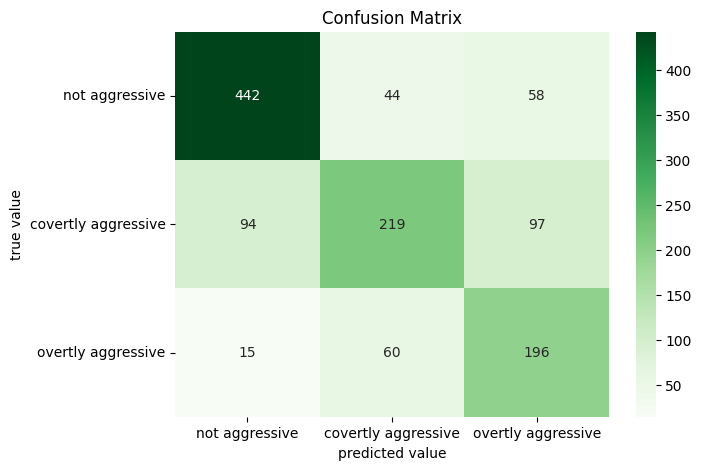

In [ ]:

# Generate test prompts and extract true labels
y_true = d3_test.loc[:, 'label']
X_test = pd.DataFrame(d3_test.apply(generate_test_prompt_cyb_detail_v2, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d3_test aggression prediction  with cyber bullying")
evaluate(y_true, y_pred)

  0%|          | 1/533 [00:00<05:22,  1.65it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  0%|          | 2/533 [00:01<04:35,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 3/533 [00:01<04:20,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 4/533 [00:02<04:42,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 5/533 [00:02<04:27,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 6/533 [00:03<04:44,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|▏         | 7/533 [00:03<04:54,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 8/533 [00:04<04:36,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 9/533 [00:04<04:24,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 10/533 [00:05<04:40,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 11/533 [00:05<04:27,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 12/533 [00:06<04:18,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 13/533 [00:06<04:11,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 14/533 [00:07<04:07,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 15/533 [00:07<04:25,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 16/533 [00:08<04:37,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 17/533 [00:08<04:31,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 18/533 [00:09<04:40,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▎         | 19/533 [00:10<04:49,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 20/533 [00:10<04:35,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 21/533 [00:11<04:46,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▍         | 22/533 [00:11<04:30,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 23/533 [00:12<04:19,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 24/533 [00:12<04:32,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▍         | 25/533 [00:13<04:42,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 26/533 [00:13<04:47,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 27/533 [00:14<04:31,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 28/533 [00:14<04:41,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 29/533 [00:15<04:25,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 30/533 [00:15<04:14,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 31/533 [00:16<04:06,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 32/533 [00:16<04:00,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 33/533 [00:17<03:57,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 34/533 [00:17<03:54,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 35/533 [00:18<03:51,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 36/533 [00:18<03:49,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 37/533 [00:19<03:49,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 38/533 [00:19<04:09,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 39/533 [00:20<04:02,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 40/533 [00:20<03:58,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 41/533 [00:21<04:12,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 42/533 [00:21<04:22,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 43/533 [00:22<04:10,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 44/533 [00:22<04:01,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 45/533 [00:23<03:55,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▊         | 46/533 [00:23<03:51,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 47/533 [00:23<03:46,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 48/533 [00:24<03:45,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 49/533 [00:24<03:46,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 50/533 [00:25<03:44,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 51/533 [00:25<04:03,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 52/533 [00:26<03:56,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 53/533 [00:27<04:11,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 54/533 [00:27<04:21,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 55/533 [00:28<04:07,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 56/533 [00:28<03:57,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 57/533 [00:29<04:12,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 58/533 [00:29<04:22,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 59/533 [00:30<04:09,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█▏        | 60/533 [00:30<04:02,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█▏        | 61/533 [00:31<04:14,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 62/533 [00:31<04:22,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 63/533 [00:32<04:09,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 64/533 [00:32<03:59,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 65/533 [00:33<03:51,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 66/533 [00:33<03:47,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 67/533 [00:34<04:02,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 68/533 [00:34<03:54,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 69/533 [00:35<04:05,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 70/533 [00:35<03:53,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 71/533 [00:36<04:05,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▎        | 72/533 [00:36<03:52,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 73/533 [00:37<03:44,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 74/533 [00:37<03:59,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 75/533 [00:38<03:49,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 76/533 [00:38<03:43,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 77/533 [00:39<03:37,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 78/533 [00:39<03:33,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 79/533 [00:40<03:31,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 80/533 [00:40<03:28,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 81/533 [00:41<03:45,  2.01it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 82/533 [00:41<03:38,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 83/533 [00:42<03:54,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 84/533 [00:42<04:06,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 85/533 [00:43<04:11,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 86/533 [00:43<03:57,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 87/533 [00:44<04:09,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 88/533 [00:45<03:54,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 89/533 [00:45<04:02,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 90/533 [00:46<03:50,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 91/533 [00:46<03:40,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 92/533 [00:47<03:53,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 93/533 [00:47<04:02,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 94/533 [00:48<03:50,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 95/533 [00:48<03:41,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 96/533 [00:49<03:51,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 97/533 [00:49<03:40,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 98/533 [00:50<03:51,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▊        | 99/533 [00:50<04:01,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 100/533 [00:51<04:06,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 101/533 [00:51<03:50,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 102/533 [00:52<03:56,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 103/533 [00:53<04:03,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 104/533 [00:53<04:06,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 105/533 [00:54<03:51,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 106/533 [00:54<03:59,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 107/533 [00:55<03:44,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 108/533 [00:55<03:51,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 109/533 [00:56<03:39,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 110/533 [00:56<03:48,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 111/533 [00:57<03:36,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 112/533 [00:57<03:28,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 113/533 [00:58<03:22,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██▏       | 114/533 [00:58<03:18,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 115/533 [00:59<03:32,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 116/533 [00:59<03:25,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 117/533 [01:00<03:38,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 118/533 [01:00<03:29,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 119/533 [01:01<03:23,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 120/533 [01:01<03:37,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 121/533 [01:02<03:45,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 122/533 [01:02<03:33,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 123/533 [01:03<03:42,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 124/533 [01:03<03:30,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 125/533 [01:04<03:39,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▎       | 126/533 [01:05<03:47,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 127/533 [01:05<03:35,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 128/533 [01:06<03:43,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 129/533 [01:06<03:34,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 130/533 [01:07<03:24,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 131/533 [01:07<03:33,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▍       | 132/533 [01:08<03:22,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 133/533 [01:08<03:31,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 134/533 [01:09<03:21,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 135/533 [01:09<03:31,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 136/533 [01:10<03:22,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 137/533 [01:10<03:31,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 138/533 [01:11<03:21,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 139/533 [01:11<03:31,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▋       | 140/533 [01:12<03:37,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▋       | 141/533 [01:12<03:26,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 142/533 [01:13<03:17,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 143/533 [01:14<03:29,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 144/533 [01:14<03:20,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 145/533 [01:14<03:15,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 146/533 [01:15<03:10,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 147/533 [01:15<03:05,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 148/533 [01:16<03:02,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 149/533 [01:16<03:00,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 150/533 [01:17<02:57,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 151/533 [01:17<02:58,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 152/533 [01:18<02:56,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 153/533 [01:18<02:55,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 154/533 [01:19<02:54,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 155/533 [01:19<02:53,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 156/533 [01:20<03:09,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 157/533 [01:20<03:04,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 158/533 [01:21<03:15,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|██▉       | 159/533 [01:21<03:08,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 160/533 [01:22<03:02,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 161/533 [01:22<03:13,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 162/533 [01:23<03:19,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 163/533 [01:23<03:10,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 164/533 [01:24<03:03,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 165/533 [01:24<03:14,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 166/533 [01:25<03:06,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███▏      | 167/533 [01:25<03:16,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 168/533 [01:26<03:07,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 169/533 [01:26<03:01,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 170/533 [01:27<02:55,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 171/533 [01:27<02:52,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 172/533 [01:28<02:50,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 173/533 [01:28<03:06,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 174/533 [01:29<03:00,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 175/533 [01:29<02:56,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 176/533 [01:30<03:08,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 177/533 [01:30<03:00,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 178/533 [01:31<02:54,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▎      | 179/533 [01:31<02:52,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 180/533 [01:32<02:48,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 181/533 [01:32<02:46,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 182/533 [01:33<02:46,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 183/533 [01:33<02:45,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 184/533 [01:34<02:43,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 185/533 [01:34<02:41,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 186/533 [01:35<02:41,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 187/533 [01:35<02:53,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 188/533 [01:36<02:50,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 189/533 [01:36<03:00,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 190/533 [01:37<02:52,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 191/533 [01:37<02:46,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 192/533 [01:38<02:59,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 193/533 [01:38<02:53,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▋      | 194/533 [01:39<02:46,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 195/533 [01:39<02:56,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 196/533 [01:40<02:49,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 197/533 [01:40<02:43,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 198/533 [01:41<02:39,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 199/533 [01:41<02:51,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 200/533 [01:42<02:44,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 201/533 [01:42<02:39,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 202/533 [01:43<02:37,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 203/533 [01:43<02:34,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 204/533 [01:43<02:32,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 205/533 [01:44<02:44,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▊      | 206/533 [01:45<02:41,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 207/533 [01:45<02:36,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 208/533 [01:45<02:33,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 209/533 [01:46<02:32,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 210/533 [01:46<02:44,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 211/533 [01:47<02:37,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 212/533 [01:47<02:34,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 213/533 [01:48<02:31,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 214/533 [01:48<02:30,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 215/533 [01:49<02:27,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 216/533 [01:49<02:26,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 217/533 [01:50<02:38,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 218/533 [01:50<02:49,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 219/533 [01:51<02:41,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 220/533 [01:51<02:49,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████▏     | 221/533 [01:52<02:55,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 222/533 [01:53<02:46,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 223/533 [01:53<02:37,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 224/533 [01:53<02:32,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 225/533 [01:54<02:27,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 226/533 [01:54<02:23,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 227/533 [01:55<02:21,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 228/533 [01:55<02:32,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 229/533 [01:56<02:28,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 230/533 [01:56<02:25,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 231/533 [01:57<02:35,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▎     | 232/533 [01:57<02:31,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▎     | 233/533 [01:58<02:26,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 234/533 [01:58<02:25,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 235/533 [01:59<02:23,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 236/533 [01:59<02:33,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 237/533 [02:00<02:40,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 238/533 [02:00<02:33,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 239/533 [02:01<02:26,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 240/533 [02:02<02:34,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 241/533 [02:02<02:26,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 242/533 [02:02<02:23,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 243/533 [02:03<02:33,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 244/533 [02:04<02:27,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 245/533 [02:04<02:22,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 246/533 [02:05<02:30,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▋     | 247/533 [02:05<02:24,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 248/533 [02:05<02:21,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 249/533 [02:06<02:17,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 250/533 [02:07<02:27,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 251/533 [02:07<02:21,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 252/533 [02:07<02:17,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 253/533 [02:08<02:14,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 254/533 [02:08<02:11,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 255/533 [02:09<02:21,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 256/533 [02:09<02:17,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 257/533 [02:10<02:14,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 258/533 [02:10<02:12,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▊     | 259/533 [02:11<02:09,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 260/533 [02:11<02:08,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 261/533 [02:12<02:15,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 262/533 [02:12<02:10,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 263/533 [02:13<02:18,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|████▉     | 264/533 [02:13<02:12,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 265/533 [02:14<02:08,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 266/533 [02:14<02:16,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|█████     | 267/533 [02:15<02:11,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 268/533 [02:15<02:19,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|█████     | 269/533 [02:16<02:13,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 270/533 [02:16<02:08,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 271/533 [02:17<02:16,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 272/533 [02:17<02:09,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 273/533 [02:18<02:16,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████▏    | 274/533 [02:19<02:20,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 275/533 [02:19<02:23,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 276/533 [02:20<02:14,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 277/533 [02:20<02:18,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 278/533 [02:21<02:09,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 279/533 [02:21<02:03,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 280/533 [02:21<02:00,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 281/533 [02:22<01:57,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 282/533 [02:22<01:55,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 283/533 [02:23<02:03,  2.03it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 284/533 [02:24<02:09,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 285/533 [02:24<02:13,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▎    | 286/533 [02:25<02:05,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 287/533 [02:25<01:59,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 288/533 [02:26<02:06,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 289/533 [02:26<02:00,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 290/533 [02:26<01:56,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 291/533 [02:27<01:53,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 292/533 [02:27<01:52,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 293/533 [02:28<01:49,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 294/533 [02:28<01:48,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 295/533 [02:29<01:58,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 296/533 [02:29<01:55,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 297/533 [02:30<01:52,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 298/533 [02:30<01:50,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 299/533 [02:31<01:48,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 300/533 [02:31<01:47,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 301/533 [02:32<01:46,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 302/533 [02:32<01:44,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 303/533 [02:33<01:52,  2.04it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 304/533 [02:33<01:49,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 305/533 [02:34<01:56,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 306/533 [02:34<02:00,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 307/533 [02:35<01:54,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 308/533 [02:35<01:50,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 309/533 [02:36<01:46,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 310/533 [02:36<01:53,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 311/533 [02:37<01:58,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 312/533 [02:37<02:01,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 313/533 [02:38<01:53,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 314/533 [02:38<01:48,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 315/533 [02:39<01:44,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 316/533 [02:39<01:50,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 317/533 [02:40<01:46,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 318/533 [02:40<01:44,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 319/533 [02:41<01:40,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 320/533 [02:41<01:38,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 321/533 [02:41<01:36,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 322/533 [02:42<01:43,  2.03it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 323/533 [02:43<01:50,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████    | 324/533 [02:43<01:53,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████    | 325/533 [02:44<01:46,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 326/533 [02:44<01:42,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████▏   | 327/533 [02:45<01:47,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 328/533 [02:45<01:42,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 329/533 [02:46<01:38,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 330/533 [02:46<01:35,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 331/533 [02:46<01:33,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 332/533 [02:47<01:32,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 333/533 [02:47<01:39,  2.02it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 334/533 [02:48<01:35,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 335/533 [02:48<01:32,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 336/533 [02:49<01:31,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 337/533 [02:49<01:30,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 338/533 [02:50<01:28,  2.20it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▎   | 339/533 [02:50<01:28,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 340/533 [02:51<01:27,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 341/533 [02:51<01:28,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 342/533 [02:52<01:26,  2.20it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 343/533 [02:52<01:33,  2.03it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 344/533 [02:53<01:31,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 345/533 [02:53<01:35,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 346/533 [02:54<01:31,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 347/533 [02:54<01:36,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▌   | 348/533 [02:55<01:31,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 349/533 [02:55<01:36,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 350/533 [02:56<01:31,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 351/533 [02:56<01:36,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 352/533 [02:57<01:30,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 353/533 [02:57<01:34,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▋   | 354/533 [02:58<01:29,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 355/533 [02:58<01:25,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 356/533 [02:59<01:23,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 357/533 [02:59<01:29,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 358/533 [03:00<01:32,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 359/533 [03:00<01:28,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 360/533 [03:01<01:24,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 361/533 [03:01<01:21,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 362/533 [03:02<01:19,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 363/533 [03:02<01:18,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 364/533 [03:03<01:24,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 365/533 [03:03<01:21,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 366/533 [03:04<01:18,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 367/533 [03:04<01:24,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 69%|██████▉   | 368/533 [03:05<01:21,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 369/533 [03:05<01:18,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 370/533 [03:06<01:23,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 371/533 [03:06<01:19,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|██████▉   | 372/533 [03:07<01:23,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 373/533 [03:07<01:20,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 374/533 [03:08<01:17,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 375/533 [03:08<01:14,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 376/533 [03:08<01:12,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 377/533 [03:09<01:17,  2.01it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 378/533 [03:09<01:14,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████   | 379/533 [03:10<01:18,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████▏  | 380/533 [03:11<01:22,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████▏  | 381/533 [03:11<01:24,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 382/533 [03:12<01:25,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 383/533 [03:12<01:20,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 384/533 [03:13<01:22,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 385/533 [03:13<01:18,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 386/533 [03:14<01:14,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 387/533 [03:14<01:12,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 388/533 [03:15<01:10,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 389/533 [03:15<01:09,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 390/533 [03:16<01:07,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 391/533 [03:16<01:12,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▎  | 392/533 [03:17<01:10,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▎  | 393/533 [03:17<01:14,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 394/533 [03:18<01:16,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 395/533 [03:18<01:12,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 396/533 [03:19<01:14,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 397/533 [03:19<01:10,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▍  | 398/533 [03:20<01:12,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 399/533 [03:21<01:15,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 400/533 [03:21<01:10,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 401/533 [03:22<01:06,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 402/533 [03:22<01:09,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 403/533 [03:23<01:11,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 404/533 [03:23<01:07,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 405/533 [03:24<01:04,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 406/533 [03:24<01:01,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▋  | 407/533 [03:25<01:00,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 408/533 [03:25<00:58,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 409/533 [03:26<01:03,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 410/533 [03:26<01:01,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 411/533 [03:27<00:59,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 412/533 [03:27<00:58,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 413/533 [03:28<00:57,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 414/533 [03:28<00:56,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 415/533 [03:28<00:54,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 416/533 [03:29<00:54,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 417/533 [03:29<00:53,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 418/533 [03:30<00:58,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▊  | 419/533 [03:30<00:55,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 420/533 [03:31<00:54,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 421/533 [03:31<00:53,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 422/533 [03:32<00:52,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 423/533 [03:32<00:51,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 424/533 [03:33<00:50,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 425/533 [03:33<00:49,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 426/533 [03:34<00:49,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 427/533 [03:34<00:53,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 428/533 [03:35<00:51,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 429/533 [03:35<00:49,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 430/533 [03:36<00:52,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 431/533 [03:36<00:50,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 432/533 [03:37<00:49,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 433/533 [03:37<00:47,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████▏ | 434/533 [03:38<00:46,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 435/533 [03:38<00:50,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 436/533 [03:39<00:48,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 437/533 [03:39<00:46,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 438/533 [03:40<00:46,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 439/533 [03:40<00:44,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 440/533 [03:41<00:47,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 83%|████████▎ | 441/533 [03:41<00:46,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 442/533 [03:42<00:44,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 443/533 [03:42<00:43,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 444/533 [03:42<00:42,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 445/533 [03:43<00:41,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 446/533 [03:43<00:40,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 447/533 [03:44<00:40,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 448/533 [03:44<00:39,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 449/533 [03:45<00:42,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 450/533 [03:45<00:40,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 451/533 [03:46<00:39,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 452/533 [03:46<00:38,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 453/533 [03:47<00:37,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 454/533 [03:47<00:36,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 455/533 [03:48<00:36,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 456/533 [03:48<00:38,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 457/533 [03:49<00:37,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 458/533 [03:49<00:39,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 459/533 [03:50<00:37,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▋ | 460/533 [03:50<00:35,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▋ | 461/533 [03:51<00:37,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 462/533 [03:51<00:35,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 463/533 [03:52<00:34,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 464/533 [03:52<00:36,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 465/533 [03:53<00:34,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 466/533 [03:53<00:32,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 467/533 [03:54<00:31,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 468/533 [03:54<00:30,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 469/533 [03:55<00:30,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 470/533 [03:55<00:29,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 471/533 [03:56<00:28,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▊ | 472/533 [03:56<00:30,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▊ | 473/533 [03:57<00:32,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 474/533 [03:57<00:30,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 475/533 [03:58<00:28,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 476/533 [03:58<00:27,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 477/533 [03:59<00:26,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 478/533 [03:59<00:25,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 479/533 [04:00<00:25,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 480/533 [04:00<00:24,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 481/533 [04:00<00:24,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 482/533 [04:01<00:23,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 483/533 [04:01<00:22,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 484/533 [04:02<00:24,  2.00it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 485/533 [04:02<00:23,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 486/533 [04:03<00:24,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████▏| 487/533 [04:03<00:23,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 488/533 [04:04<00:22,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 489/533 [04:05<00:22,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 490/533 [04:05<00:23,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 491/533 [04:06<00:23,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 492/533 [04:06<00:21,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 493/533 [04:07<00:20,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 494/533 [04:07<00:19,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 495/533 [04:07<00:18,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 496/533 [04:08<00:17,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 497/533 [04:08<00:17,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 498/533 [04:09<00:16,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 499/533 [04:09<00:15,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 500/533 [04:10<00:15,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 501/533 [04:10<00:16,  1.99it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▍| 502/533 [04:11<00:15,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 503/533 [04:11<00:15,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 504/533 [04:12<00:14,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 505/533 [04:12<00:13,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 506/533 [04:13<00:14,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 507/533 [04:13<00:13,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 508/533 [04:14<00:12,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 509/533 [04:14<00:12,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 510/533 [04:15<00:12,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 96%|█████████▌| 511/533 [04:16<00:11,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 512/533 [04:16<00:10,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 513/533 [04:16<00:09,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 514/533 [04:17<00:09,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 515/533 [04:17<00:08,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 516/533 [04:18<00:08,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 97%|█████████▋| 517/533 [04:18<00:07,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 518/533 [04:19<00:07,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 519/533 [04:19<00:07,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 520/533 [04:20<00:07,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 521/533 [04:21<00:06,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 522/533 [04:21<00:05,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 523/533 [04:22<00:05,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 524/533 [04:22<00:04,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 525/533 [04:23<00:04,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 526/533 [04:23<00:03,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 527/533 [04:24<00:02,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 528/533 [04:24<00:02,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 529/533 [04:25<00:02,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 530/533 [04:25<00:01,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|█████████▉| 531/533 [04:26<00:01,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|█████████▉| 532/533 [04:26<00:00,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|██████████| 533/533 [04:27<00:00,  1.99it/s]

Predicted answer: covertly aggressive
d4_test aggression prediction  with cyber bullying
Accuracy: 0.745
Accuracy for label not aggressive: 0.799
Accuracy for label covertly aggressive: 0.345
Accuracy for label overtly aggressive: 0.754

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.93      0.80      0.86       418
covertly aggressive       0.36      0.34      0.35        58
 overtly aggressive       0.37      0.75      0.49        57

           accuracy                           0.74       533
          macro avg       0.55      0.63      0.57       533
       weighted avg       0.81      0.74      0.76       533


Confusion Matrix:
[[334  30  54]
 [ 18  20  20]
 [  8   6  43]]


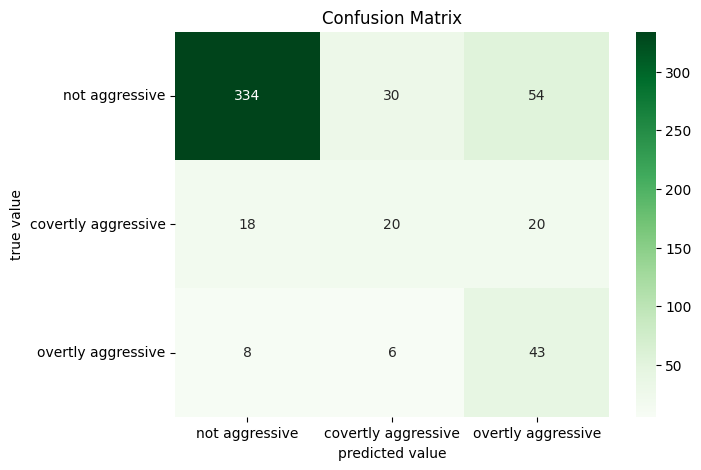

In [ ]:

# Generate test prompts and extract true labels
y_true = d4_test.loc[:, 'label']
X_test = pd.DataFrame(d4_test.apply(generate_test_prompt_cyb_detail_v2, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d4_test aggression prediction  with cyber bullying")
evaluate(y_true, y_pred)

In [ ]:
# Version 1: Confidence filtering + neutral language
def generate_test_prompt_cyb_detail_v3(row):
    confidence = row['confidence_cyb']
    cyb_type = row['predictions_cyb']

    # Only provide auxiliary info for high-confidence predictions
    if confidence >= 0.65:
        if cyb_type == 'not_cyberbullying':
            aux_info = f"Cyberbullying classifier: not cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'other_cyberbullying':
            aux_info = f"Cyberbullying classifier: other cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'age':
            aux_info = f"Cyberbullying classifier: age-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'religion':
            aux_info = f"Cyberbullying classifier: religion-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'ethnicity':
            aux_info = f"Cyberbullying classifier: ethnicity-related cyberbullying (confidence: {confidence:.2f})"
        elif cyb_type == 'gender':
            aux_info = f"Cyberbullying classifier: gender-related cyberbullying (confidence: {confidence:.2f})"
        else:
            aux_info = "Not provided"
    else:
        aux_info = "Not provided"

    return f"""You are a strict Aggression classifier.
Analyze the text and classify it into exactly one category:

The possible categories are:
- not aggressive: neutral or non-hostile statements
- covertly aggressive: indirect aggression such as sarcasm, passive aggression, exclusionary remarks, subtle put-downs, indirect verbal attacks
- overtly aggressive: direct aggression such as insults, threats, slurs, or explicit hostility

TEXT: "{row['text']}"

Auxiliary information: {aux_info}

CLASSIFICATION: """.strip()

  0%|          | 1/1493 [00:00<14:43,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 2/1493 [00:01<12:40,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  0%|          | 3/1493 [00:01<13:36,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  0%|          | 4/1493 [00:02<12:53,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


  0%|          | 5/1493 [00:02<13:28,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 6/1493 [00:03<13:49,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  0%|          | 7/1493 [00:03<12:56,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 8/1493 [00:04<12:17,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 9/1493 [00:04<11:51,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 10/1493 [00:05<12:45,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 11/1493 [00:05<12:17,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 12/1493 [00:06<11:54,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 13/1493 [00:06<11:35,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


  1%|          | 14/1493 [00:07<12:34,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 15/1493 [00:07<13:04,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 16/1493 [00:08<13:34,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|          | 17/1493 [00:08<13:59,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|          | 18/1493 [00:09<14:03,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|▏         | 19/1493 [00:10<14:09,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|▏         | 20/1493 [00:10<14:16,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  1%|▏         | 21/1493 [00:11<14:27,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  1%|▏         | 22/1493 [00:11<14:39,  1.67it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 23/1493 [00:12<14:39,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 24/1493 [00:13<14:37,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 25/1493 [00:13<14:47,  1.65it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 26/1493 [00:14<13:35,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 27/1493 [00:14<12:45,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 28/1493 [00:15<13:14,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 29/1493 [00:15<12:40,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 30/1493 [00:16<13:11,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 31/1493 [00:16<12:28,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


  2%|▏         | 32/1493 [00:17<13:09,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 33/1493 [00:17<13:34,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 34/1493 [00:18<13:47,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 35/1493 [00:19<13:57,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  2%|▏         | 36/1493 [00:19<14:12,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  2%|▏         | 37/1493 [00:20<13:15,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 38/1493 [00:20<12:36,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 39/1493 [00:21<12:04,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 40/1493 [00:21<11:43,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 41/1493 [00:22<12:32,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 42/1493 [00:22<13:03,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 43/1493 [00:23<13:23,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 44/1493 [00:23<12:40,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 45/1493 [00:24<12:09,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 46/1493 [00:24<12:54,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 47/1493 [00:25<13:33,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 48/1493 [00:26<13:47,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 49/1493 [00:26<13:03,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


  3%|▎         | 50/1493 [00:27<13:24,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  3%|▎         | 51/1493 [00:27<13:41,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  3%|▎         | 52/1493 [00:28<13:50,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▎         | 53/1493 [00:28<12:56,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▎         | 54/1493 [00:29<13:19,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  4%|▎         | 55/1493 [00:29<12:34,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 56/1493 [00:30<12:02,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 57/1493 [00:30<11:41,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 58/1493 [00:31<12:26,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 59/1493 [00:31<11:58,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 60/1493 [00:32<11:37,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 61/1493 [00:32<12:25,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 62/1493 [00:33<13:03,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 63/1493 [00:34<13:30,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 64/1493 [00:34<13:45,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 65/1493 [00:35<12:53,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  4%|▍         | 66/1493 [00:35<13:20,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  4%|▍         | 67/1493 [00:36<12:44,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 68/1493 [00:36<13:15,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 69/1493 [00:37<13:37,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▍         | 70/1493 [00:37<12:47,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 71/1493 [00:38<13:05,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▍         | 72/1493 [00:38<12:20,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 73/1493 [00:39<11:47,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▍         | 74/1493 [00:39<11:28,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 75/1493 [00:40<12:14,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 76/1493 [00:41<12:55,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▌         | 77/1493 [00:41<13:13,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  5%|▌         | 78/1493 [00:42<12:28,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 79/1493 [00:42<11:57,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 80/1493 [00:43<12:35,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  5%|▌         | 81/1493 [00:43<12:00,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  5%|▌         | 82/1493 [00:44<12:36,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 83/1493 [00:44<12:59,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 84/1493 [00:45<13:15,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 85/1493 [00:45<13:26,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 86/1493 [00:46<13:34,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 87/1493 [00:47<13:46,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 88/1493 [00:47<12:51,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 89/1493 [00:48<12:13,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▌         | 90/1493 [00:48<12:46,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 91/1493 [00:49<13:08,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  6%|▌         | 92/1493 [00:49<13:21,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▌         | 93/1493 [00:50<12:28,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 94/1493 [00:50<11:50,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 95/1493 [00:51<12:25,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  6%|▋         | 96/1493 [00:51<11:51,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  6%|▋         | 97/1493 [00:52<11:24,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 98/1493 [00:52<11:10,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 99/1493 [00:53<11:01,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 100/1493 [00:53<11:49,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 101/1493 [00:54<11:22,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 102/1493 [00:54<12:06,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 103/1493 [00:55<12:42,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 104/1493 [00:55<13:02,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 105/1493 [00:56<13:31,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 106/1493 [00:57<13:35,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 107/1493 [00:57<13:42,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  7%|▋         | 108/1493 [00:58<13:38,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 109/1493 [00:58<12:48,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


  7%|▋         | 110/1493 [00:59<13:06,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  7%|▋         | 111/1493 [01:00<13:21,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 112/1493 [01:00<13:24,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 113/1493 [01:01<12:32,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 114/1493 [01:01<12:52,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 115/1493 [01:02<12:09,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 116/1493 [01:02<11:38,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 117/1493 [01:03<12:13,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 118/1493 [01:03<11:42,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 119/1493 [01:04<12:17,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 120/1493 [01:04<12:45,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 121/1493 [01:05<12:01,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 122/1493 [01:05<11:37,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 123/1493 [01:06<12:05,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  8%|▊         | 124/1493 [01:06<11:32,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


  8%|▊         | 125/1493 [01:07<12:09,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  8%|▊         | 126/1493 [01:08<12:33,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▊         | 127/1493 [01:08<12:51,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▊         | 128/1493 [01:09<13:02,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▊         | 129/1493 [01:09<13:13,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▊         | 130/1493 [01:10<13:18,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 131/1493 [01:10<12:23,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 132/1493 [01:11<12:44,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 133/1493 [01:12<13:00,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 134/1493 [01:12<13:12,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 135/1493 [01:13<12:25,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


  9%|▉         | 136/1493 [01:13<12:42,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 137/1493 [01:14<12:59,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


  9%|▉         | 138/1493 [01:14<13:07,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 139/1493 [01:15<13:13,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 140/1493 [01:16<13:16,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


  9%|▉         | 141/1493 [01:16<13:21,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 142/1493 [01:17<13:21,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|▉         | 143/1493 [01:17<13:27,  1.67it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 144/1493 [01:18<12:29,  1.80it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|▉         | 145/1493 [01:19<12:46,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 146/1493 [01:19<12:55,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|▉         | 147/1493 [01:20<13:08,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|▉         | 148/1493 [01:20<13:10,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|▉         | 149/1493 [01:21<13:13,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 150/1493 [01:22<13:24,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 151/1493 [01:22<13:22,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 152/1493 [01:23<13:27,  1.66it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 10%|█         | 153/1493 [01:23<13:26,  1.66it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 154/1493 [01:24<12:26,  1.79it/s]Device set to use cuda:0


Predicted answer: not aggressive


 10%|█         | 155/1493 [01:24<12:50,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 10%|█         | 156/1493 [01:25<12:57,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 157/1493 [01:26<13:04,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 158/1493 [01:26<12:05,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█         | 159/1493 [01:27<12:34,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 160/1493 [01:27<12:48,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 161/1493 [01:28<12:59,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 162/1493 [01:28<12:59,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 163/1493 [01:29<12:55,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 164/1493 [01:30<13:02,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█         | 165/1493 [01:30<13:05,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 166/1493 [01:31<13:01,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█         | 167/1493 [01:31<12:58,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 11%|█▏        | 168/1493 [01:32<12:01,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█▏        | 169/1493 [01:32<11:26,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 11%|█▏        | 170/1493 [01:33<11:51,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 11%|█▏        | 171/1493 [01:33<12:12,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 172/1493 [01:34<12:26,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 173/1493 [01:35<11:45,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 174/1493 [01:35<12:07,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 175/1493 [01:36<12:29,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 176/1493 [01:36<11:44,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 177/1493 [01:37<12:05,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 178/1493 [01:37<12:20,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 179/1493 [01:38<12:29,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 180/1493 [01:39<12:34,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 12%|█▏        | 181/1493 [01:39<12:37,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 182/1493 [01:40<12:36,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 183/1493 [01:40<12:37,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 184/1493 [01:41<11:47,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 12%|█▏        | 185/1493 [01:41<12:07,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 12%|█▏        | 186/1493 [01:42<12:26,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 187/1493 [01:42<11:42,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 188/1493 [01:43<11:08,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 189/1493 [01:43<11:39,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 190/1493 [01:44<11:06,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 191/1493 [01:44<11:38,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 192/1493 [01:45<12:02,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 193/1493 [01:46<12:12,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 194/1493 [01:46<11:25,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 13%|█▎        | 195/1493 [01:47<12:12,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 196/1493 [01:47<12:24,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 197/1493 [01:48<12:32,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 198/1493 [01:49<12:37,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 13%|█▎        | 199/1493 [01:49<12:39,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 200/1493 [01:50<12:39,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 13%|█▎        | 201/1493 [01:50<11:47,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▎        | 202/1493 [01:51<12:09,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▎        | 203/1493 [01:51<12:21,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▎        | 204/1493 [01:52<12:24,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▎        | 205/1493 [01:53<12:27,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 206/1493 [01:53<12:31,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 207/1493 [01:54<12:31,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 208/1493 [01:54<11:38,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 209/1493 [01:55<11:07,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 210/1493 [01:55<10:43,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 14%|█▍        | 211/1493 [01:56<11:21,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 212/1493 [01:56<11:44,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 14%|█▍        | 213/1493 [01:57<11:59,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 214/1493 [01:57<12:08,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 215/1493 [01:58<12:12,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 14%|█▍        | 216/1493 [01:59<12:17,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 217/1493 [01:59<11:32,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 218/1493 [02:00<11:55,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 219/1493 [02:00<12:07,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 220/1493 [02:01<12:10,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 221/1493 [02:01<11:20,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▍        | 222/1493 [02:02<11:47,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▍        | 223/1493 [02:02<11:08,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 224/1493 [02:03<10:46,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 225/1493 [02:03<11:24,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 226/1493 [02:04<11:47,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 15%|█▌        | 227/1493 [02:05<11:08,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 228/1493 [02:05<11:35,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▌        | 229/1493 [02:06<11:52,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 15%|█▌        | 230/1493 [02:06<11:08,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 15%|█▌        | 231/1493 [02:07<11:32,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 232/1493 [02:07<11:52,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 233/1493 [02:08<12:01,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 234/1493 [02:09<12:07,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 235/1493 [02:09<11:19,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 236/1493 [02:10<11:45,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 16%|█▌        | 237/1493 [02:10<12:01,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 238/1493 [02:11<11:12,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▌        | 239/1493 [02:11<11:34,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 240/1493 [02:12<11:48,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 241/1493 [02:12<11:58,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▌        | 242/1493 [02:13<12:09,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 16%|█▋        | 243/1493 [02:14<11:23,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 244/1493 [02:14<10:47,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 245/1493 [02:14<10:18,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 16%|█▋        | 246/1493 [02:15<10:49,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 247/1493 [02:15<10:24,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 248/1493 [02:16<10:49,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 249/1493 [02:17<11:11,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 250/1493 [02:17<11:30,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 251/1493 [02:18<11:34,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 252/1493 [02:18<11:39,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 253/1493 [02:19<11:47,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 254/1493 [02:20<11:55,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 255/1493 [02:20<11:54,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 256/1493 [02:21<11:04,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 257/1493 [02:21<10:29,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 258/1493 [02:22<10:55,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 17%|█▋        | 259/1493 [02:22<10:26,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 17%|█▋        | 260/1493 [02:23<10:58,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 17%|█▋        | 261/1493 [02:23<11:11,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 262/1493 [02:24<10:36,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 263/1493 [02:24<10:08,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 264/1493 [02:25<09:48,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 265/1493 [02:25<10:23,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 266/1493 [02:26<10:51,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 267/1493 [02:26<11:06,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 268/1493 [02:27<11:17,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 269/1493 [02:27<11:29,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 270/1493 [02:28<11:29,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 271/1493 [02:28<10:40,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 272/1493 [02:29<10:09,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 273/1493 [02:29<09:53,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 18%|█▊        | 274/1493 [02:30<10:22,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 18%|█▊        | 275/1493 [02:30<10:46,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 18%|█▊        | 276/1493 [02:31<11:03,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▊        | 277/1493 [02:32<11:16,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▊        | 278/1493 [02:32<11:20,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▊        | 279/1493 [02:33<11:27,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 280/1493 [02:33<11:32,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 281/1493 [02:34<11:45,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 282/1493 [02:35<11:48,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 283/1493 [02:35<11:44,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 284/1493 [02:36<11:44,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 19%|█▉        | 285/1493 [02:36<11:43,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 286/1493 [02:37<11:40,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 19%|█▉        | 287/1493 [02:37<10:49,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 288/1493 [02:38<10:12,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 289/1493 [02:38<09:48,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 290/1493 [02:39<09:35,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 19%|█▉        | 291/1493 [02:39<10:16,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 292/1493 [02:40<10:38,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|█▉        | 293/1493 [02:40<10:04,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|█▉        | 294/1493 [02:41<10:30,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 295/1493 [02:41<10:46,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 296/1493 [02:42<10:55,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 297/1493 [02:43<11:05,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|█▉        | 298/1493 [02:43<11:07,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 299/1493 [02:44<11:10,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 20%|██        | 300/1493 [02:44<11:13,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 301/1493 [02:45<11:18,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 302/1493 [02:45<10:31,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 303/1493 [02:46<10:51,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 304/1493 [02:46<10:14,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 20%|██        | 305/1493 [02:47<10:37,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 20%|██        | 306/1493 [02:47<10:51,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 307/1493 [02:48<10:58,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 308/1493 [02:49<11:05,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██        | 309/1493 [02:49<10:21,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 310/1493 [02:50<10:37,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██        | 311/1493 [02:50<10:48,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 312/1493 [02:51<10:56,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██        | 313/1493 [02:51<10:59,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 314/1493 [02:52<11:05,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 315/1493 [02:52<11:09,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 21%|██        | 316/1493 [02:53<10:23,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██        | 317/1493 [02:53<09:58,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██▏       | 318/1493 [02:54<10:24,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 21%|██▏       | 319/1493 [02:54<09:52,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 21%|██▏       | 320/1493 [02:55<09:30,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 321/1493 [02:55<09:16,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 322/1493 [02:56<09:02,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 323/1493 [02:56<09:40,  2.02it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 324/1493 [02:57<09:20,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 325/1493 [02:57<09:55,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 326/1493 [02:58<09:37,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 327/1493 [02:58<10:08,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 328/1493 [02:59<09:47,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 329/1493 [02:59<10:18,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 330/1493 [03:00<10:32,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 22%|██▏       | 331/1493 [03:00<09:56,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 332/1493 [03:01<10:17,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 22%|██▏       | 333/1493 [03:01<09:50,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 334/1493 [03:02<09:26,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 22%|██▏       | 335/1493 [03:03<10:04,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 336/1493 [03:03<10:26,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 337/1493 [03:04<10:42,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 338/1493 [03:04<10:03,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 339/1493 [03:05<09:35,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 340/1493 [03:05<09:16,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 341/1493 [03:06<09:54,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 342/1493 [03:06<10:22,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 343/1493 [03:07<09:53,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 344/1493 [03:07<10:15,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 23%|██▎       | 345/1493 [03:08<10:29,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 23%|██▎       | 346/1493 [03:08<09:51,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 347/1493 [03:09<09:25,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 348/1493 [03:09<09:07,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 349/1493 [03:10<08:55,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 23%|██▎       | 350/1493 [03:10<08:45,  2.18it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 351/1493 [03:11<09:35,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▎       | 352/1493 [03:11<09:18,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 353/1493 [03:12<09:04,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▎       | 354/1493 [03:12<09:38,  1.97it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 355/1493 [03:13<09:15,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 24%|██▍       | 356/1493 [03:13<09:45,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 24%|██▍       | 357/1493 [03:14<10:17,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 358/1493 [03:14<10:31,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 359/1493 [03:15<10:41,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 360/1493 [03:16<10:48,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 361/1493 [03:16<10:48,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 362/1493 [03:17<10:58,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 363/1493 [03:17<10:55,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 364/1493 [03:18<10:57,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 24%|██▍       | 365/1493 [03:18<10:57,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 366/1493 [03:19<10:54,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 367/1493 [03:20<11:05,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 368/1493 [03:20<10:21,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 369/1493 [03:21<09:41,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 370/1493 [03:21<09:14,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▍       | 371/1493 [03:22<09:38,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▍       | 372/1493 [03:22<09:55,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▍       | 373/1493 [03:23<10:15,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 374/1493 [03:23<10:22,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 375/1493 [03:24<10:32,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▌       | 376/1493 [03:24<10:39,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 25%|██▌       | 377/1493 [03:25<10:43,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 378/1493 [03:25<10:02,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 25%|██▌       | 379/1493 [03:26<10:10,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 25%|██▌       | 380/1493 [03:27<09:36,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 381/1493 [03:27<09:58,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 382/1493 [03:28<09:29,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 383/1493 [03:28<09:54,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 384/1493 [03:29<10:14,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 385/1493 [03:29<10:29,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 386/1493 [03:30<10:43,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 387/1493 [03:31<10:46,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 388/1493 [03:31<10:55,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▌       | 389/1493 [03:32<10:07,  1.82it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▌       | 390/1493 [03:32<10:22,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 26%|██▌       | 391/1493 [03:33<10:29,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▋       | 392/1493 [03:33<09:49,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 26%|██▋       | 393/1493 [03:34<10:12,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▋       | 394/1493 [03:34<10:23,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 26%|██▋       | 395/1493 [03:35<10:24,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 396/1493 [03:36<10:34,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 397/1493 [03:36<10:34,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 398/1493 [03:37<10:47,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 399/1493 [03:37<09:55,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 400/1493 [03:38<09:19,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 401/1493 [03:38<08:53,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 402/1493 [03:39<08:54,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 403/1493 [03:39<09:26,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 404/1493 [03:40<09:44,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 405/1493 [03:40<09:13,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 406/1493 [03:41<08:52,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 407/1493 [03:41<09:16,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 27%|██▋       | 408/1493 [03:42<08:58,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 27%|██▋       | 409/1493 [03:42<09:26,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 27%|██▋       | 410/1493 [03:43<09:46,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 411/1493 [03:43<09:58,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 412/1493 [03:44<09:21,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 413/1493 [03:44<09:41,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 414/1493 [03:45<09:54,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 415/1493 [03:46<10:02,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 416/1493 [03:46<10:15,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 417/1493 [03:47<10:18,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 418/1493 [03:47<09:34,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 419/1493 [03:48<09:55,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 420/1493 [03:48<10:03,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 421/1493 [03:49<10:06,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 28%|██▊       | 422/1493 [03:50<10:07,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 423/1493 [03:50<09:25,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 28%|██▊       | 424/1493 [03:51<09:40,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 28%|██▊       | 425/1493 [03:51<09:07,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 426/1493 [03:52<09:29,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▊       | 427/1493 [03:52<08:58,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 428/1493 [03:52<08:37,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▊       | 429/1493 [03:53<09:06,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 430/1493 [03:54<09:24,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 431/1493 [03:54<09:35,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 432/1493 [03:55<09:09,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 433/1493 [03:55<09:25,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 434/1493 [03:56<09:42,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 435/1493 [03:56<09:08,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 29%|██▉       | 436/1493 [03:57<09:28,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 437/1493 [03:57<09:44,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 438/1493 [03:58<09:49,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 29%|██▉       | 439/1493 [03:59<09:58,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 29%|██▉       | 440/1493 [03:59<09:57,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|██▉       | 441/1493 [04:00<09:16,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 442/1493 [04:00<08:46,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 443/1493 [04:00<08:32,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 444/1493 [04:01<08:18,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 445/1493 [04:01<08:06,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|██▉       | 446/1493 [04:02<08:40,  2.01it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|██▉       | 447/1493 [04:03<09:10,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|███       | 448/1493 [04:03<08:43,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 449/1493 [04:04<09:06,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 450/1493 [04:04<09:31,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|███       | 451/1493 [04:05<09:00,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 452/1493 [04:05<09:14,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 30%|███       | 453/1493 [04:06<09:26,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 30%|███       | 454/1493 [04:06<08:53,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 30%|███       | 455/1493 [04:07<09:11,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 456/1493 [04:07<09:25,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 457/1493 [04:08<08:50,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 458/1493 [04:08<09:13,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 459/1493 [04:09<09:22,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███       | 460/1493 [04:10<09:28,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 461/1493 [04:10<09:35,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███       | 462/1493 [04:11<08:58,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 463/1493 [04:11<08:34,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 464/1493 [04:11<08:24,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 465/1493 [04:12<08:09,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███       | 466/1493 [04:12<08:41,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 31%|███▏      | 467/1493 [04:13<09:10,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███▏      | 468/1493 [04:14<09:22,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 31%|███▏      | 469/1493 [04:14<08:51,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 31%|███▏      | 470/1493 [04:15<09:19,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 471/1493 [04:15<09:27,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 472/1493 [04:16<09:30,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 473/1493 [04:16<09:38,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 474/1493 [04:17<09:40,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 475/1493 [04:18<09:40,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 476/1493 [04:18<09:38,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 477/1493 [04:19<09:50,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 478/1493 [04:19<09:55,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 479/1493 [04:20<09:11,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 480/1493 [04:20<09:22,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 481/1493 [04:21<09:27,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 32%|███▏      | 482/1493 [04:21<08:51,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 32%|███▏      | 483/1493 [04:22<09:05,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 484/1493 [04:23<09:15,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 32%|███▏      | 485/1493 [04:23<08:40,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 486/1493 [04:24<08:57,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 487/1493 [04:24<09:07,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 488/1493 [04:25<09:15,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 489/1493 [04:25<08:41,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 490/1493 [04:26<08:17,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 491/1493 [04:26<08:38,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 492/1493 [04:27<08:54,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 493/1493 [04:27<09:04,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 494/1493 [04:28<08:30,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 495/1493 [04:28<08:46,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 496/1493 [04:29<08:57,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 497/1493 [04:29<08:30,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 33%|███▎      | 498/1493 [04:30<08:55,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 33%|███▎      | 499/1493 [04:30<09:12,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 33%|███▎      | 500/1493 [04:31<09:22,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▎      | 501/1493 [04:32<09:31,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▎      | 502/1493 [04:32<09:40,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▎      | 503/1493 [04:33<09:41,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 504/1493 [04:33<09:44,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 505/1493 [04:34<09:44,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 506/1493 [04:35<09:45,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 507/1493 [04:35<09:40,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 508/1493 [04:36<09:40,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 509/1493 [04:36<09:39,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 34%|███▍      | 510/1493 [04:37<08:56,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 511/1493 [04:37<08:29,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 512/1493 [04:38<08:06,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 513/1493 [04:38<07:51,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 34%|███▍      | 514/1493 [04:39<08:21,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 34%|███▍      | 515/1493 [04:39<08:39,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▍      | 516/1493 [04:40<08:53,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 517/1493 [04:41<09:01,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▍      | 518/1493 [04:41<09:06,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 519/1493 [04:42<09:14,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▍      | 520/1493 [04:42<08:37,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 521/1493 [04:43<08:12,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▍      | 522/1493 [04:43<08:33,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 523/1493 [04:44<08:51,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 524/1493 [04:44<09:01,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 525/1493 [04:45<09:08,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 526/1493 [04:46<09:11,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 35%|███▌      | 527/1493 [04:46<08:34,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 35%|███▌      | 528/1493 [04:47<08:47,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 529/1493 [04:47<08:57,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 35%|███▌      | 530/1493 [04:48<08:29,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 531/1493 [04:48<08:43,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 532/1493 [04:49<08:52,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 533/1493 [04:49<08:23,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 534/1493 [04:50<08:40,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 535/1493 [04:50<08:11,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 536/1493 [04:51<08:30,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 537/1493 [04:51<08:43,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▌      | 538/1493 [04:52<08:52,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▌      | 539/1493 [04:52<08:19,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 540/1493 [04:53<07:55,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 36%|███▌      | 541/1493 [04:53<08:23,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▋      | 542/1493 [04:54<08:32,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 36%|███▋      | 543/1493 [04:55<08:41,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 36%|███▋      | 544/1493 [04:55<08:50,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 545/1493 [04:56<08:56,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 546/1493 [04:56<08:58,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 547/1493 [04:57<08:20,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 548/1493 [04:57<08:37,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 549/1493 [04:58<08:45,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 550/1493 [04:58<08:16,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 551/1493 [04:59<08:30,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 552/1493 [05:00<08:41,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 553/1493 [05:00<08:49,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 37%|███▋      | 554/1493 [05:01<08:16,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 555/1493 [05:01<07:53,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 556/1493 [05:01<07:39,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 37%|███▋      | 557/1493 [05:02<08:00,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 558/1493 [05:03<08:15,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 37%|███▋      | 559/1493 [05:03<08:25,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 560/1493 [05:04<08:38,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 561/1493 [05:04<08:44,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 562/1493 [05:05<08:49,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 563/1493 [05:05<08:22,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 564/1493 [05:06<07:54,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 565/1493 [05:06<08:16,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 38%|███▊      | 566/1493 [05:07<08:26,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 567/1493 [05:08<08:36,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 568/1493 [05:08<08:43,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 569/1493 [05:09<08:48,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 38%|███▊      | 570/1493 [05:09<08:12,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 571/1493 [05:10<07:44,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 572/1493 [05:10<07:24,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 573/1493 [05:11<07:15,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 38%|███▊      | 574/1493 [05:11<07:06,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▊      | 575/1493 [05:12<07:37,  2.01it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 39%|███▊      | 576/1493 [05:12<07:21,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▊      | 577/1493 [05:13<07:51,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▊      | 578/1493 [05:13<07:31,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 579/1493 [05:13<07:17,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 580/1493 [05:14<07:43,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 581/1493 [05:15<07:30,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 582/1493 [05:15<07:16,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 583/1493 [05:16<07:41,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 584/1493 [05:16<07:57,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 39%|███▉      | 585/1493 [05:17<08:11,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 39%|███▉      | 586/1493 [05:17<07:42,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 587/1493 [05:18<07:22,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 588/1493 [05:18<07:06,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 39%|███▉      | 589/1493 [05:19<07:32,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 590/1493 [05:19<07:51,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 591/1493 [05:20<08:04,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 592/1493 [05:20<08:11,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 593/1493 [05:21<08:20,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|███▉      | 594/1493 [05:21<07:51,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 595/1493 [05:22<07:29,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 596/1493 [05:22<07:15,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|███▉      | 597/1493 [05:23<07:05,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 598/1493 [05:23<07:36,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 599/1493 [05:24<07:59,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 40%|████      | 600/1493 [05:24<07:37,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 601/1493 [05:25<07:20,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 40%|████      | 602/1493 [05:25<07:49,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 603/1493 [05:26<08:02,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 40%|████      | 604/1493 [05:26<07:35,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 605/1493 [05:27<07:54,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 606/1493 [05:27<07:31,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 607/1493 [05:28<07:50,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 608/1493 [05:29<08:08,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 609/1493 [05:29<08:14,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 610/1493 [05:30<08:21,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 611/1493 [05:30<08:23,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 612/1493 [05:31<08:21,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████      | 613/1493 [05:31<08:20,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████      | 614/1493 [05:32<07:49,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████      | 615/1493 [05:33<08:03,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████▏     | 616/1493 [05:33<08:13,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 41%|████▏     | 617/1493 [05:34<08:16,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 41%|████▏     | 618/1493 [05:34<07:41,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 41%|████▏     | 619/1493 [05:35<07:56,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 620/1493 [05:35<08:11,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 621/1493 [05:36<08:15,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 622/1493 [05:36<07:42,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 623/1493 [05:37<07:54,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 624/1493 [05:37<07:27,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 625/1493 [05:38<07:08,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 626/1493 [05:38<07:29,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 627/1493 [05:39<07:09,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 628/1493 [05:39<07:31,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 42%|████▏     | 629/1493 [05:40<07:09,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 630/1493 [05:40<06:54,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 631/1493 [05:41<06:42,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 632/1493 [05:41<07:06,  2.02it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 42%|████▏     | 633/1493 [05:42<06:51,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 42%|████▏     | 634/1493 [05:42<07:17,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 635/1493 [05:43<07:33,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 636/1493 [05:43<07:16,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 637/1493 [05:44<07:02,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 638/1493 [05:44<07:30,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 639/1493 [05:45<07:46,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 640/1493 [05:46<07:55,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 43%|████▎     | 641/1493 [05:46<07:58,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 642/1493 [05:47<08:03,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 643/1493 [05:47<07:37,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 644/1493 [05:48<07:14,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 645/1493 [05:48<07:30,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 646/1493 [05:49<07:41,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 647/1493 [05:49<07:14,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 43%|████▎     | 648/1493 [05:50<07:30,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 43%|████▎     | 649/1493 [05:50<07:41,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▎     | 650/1493 [05:51<07:56,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▎     | 651/1493 [05:52<07:58,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▎     | 652/1493 [05:52<08:00,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▎     | 653/1493 [05:53<08:06,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 654/1493 [05:53<08:07,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 655/1493 [05:54<08:07,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 656/1493 [05:54<07:32,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 657/1493 [05:55<07:42,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 658/1493 [05:55<07:17,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 659/1493 [05:56<06:56,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 660/1493 [05:56<07:20,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 44%|████▍     | 661/1493 [05:57<07:00,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 44%|████▍     | 662/1493 [05:57<07:19,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 663/1493 [05:58<07:32,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 44%|████▍     | 664/1493 [05:59<07:11,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 665/1493 [05:59<06:52,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 666/1493 [06:00<07:13,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 667/1493 [06:00<06:53,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▍     | 668/1493 [06:01<07:12,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▍     | 669/1493 [06:01<07:26,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▍     | 670/1493 [06:02<07:35,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▍     | 671/1493 [06:02<07:41,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 672/1493 [06:03<07:44,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 673/1493 [06:03<07:13,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 674/1493 [06:04<07:28,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 45%|████▌     | 675/1493 [06:05<07:35,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▌     | 676/1493 [06:05<07:36,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▌     | 677/1493 [06:06<07:44,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 45%|████▌     | 678/1493 [06:06<07:21,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 45%|████▌     | 679/1493 [06:07<07:33,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 680/1493 [06:07<07:05,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 681/1493 [06:08<06:49,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 682/1493 [06:08<07:12,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 683/1493 [06:09<07:21,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 684/1493 [06:09<06:57,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 685/1493 [06:10<07:09,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 686/1493 [06:10<07:25,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 46%|████▌     | 687/1493 [06:11<07:30,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 688/1493 [06:12<07:38,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▌     | 689/1493 [06:12<07:06,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▌     | 690/1493 [06:12<06:45,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 691/1493 [06:13<07:03,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▋     | 692/1493 [06:14<06:46,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 46%|████▋     | 693/1493 [06:14<07:04,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 46%|████▋     | 694/1493 [06:15<06:43,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 695/1493 [06:15<07:00,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 696/1493 [06:16<07:16,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 697/1493 [06:16<07:23,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 698/1493 [06:17<07:29,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 699/1493 [06:17<06:59,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 700/1493 [06:18<07:07,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 701/1493 [06:18<07:13,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 47%|████▋     | 702/1493 [06:19<07:16,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 703/1493 [06:20<07:23,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 704/1493 [06:20<07:28,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 705/1493 [06:21<07:00,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 706/1493 [06:21<06:47,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 707/1493 [06:22<07:12,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 47%|████▋     | 708/1493 [06:22<06:46,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 47%|████▋     | 709/1493 [06:23<06:28,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 710/1493 [06:23<06:52,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 711/1493 [06:24<07:12,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 712/1493 [06:24<06:48,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 713/1493 [06:25<07:03,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 714/1493 [06:25<06:43,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 715/1493 [06:26<06:57,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 716/1493 [06:26<06:35,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 717/1493 [06:27<06:51,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 718/1493 [06:28<07:04,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 719/1493 [06:28<06:38,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 48%|████▊     | 720/1493 [06:29<06:52,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 721/1493 [06:29<07:00,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 48%|████▊     | 722/1493 [06:30<07:06,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 723/1493 [06:30<07:09,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 48%|████▊     | 724/1493 [06:31<07:13,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▊     | 725/1493 [06:31<06:46,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▊     | 726/1493 [06:32<07:00,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▊     | 727/1493 [06:32<06:34,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 728/1493 [06:33<06:48,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 729/1493 [06:33<06:58,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 730/1493 [06:34<07:04,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 731/1493 [06:35<06:37,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 732/1493 [06:35<06:20,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 733/1493 [06:36<06:43,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 734/1493 [06:36<06:57,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 735/1493 [06:37<06:39,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 736/1493 [06:37<06:49,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 49%|████▉     | 737/1493 [06:38<06:26,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 49%|████▉     | 738/1493 [06:38<06:37,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 49%|████▉     | 739/1493 [06:39<06:15,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 740/1493 [06:39<06:30,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 741/1493 [06:40<06:43,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 742/1493 [06:40<06:53,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|████▉     | 743/1493 [06:41<06:26,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 744/1493 [06:41<06:39,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|████▉     | 745/1493 [06:42<06:17,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|████▉     | 746/1493 [06:42<06:34,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 747/1493 [06:43<06:48,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 748/1493 [06:44<06:57,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 749/1493 [06:44<06:58,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 750/1493 [06:45<06:33,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 50%|█████     | 751/1493 [06:45<06:42,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 50%|█████     | 752/1493 [06:46<06:50,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 50%|█████     | 753/1493 [06:46<06:54,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 754/1493 [06:47<06:58,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 755/1493 [06:47<06:59,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 756/1493 [06:48<06:31,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 757/1493 [06:49<06:43,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 758/1493 [06:49<06:19,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 759/1493 [06:50<06:31,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████     | 760/1493 [06:50<06:10,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 761/1493 [06:50<05:57,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 762/1493 [06:51<06:16,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 51%|█████     | 763/1493 [06:51<06:02,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 764/1493 [06:52<05:49,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████     | 765/1493 [06:52<05:43,  2.12it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████▏    | 766/1493 [06:53<05:37,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 51%|█████▏    | 767/1493 [06:53<06:02,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 51%|█████▏    | 768/1493 [06:54<05:48,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 769/1493 [06:54<06:11,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 770/1493 [06:55<05:55,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 771/1493 [06:55<05:46,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 772/1493 [06:56<06:07,  1.96it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 773/1493 [06:56<06:22,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 774/1493 [06:57<06:01,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 775/1493 [06:57<06:14,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 776/1493 [06:58<06:23,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 777/1493 [06:59<06:35,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 778/1493 [06:59<06:11,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 779/1493 [06:59<05:53,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 780/1493 [07:00<06:10,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 52%|█████▏    | 781/1493 [07:01<06:24,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 52%|█████▏    | 782/1493 [07:01<06:02,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 52%|█████▏    | 783/1493 [07:02<06:19,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 784/1493 [07:02<05:58,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 785/1493 [07:03<06:14,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 786/1493 [07:03<06:21,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 787/1493 [07:04<06:28,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 788/1493 [07:04<06:34,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 789/1493 [07:05<06:38,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 790/1493 [07:06<06:41,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 791/1493 [07:06<06:42,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 53%|█████▎    | 792/1493 [07:07<06:12,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 793/1493 [07:07<06:24,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 53%|█████▎    | 794/1493 [07:08<06:04,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 795/1493 [07:08<05:46,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 796/1493 [07:09<05:34,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 797/1493 [07:09<05:26,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 53%|█████▎    | 798/1493 [07:09<05:21,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 799/1493 [07:10<05:17,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 800/1493 [07:10<05:14,  2.21it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 801/1493 [07:11<05:12,  2.22it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▎    | 802/1493 [07:11<05:09,  2.23it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 803/1493 [07:12<05:42,  2.01it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 804/1493 [07:12<05:57,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 805/1493 [07:13<06:06,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 806/1493 [07:14<06:14,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 807/1493 [07:14<06:18,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 808/1493 [07:15<05:54,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 809/1493 [07:15<06:08,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 810/1493 [07:16<05:47,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 54%|█████▍    | 811/1493 [07:16<06:00,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 54%|█████▍    | 812/1493 [07:17<06:09,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 54%|█████▍    | 813/1493 [07:17<05:48,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 814/1493 [07:18<06:04,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 815/1493 [07:18<06:12,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 816/1493 [07:19<06:21,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 817/1493 [07:19<06:25,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▍    | 818/1493 [07:20<06:01,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▍    | 819/1493 [07:21<06:12,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 820/1493 [07:21<06:18,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▍    | 821/1493 [07:22<06:23,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 822/1493 [07:22<06:27,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 55%|█████▌    | 823/1493 [07:23<06:28,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 824/1493 [07:23<06:01,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 825/1493 [07:24<06:11,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 55%|█████▌    | 826/1493 [07:24<05:49,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 827/1493 [07:25<05:35,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 55%|█████▌    | 828/1493 [07:25<05:26,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 829/1493 [07:26<05:43,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 830/1493 [07:26<05:53,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 831/1493 [07:27<06:02,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 832/1493 [07:27<05:40,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 833/1493 [07:28<05:50,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 56%|█████▌    | 834/1493 [07:29<06:01,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 835/1493 [07:29<05:40,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 836/1493 [07:30<05:57,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 837/1493 [07:30<05:37,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▌    | 838/1493 [07:31<05:50,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▌    | 839/1493 [07:31<05:32,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 840/1493 [07:32<05:45,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▋    | 841/1493 [07:32<05:59,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 56%|█████▋    | 842/1493 [07:33<05:36,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 56%|█████▋    | 843/1493 [07:33<05:51,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 844/1493 [07:34<06:02,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 845/1493 [07:35<06:09,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 846/1493 [07:35<06:13,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 847/1493 [07:36<06:14,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 848/1493 [07:36<05:46,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 849/1493 [07:37<05:27,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 57%|█████▋    | 850/1493 [07:37<05:41,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 851/1493 [07:38<05:49,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 852/1493 [07:38<05:53,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 853/1493 [07:39<05:55,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 854/1493 [07:39<05:57,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 855/1493 [07:40<05:59,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 57%|█████▋    | 856/1493 [07:41<06:00,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 857/1493 [07:41<06:05,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 57%|█████▋    | 858/1493 [07:42<05:37,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 859/1493 [07:42<05:43,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 860/1493 [07:43<05:22,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 861/1493 [07:43<05:09,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 862/1493 [07:44<05:26,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 863/1493 [07:44<05:34,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 58%|█████▊    | 864/1493 [07:45<05:39,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 865/1493 [07:45<05:18,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 866/1493 [07:46<05:32,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 867/1493 [07:46<05:15,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 868/1493 [07:47<05:30,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 869/1493 [07:47<05:14,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 870/1493 [07:48<05:03,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 871/1493 [07:48<05:18,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 58%|█████▊    | 872/1493 [07:49<05:04,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 58%|█████▊    | 873/1493 [07:49<05:20,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 874/1493 [07:50<05:31,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 875/1493 [07:51<05:39,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▊    | 876/1493 [07:51<05:19,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▊    | 877/1493 [07:52<05:29,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 878/1493 [07:52<05:11,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 879/1493 [07:52<05:02,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 880/1493 [07:53<05:17,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 881/1493 [07:54<05:28,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 882/1493 [07:54<05:10,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 883/1493 [07:55<05:22,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 884/1493 [07:55<05:28,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 59%|█████▉    | 885/1493 [07:56<05:35,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 59%|█████▉    | 886/1493 [07:56<05:15,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 887/1493 [07:57<05:01,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 59%|█████▉    | 888/1493 [07:57<04:50,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|█████▉    | 889/1493 [07:58<05:06,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|█████▉    | 890/1493 [07:58<05:17,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 891/1493 [07:59<05:25,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 892/1493 [07:59<05:31,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 893/1493 [08:00<05:34,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|█████▉    | 894/1493 [08:01<05:38,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|█████▉    | 895/1493 [08:01<05:41,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 60%|██████    | 896/1493 [08:02<05:19,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 897/1493 [08:02<05:29,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 898/1493 [08:03<05:10,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 899/1493 [08:03<05:19,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 900/1493 [08:04<05:26,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 901/1493 [08:04<05:30,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 60%|██████    | 902/1493 [08:05<05:11,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 60%|██████    | 903/1493 [08:05<05:22,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████    | 904/1493 [08:06<05:03,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 905/1493 [08:06<05:17,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 906/1493 [08:07<04:59,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 907/1493 [08:07<04:47,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 908/1493 [08:08<04:38,  2.10it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 909/1493 [08:08<04:54,  1.98it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 910/1493 [08:09<05:08,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 911/1493 [08:09<05:19,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████    | 912/1493 [08:10<05:00,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 913/1493 [08:10<04:46,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████    | 914/1493 [08:11<04:59,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████▏   | 915/1493 [08:12<05:06,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 61%|██████▏   | 916/1493 [08:12<04:49,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 61%|██████▏   | 917/1493 [08:13<05:04,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 61%|██████▏   | 918/1493 [08:13<05:11,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 919/1493 [08:14<05:20,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 920/1493 [08:14<05:24,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 921/1493 [08:15<05:02,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 922/1493 [08:15<05:09,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 923/1493 [08:16<05:13,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 924/1493 [08:16<05:17,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 925/1493 [08:17<05:21,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 926/1493 [08:17<05:02,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 927/1493 [08:18<05:12,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 62%|██████▏   | 928/1493 [08:19<05:16,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 929/1493 [08:19<05:19,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 930/1493 [08:20<05:20,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 931/1493 [08:20<04:58,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 62%|██████▏   | 932/1493 [08:21<05:08,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 62%|██████▏   | 933/1493 [08:21<05:12,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 934/1493 [08:22<04:54,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 935/1493 [08:22<04:40,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 936/1493 [08:23<04:53,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 937/1493 [08:23<04:40,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 938/1493 [08:24<04:54,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 939/1493 [08:25<05:03,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 940/1493 [08:25<05:09,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 941/1493 [08:26<05:14,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 942/1493 [08:26<04:54,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 943/1493 [08:27<04:40,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 944/1493 [08:27<04:31,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 945/1493 [08:28<04:46,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 63%|██████▎   | 946/1493 [08:28<04:57,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 63%|██████▎   | 947/1493 [08:29<04:41,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 63%|██████▎   | 948/1493 [08:29<04:30,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▎   | 949/1493 [08:30<04:24,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▎   | 950/1493 [08:30<04:40,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▎   | 951/1493 [08:31<04:30,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 952/1493 [08:31<04:45,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 953/1493 [08:32<04:56,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 954/1493 [08:33<05:08,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 955/1493 [08:33<05:12,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 956/1493 [08:34<04:53,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 957/1493 [08:34<04:37,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 64%|██████▍   | 958/1493 [08:35<04:50,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 959/1493 [08:35<04:58,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 64%|██████▍   | 960/1493 [08:36<05:03,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 961/1493 [08:36<05:09,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 64%|██████▍   | 962/1493 [08:37<05:10,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 963/1493 [08:37<04:49,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 964/1493 [08:38<04:56,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 965/1493 [08:39<05:01,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 966/1493 [08:39<04:41,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 967/1493 [08:40<04:53,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▍   | 968/1493 [08:40<04:38,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▍   | 969/1493 [08:41<04:50,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▍   | 970/1493 [08:41<04:55,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▌   | 971/1493 [08:42<04:38,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 972/1493 [08:42<04:50,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 65%|██████▌   | 973/1493 [08:43<04:32,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 974/1493 [08:43<04:40,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 65%|██████▌   | 975/1493 [08:44<04:24,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 976/1493 [08:44<04:17,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 65%|██████▌   | 977/1493 [08:45<04:27,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 978/1493 [08:45<04:13,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 979/1493 [08:46<04:24,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 980/1493 [08:47<04:35,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 981/1493 [08:47<04:20,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 982/1493 [08:48<04:32,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 66%|██████▌   | 983/1493 [08:48<04:40,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 984/1493 [08:49<04:46,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▌   | 985/1493 [08:49<04:26,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 986/1493 [08:50<04:13,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 987/1493 [08:50<04:03,  2.08it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 988/1493 [08:51<03:57,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▌   | 989/1493 [08:51<03:53,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 990/1493 [08:51<03:52,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 66%|██████▋   | 991/1493 [08:52<04:12,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 66%|██████▋   | 992/1493 [08:53<04:28,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 993/1493 [08:53<04:39,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 994/1493 [08:54<04:41,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 995/1493 [08:54<04:42,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 996/1493 [08:55<04:41,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 997/1493 [08:55<04:20,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 998/1493 [08:56<04:26,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 999/1493 [08:57<04:30,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 67%|██████▋   | 1000/1493 [08:57<04:13,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 1001/1493 [08:57<04:00,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 1002/1493 [08:58<04:11,  1.95it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 1003/1493 [08:59<04:21,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 67%|██████▋   | 1004/1493 [08:59<04:07,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 1005/1493 [08:59<03:58,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 1006/1493 [09:00<03:51,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 67%|██████▋   | 1007/1493 [09:00<04:05,  1.98it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1008/1493 [09:01<03:58,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 1009/1493 [09:02<04:11,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1010/1493 [09:02<04:00,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 1011/1493 [09:02<03:53,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 1012/1493 [09:03<04:08,  1.93it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1013/1493 [09:04<04:18,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 1014/1493 [09:04<04:06,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 68%|██████▊   | 1015/1493 [09:05<04:18,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 1016/1493 [09:05<04:26,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1017/1493 [09:06<04:32,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1018/1493 [09:06<04:35,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 1019/1493 [09:07<04:36,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 1020/1493 [09:08<04:39,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 68%|██████▊   | 1021/1493 [09:08<04:39,  1.69it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 68%|██████▊   | 1022/1493 [09:09<04:22,  1.79it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 1023/1493 [09:09<04:09,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▊   | 1024/1493 [09:10<04:20,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▊   | 1025/1493 [09:10<04:25,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 69%|██████▊   | 1026/1493 [09:11<04:28,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▉   | 1027/1493 [09:11<04:12,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1028/1493 [09:12<04:19,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▉   | 1029/1493 [09:13<04:04,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1030/1493 [09:13<03:53,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1031/1493 [09:13<03:46,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1032/1493 [09:14<03:59,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 69%|██████▉   | 1033/1493 [09:15<04:11,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 69%|██████▉   | 1034/1493 [09:15<03:57,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1035/1493 [09:16<03:49,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1036/1493 [09:16<03:42,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 69%|██████▉   | 1037/1493 [09:17<03:57,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 1038/1493 [09:17<04:09,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 1039/1493 [09:18<04:15,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 1040/1493 [09:18<04:20,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 1041/1493 [09:19<04:21,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 1042/1493 [09:20<04:23,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|██████▉   | 1043/1493 [09:20<04:20,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 1044/1493 [09:21<04:18,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|██████▉   | 1045/1493 [09:21<04:17,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 1046/1493 [09:22<04:18,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 1047/1493 [09:22<04:18,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 1048/1493 [09:23<03:58,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 70%|███████   | 1049/1493 [09:23<04:04,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 1050/1493 [09:24<04:06,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 70%|███████   | 1051/1493 [09:25<04:11,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 70%|███████   | 1052/1493 [09:25<04:14,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1053/1493 [09:26<04:15,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1054/1493 [09:26<04:15,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1055/1493 [09:27<04:17,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 1056/1493 [09:28<04:19,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1057/1493 [09:28<04:16,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 1058/1493 [09:29<04:15,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 1059/1493 [09:29<04:14,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1060/1493 [09:30<04:12,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 1061/1493 [09:31<04:10,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████   | 1062/1493 [09:31<04:08,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 71%|███████   | 1063/1493 [09:32<03:51,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████▏  | 1064/1493 [09:32<03:55,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████▏  | 1065/1493 [09:33<03:47,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 71%|███████▏  | 1066/1493 [09:33<03:53,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 71%|███████▏  | 1067/1493 [09:34<03:58,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1068/1493 [09:34<03:44,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 1069/1493 [09:35<03:50,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1070/1493 [09:35<03:54,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1071/1493 [09:36<03:56,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1072/1493 [09:37<03:58,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1073/1493 [09:37<03:59,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1074/1493 [09:38<03:58,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1075/1493 [09:38<03:41,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 1076/1493 [09:39<03:47,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 72%|███████▏  | 1077/1493 [09:39<03:52,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1078/1493 [09:40<03:37,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 1079/1493 [09:40<03:27,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 1080/1493 [09:41<03:43,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 72%|███████▏  | 1081/1493 [09:41<03:33,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 72%|███████▏  | 1082/1493 [09:42<03:42,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1083/1493 [09:42<03:48,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1084/1493 [09:43<03:52,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1085/1493 [09:44<03:39,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1086/1493 [09:44<03:29,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1087/1493 [09:44<03:22,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1088/1493 [09:45<03:33,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1089/1493 [09:46<03:41,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1090/1493 [09:46<03:29,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1091/1493 [09:47<03:39,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 73%|███████▎  | 1092/1493 [09:47<03:28,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1093/1493 [09:48<03:37,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 73%|███████▎  | 1094/1493 [09:48<03:44,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1095/1493 [09:49<03:32,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 73%|███████▎  | 1096/1493 [09:49<03:41,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 73%|███████▎  | 1097/1493 [09:50<03:45,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▎  | 1098/1493 [09:51<03:47,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▎  | 1099/1493 [09:51<03:50,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▎  | 1100/1493 [09:52<03:53,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▎  | 1101/1493 [09:52<03:54,  1.67it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 74%|███████▍  | 1102/1493 [09:53<03:53,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 1103/1493 [09:54<03:35,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 1104/1493 [09:54<03:23,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 1105/1493 [09:54<03:15,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 1106/1493 [09:55<03:22,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 1107/1493 [09:55<03:11,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 74%|███████▍  | 1108/1493 [09:56<03:18,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 1109/1493 [09:57<03:24,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 1110/1493 [09:57<03:28,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 1111/1493 [09:58<03:30,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 74%|███████▍  | 1112/1493 [09:58<03:31,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▍  | 1113/1493 [09:59<03:37,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 1114/1493 [09:59<03:40,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▍  | 1115/1493 [10:00<03:24,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▍  | 1116/1493 [10:01<03:28,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▍  | 1117/1493 [10:01<03:31,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▍  | 1118/1493 [10:02<03:17,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▍  | 1119/1493 [10:02<03:22,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▌  | 1120/1493 [10:03<03:17,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 1121/1493 [10:03<03:27,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 75%|███████▌  | 1122/1493 [10:04<03:29,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 1123/1493 [10:04<03:33,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 1124/1493 [10:05<03:33,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 1125/1493 [10:06<03:31,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 75%|███████▌  | 1126/1493 [10:06<03:15,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 75%|███████▌  | 1127/1493 [10:07<03:20,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 1128/1493 [10:07<03:07,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 1129/1493 [10:08<03:12,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 1130/1493 [10:08<03:15,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 1131/1493 [10:09<03:21,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 1132/1493 [10:09<03:23,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 1133/1493 [10:10<03:25,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 1134/1493 [10:10<03:11,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 1135/1493 [10:11<03:15,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▌  | 1136/1493 [10:11<03:03,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 76%|███████▌  | 1137/1493 [10:12<03:09,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▌  | 1138/1493 [10:13<03:14,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▋  | 1139/1493 [10:13<03:17,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▋  | 1140/1493 [10:14<03:22,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 76%|███████▋  | 1141/1493 [10:14<03:22,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 76%|███████▋  | 1142/1493 [10:15<03:22,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 1143/1493 [10:15<03:22,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 1144/1493 [10:16<03:08,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 1145/1493 [10:17<03:13,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 1146/1493 [10:17<03:16,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1147/1493 [10:18<03:05,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 1148/1493 [10:18<03:10,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1149/1493 [10:19<03:14,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1150/1493 [10:19<03:15,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1151/1493 [10:20<03:16,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1152/1493 [10:21<03:16,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 1153/1493 [10:21<03:17,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1154/1493 [10:22<03:17,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 77%|███████▋  | 1155/1493 [10:22<03:17,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 77%|███████▋  | 1156/1493 [10:23<03:03,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 77%|███████▋  | 1157/1493 [10:23<03:08,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 1158/1493 [10:24<02:56,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 1159/1493 [10:24<02:47,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 1160/1493 [10:25<02:56,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1161/1493 [10:25<02:48,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 1162/1493 [10:26<02:56,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1163/1493 [10:26<03:00,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1164/1493 [10:27<03:04,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1165/1493 [10:28<03:07,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 1166/1493 [10:28<03:10,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 1167/1493 [10:29<03:10,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1168/1493 [10:29<02:57,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 1169/1493 [10:30<03:01,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 78%|███████▊  | 1170/1493 [10:30<02:50,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 78%|███████▊  | 1171/1493 [10:31<02:56,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 78%|███████▊  | 1172/1493 [10:31<02:46,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▊  | 1173/1493 [10:32<02:53,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▊  | 1174/1493 [10:33<02:57,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▊  | 1175/1493 [10:33<03:01,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1176/1493 [10:34<03:02,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1177/1493 [10:34<03:02,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 1178/1493 [10:35<02:48,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 1179/1493 [10:35<02:51,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1180/1493 [10:36<02:53,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1181/1493 [10:36<02:43,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 1182/1493 [10:37<02:34,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 79%|███████▉  | 1183/1493 [10:37<02:41,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1184/1493 [10:38<02:45,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 79%|███████▉  | 1185/1493 [10:39<02:50,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 79%|███████▉  | 1186/1493 [10:39<02:40,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 1187/1493 [10:40<02:44,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|███████▉  | 1188/1493 [10:40<02:34,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 1189/1493 [10:40<02:28,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|███████▉  | 1190/1493 [10:41<02:36,  1.94it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|███████▉  | 1191/1493 [10:42<02:41,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|███████▉  | 1192/1493 [10:42<02:48,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|███████▉  | 1193/1493 [10:43<02:49,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|███████▉  | 1194/1493 [10:43<02:51,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 80%|████████  | 1195/1493 [10:44<02:39,  1.87it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 1196/1493 [10:44<02:45,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|████████  | 1197/1493 [10:45<02:48,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|████████  | 1198/1493 [10:46<02:48,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 80%|████████  | 1199/1493 [10:46<02:36,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 1200/1493 [10:47<02:27,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 80%|████████  | 1201/1493 [10:47<02:22,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1202/1493 [10:47<02:17,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1203/1493 [10:48<02:27,  1.97it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 1204/1493 [10:48<02:20,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1205/1493 [10:49<02:28,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 1206/1493 [10:49<02:21,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1207/1493 [10:50<02:28,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 1208/1493 [10:51<02:34,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 1209/1493 [10:51<02:37,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 81%|████████  | 1210/1493 [10:52<02:27,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1211/1493 [10:52<02:31,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████  | 1212/1493 [10:53<02:22,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████  | 1213/1493 [10:53<02:29,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████▏ | 1214/1493 [10:54<02:31,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 81%|████████▏ | 1215/1493 [10:54<02:22,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 81%|████████▏ | 1216/1493 [10:55<02:28,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1217/1493 [10:55<02:21,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1218/1493 [10:56<02:27,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1219/1493 [10:57<02:33,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 1220/1493 [10:57<02:23,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1221/1493 [10:58<02:27,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 1222/1493 [10:58<02:30,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1223/1493 [10:59<02:21,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1224/1493 [10:59<02:15,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1225/1493 [11:00<02:22,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1226/1493 [11:00<02:27,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1227/1493 [11:01<02:29,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 82%|████████▏ | 1228/1493 [11:01<02:20,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1229/1493 [11:02<02:13,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 82%|████████▏ | 1230/1493 [11:02<02:20,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 82%|████████▏ | 1231/1493 [11:03<02:13,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1232/1493 [11:03<02:20,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 83%|████████▎ | 1233/1493 [11:04<02:24,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 83%|████████▎ | 1234/1493 [11:04<02:16,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1235/1493 [11:05<02:20,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 83%|████████▎ | 1236/1493 [11:06<02:23,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1237/1493 [11:06<02:15,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1238/1493 [11:07<02:09,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1239/1493 [11:07<02:15,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1240/1493 [11:08<02:20,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1241/1493 [11:08<02:22,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1242/1493 [11:09<02:24,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 83%|████████▎ | 1243/1493 [11:09<02:14,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1244/1493 [11:10<02:08,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1245/1493 [11:10<02:03,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 83%|████████▎ | 1246/1493 [11:11<01:59,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 1247/1493 [11:11<02:06,  1.94it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▎ | 1248/1493 [11:12<02:01,  2.02it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▎ | 1249/1493 [11:12<02:08,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▎ | 1250/1493 [11:13<02:02,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1251/1493 [11:13<02:08,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1252/1493 [11:14<02:11,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1253/1493 [11:15<02:13,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1254/1493 [11:15<02:14,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 1255/1493 [11:16<02:14,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1256/1493 [11:16<02:14,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 84%|████████▍ | 1257/1493 [11:17<02:06,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1258/1493 [11:17<01:59,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1259/1493 [11:18<01:55,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 84%|████████▍ | 1260/1493 [11:18<02:01,  1.92it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 84%|████████▍ | 1261/1493 [11:19<01:55,  2.00it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 1262/1493 [11:19<02:03,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1263/1493 [11:20<02:07,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1264/1493 [11:20<02:00,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▍ | 1265/1493 [11:21<02:03,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1266/1493 [11:22<02:05,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▍ | 1267/1493 [11:22<02:06,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▍ | 1268/1493 [11:23<02:08,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 85%|████████▍ | 1269/1493 [11:23<02:08,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▌ | 1270/1493 [11:24<02:00,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1271/1493 [11:24<02:03,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▌ | 1272/1493 [11:25<01:56,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1273/1493 [11:25<01:50,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1274/1493 [11:26<01:55,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 85%|████████▌ | 1275/1493 [11:26<01:49,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 85%|████████▌ | 1276/1493 [11:27<01:45,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1277/1493 [11:27<01:41,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1278/1493 [11:28<01:39,  2.16it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1279/1493 [11:28<01:47,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 1280/1493 [11:29<01:43,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1281/1493 [11:29<01:48,  1.95it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 1282/1493 [11:30<01:52,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▌ | 1283/1493 [11:30<01:54,  1.83it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1284/1493 [11:31<01:47,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1285/1493 [11:31<01:50,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▌ | 1286/1493 [11:32<01:46,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 86%|████████▌ | 1287/1493 [11:32<01:49,  1.88it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 1288/1493 [11:33<01:52,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▋ | 1289/1493 [11:34<01:53,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 86%|████████▋ | 1290/1493 [11:34<01:54,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 86%|████████▋ | 1291/1493 [11:35<01:54,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1292/1493 [11:35<01:47,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1293/1493 [11:36<01:49,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1294/1493 [11:36<01:43,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1295/1493 [11:37<01:39,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1296/1493 [11:37<01:43,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1297/1493 [11:38<01:46,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1298/1493 [11:38<01:49,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1299/1493 [11:39<01:51,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1300/1493 [11:40<01:43,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1301/1493 [11:40<01:46,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1302/1493 [11:41<01:48,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 87%|████████▋ | 1303/1493 [11:41<01:41,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 87%|████████▋ | 1304/1493 [11:42<01:43,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1305/1493 [11:42<01:45,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 87%|████████▋ | 1306/1493 [11:43<01:38,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 1307/1493 [11:43<01:41,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1308/1493 [11:44<01:43,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1309/1493 [11:45<01:44,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1310/1493 [11:45<01:44,  1.74it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1311/1493 [11:46<01:37,  1.86it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 1312/1493 [11:46<01:32,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 1313/1493 [11:47<01:35,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1314/1493 [11:47<01:37,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1315/1493 [11:48<01:32,  1.92it/s]Device set to use cuda:0


Predicted answer: not aggressive


 88%|████████▊ | 1316/1493 [11:48<01:35,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1317/1493 [11:49<01:36,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1318/1493 [11:49<01:38,  1.78it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1319/1493 [11:50<01:40,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 88%|████████▊ | 1320/1493 [11:51<01:40,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 88%|████████▊ | 1321/1493 [11:51<01:40,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▊ | 1322/1493 [11:52<01:40,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▊ | 1323/1493 [11:52<01:32,  1.84it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▊ | 1324/1493 [11:53<01:33,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▊ | 1325/1493 [11:53<01:34,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1326/1493 [11:54<01:27,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1327/1493 [11:54<01:24,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1328/1493 [11:55<01:20,  2.04it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1329/1493 [11:55<01:24,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1330/1493 [11:56<01:26,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1331/1493 [11:57<01:28,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1332/1493 [11:57<01:22,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1333/1493 [11:58<01:24,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 89%|████████▉ | 1334/1493 [11:58<01:26,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 89%|████████▉ | 1335/1493 [11:59<01:21,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 89%|████████▉ | 1336/1493 [11:59<01:23,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 1337/1493 [12:00<01:25,  1.82it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|████████▉ | 1338/1493 [12:00<01:20,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 1339/1493 [12:01<01:17,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|████████▉ | 1340/1493 [12:01<01:20,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 1341/1493 [12:02<01:22,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 1342/1493 [12:02<01:24,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|████████▉ | 1343/1493 [12:03<01:24,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1344/1493 [12:04<01:24,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1345/1493 [12:04<01:18,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 1346/1493 [12:05<01:21,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 90%|█████████ | 1347/1493 [12:05<01:16,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 1348/1493 [12:06<01:18,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|█████████ | 1349/1493 [12:06<01:19,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 90%|█████████ | 1350/1493 [12:07<01:13,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 90%|█████████ | 1351/1493 [12:07<01:15,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1352/1493 [12:08<01:16,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1353/1493 [12:08<01:17,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1354/1493 [12:09<01:12,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1355/1493 [12:09<01:14,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1356/1493 [12:10<01:15,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1357/1493 [12:11<01:16,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 1358/1493 [12:11<01:17,  1.74it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1359/1493 [12:12<01:12,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████ | 1360/1493 [12:12<01:14,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████ | 1361/1493 [12:13<01:13,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 91%|█████████ | 1362/1493 [12:13<01:14,  1.76it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████▏| 1363/1493 [12:14<01:14,  1.75it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 91%|█████████▏| 1364/1493 [12:14<01:08,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████▏| 1365/1493 [12:15<01:04,  1.98it/s]Device set to use cuda:0


Predicted answer: not aggressive


 91%|█████████▏| 1366/1493 [12:15<01:06,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 1367/1493 [12:16<01:02,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1368/1493 [12:16<00:59,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1369/1493 [12:17<00:58,  2.14it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1370/1493 [12:17<01:01,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1371/1493 [12:18<01:04,  1.90it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 1372/1493 [12:18<01:06,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1373/1493 [12:19<01:01,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1374/1493 [12:19<01:04,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 92%|█████████▏| 1375/1493 [12:20<01:00,  1.96it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1376/1493 [12:20<00:57,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1377/1493 [12:21<00:55,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1378/1493 [12:21<00:58,  1.96it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1379/1493 [12:22<00:56,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 92%|█████████▏| 1380/1493 [12:22<00:58,  1.93it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 92%|█████████▏| 1381/1493 [12:23<00:55,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1382/1493 [12:23<00:53,  2.06it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1383/1493 [12:24<00:52,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1384/1493 [12:24<00:50,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1385/1493 [12:25<00:53,  2.00it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1386/1493 [12:25<00:55,  1.91it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1387/1493 [12:26<00:57,  1.85it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1388/1493 [12:26<00:54,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1389/1493 [12:27<00:55,  1.86it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 93%|█████████▎| 1390/1493 [12:27<00:52,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1391/1493 [12:28<00:54,  1.86it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1392/1493 [12:29<00:55,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1393/1493 [12:29<00:56,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 93%|█████████▎| 1394/1493 [12:30<00:52,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 93%|█████████▎| 1395/1493 [12:30<00:53,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▎| 1396/1493 [12:31<00:54,  1.79it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▎| 1397/1493 [12:31<00:54,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▎| 1398/1493 [12:32<00:50,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▎| 1399/1493 [12:32<00:51,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1400/1493 [12:33<00:51,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1401/1493 [12:34<00:48,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1402/1493 [12:34<00:49,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▍| 1403/1493 [12:35<00:49,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▍| 1404/1493 [12:35<00:50,  1.77it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1405/1493 [12:36<00:46,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1406/1493 [12:36<00:47,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 94%|█████████▍| 1407/1493 [12:37<00:48,  1.79it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 94%|█████████▍| 1408/1493 [12:37<00:44,  1.90it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1409/1493 [12:38<00:42,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 94%|█████████▍| 1410/1493 [12:38<00:44,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▍| 1411/1493 [12:39<00:42,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▍| 1412/1493 [12:39<00:44,  1.84it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1413/1493 [12:40<00:44,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▍| 1414/1493 [12:41<00:44,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1415/1493 [12:41<00:45,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1416/1493 [12:42<00:45,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1417/1493 [12:42<00:44,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▍| 1418/1493 [12:43<00:43,  1.71it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1419/1493 [12:44<00:43,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 95%|█████████▌| 1420/1493 [12:44<00:42,  1.72it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1421/1493 [12:45<00:38,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 1422/1493 [12:45<00:39,  1.82it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1423/1493 [12:46<00:36,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 95%|█████████▌| 1424/1493 [12:46<00:36,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 95%|█████████▌| 1425/1493 [12:47<00:37,  1.84it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1426/1493 [12:47<00:34,  1.94it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1427/1493 [12:48<00:32,  2.03it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1428/1493 [12:48<00:31,  2.09it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1429/1493 [12:49<00:29,  2.13it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1430/1493 [12:49<00:28,  2.17it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1431/1493 [12:49<00:28,  2.19it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1432/1493 [12:50<00:30,  2.03it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1433/1493 [12:51<00:31,  1.92it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1434/1493 [12:51<00:31,  1.85it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1435/1493 [12:52<00:29,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▌| 1436/1493 [12:52<00:30,  1.89it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▌| 1437/1493 [12:53<00:28,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 1438/1493 [12:53<00:29,  1.87it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 96%|█████████▋| 1439/1493 [12:54<00:27,  1.97it/s]Device set to use cuda:0


Predicted answer: not aggressive


 96%|█████████▋| 1440/1493 [12:54<00:25,  2.05it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1441/1493 [12:55<00:27,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1442/1493 [12:55<00:25,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1443/1493 [12:56<00:26,  1.90it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1444/1493 [12:56<00:26,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1445/1493 [12:57<00:26,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1446/1493 [12:57<00:24,  1.89it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1447/1493 [12:58<00:23,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1448/1493 [12:58<00:23,  1.91it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1449/1493 [12:59<00:21,  2.01it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1450/1493 [12:59<00:20,  2.07it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1451/1493 [13:00<00:19,  2.11it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1452/1493 [13:00<00:19,  2.15it/s]Device set to use cuda:0


Predicted answer: not aggressive


 97%|█████████▋| 1453/1493 [13:01<00:20,  1.99it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1454/1493 [13:01<00:20,  1.88it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 97%|█████████▋| 1455/1493 [13:02<00:20,  1.83it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1456/1493 [13:03<00:20,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1457/1493 [13:03<00:18,  1.91it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1458/1493 [13:04<00:17,  1.95it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1459/1493 [13:04<00:18,  1.87it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1460/1493 [13:05<00:18,  1.81it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1461/1493 [13:05<00:18,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1462/1493 [13:06<00:16,  1.88it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1463/1493 [13:06<00:16,  1.81it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1464/1493 [13:07<00:15,  1.93it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1465/1493 [13:07<00:14,  1.99it/s]Device set to use cuda:0


Predicted answer: not aggressive


 98%|█████████▊| 1466/1493 [13:08<00:14,  1.89it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1467/1493 [13:08<00:14,  1.80it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1468/1493 [13:09<00:14,  1.77it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 98%|█████████▊| 1469/1493 [13:10<00:13,  1.73it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 98%|█████████▊| 1470/1493 [13:10<00:13,  1.71it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▊| 1471/1493 [13:11<00:12,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▊| 1472/1493 [13:11<00:12,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▊| 1473/1493 [13:12<00:11,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▊| 1474/1493 [13:13<00:11,  1.66it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1475/1493 [13:13<00:10,  1.67it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


 99%|█████████▉| 1476/1493 [13:14<00:10,  1.68it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1477/1493 [13:14<00:08,  1.81it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1478/1493 [13:15<00:08,  1.75it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1479/1493 [13:16<00:08,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1480/1493 [13:16<00:07,  1.85it/s]Device set to use cuda:0


Predicted answer: not aggressive


 99%|█████████▉| 1481/1493 [13:17<00:06,  1.80it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1482/1493 [13:17<00:06,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1483/1493 [13:18<00:05,  1.72it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1484/1493 [13:18<00:05,  1.70it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


 99%|█████████▉| 1485/1493 [13:19<00:04,  1.83it/s]Device set to use cuda:0


Predicted answer: not aggressive


100%|█████████▉| 1486/1493 [13:19<00:03,  1.78it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1487/1493 [13:20<00:03,  1.76it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|█████████▉| 1488/1493 [13:21<00:02,  1.73it/s]Device set to use cuda:0


Predicted answer: overtly aggressive


100%|█████████▉| 1489/1493 [13:21<00:02,  1.70it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1490/1493 [13:22<00:01,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1491/1493 [13:22<00:01,  1.68it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|█████████▉| 1492/1493 [13:23<00:00,  1.69it/s]Device set to use cuda:0


Predicted answer: covertly aggressive


100%|██████████| 1493/1493 [13:24<00:00,  1.86it/s]

Predicted answer: overtly aggressive
d5_test aggression prediction  with cyber bullying
Accuracy: 0.630
Accuracy for label not aggressive: 0.656
Accuracy for label covertly aggressive: 0.569
Accuracy for label overtly aggressive: 0.673

Classification Report:
                     precision    recall  f1-score   support

     not aggressive       0.77      0.66      0.71       616
covertly aggressive       0.54      0.57      0.55       522
 overtly aggressive       0.57      0.67      0.62       355

           accuracy                           0.63      1493
          macro avg       0.63      0.63      0.63      1493
       weighted avg       0.64      0.63      0.63      1493


Confusion Matrix:
[[404 157  55]
 [100 297 125]
 [ 20  96 239]]


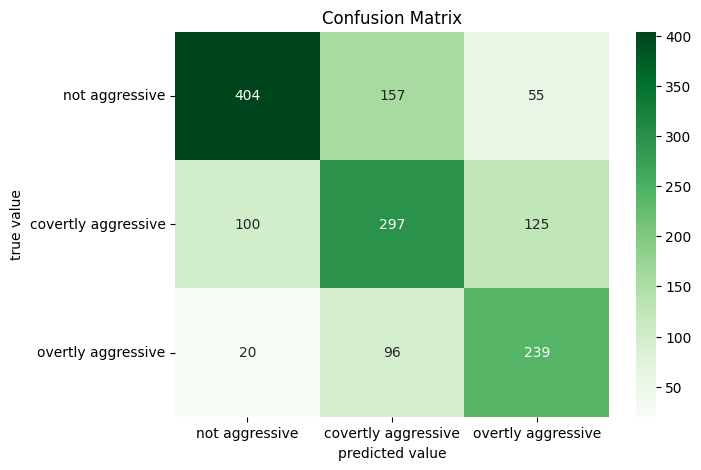

In [ ]:
y_true=d5_test.loc[:,'label']
X_test = pd.DataFrame(d5_test.apply(generate_test_prompt_cyb_detail_v3, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("d5_test aggression prediction  with cyber bullying")
evaluate(y_true, y_pred)